# Funcs

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import pymrio as pym
import re
import logging
from collections import namedtuple

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

from tqdm.auto import tqdm
tqdm.pandas()

import yaml

with open('../config/config.yaml') as f:
    snake_cfg = yaml.safe_load(stream=f.read())

sectors_common_aggreg = {
    sheet_name: pd.read_excel("../config/aggregation_files/sectors_common_aggreg.ods", sheet_name=sheet_name, index_col=0)
    for sheet_name in [
        "eora26_without_reexport_to_common_aggreg",
        "euregio_to_common_aggreg",
        "exiobase_full_to_common_aggreg",
        "icio2021_reworked_to_common_aggreg",
    ]
}

regions_common_aggreg = {
    sheet_name: pd.read_excel("../config/aggregation_files/regions_common_aggreg.ods", sheet_name=sheet_name, index_col=0)
    for sheet_name in [
        "eora26_without_reexport_to_common_aggreg",
        "euregio_to_common_aggreg",
        "exiobase_full_to_common_aggreg",
        "icio2021_reworked_to_common_aggreg",
    ]
}

def load_regions_aggreg(mrio_name):
    if "eora26" in mrio_name:
        return regions_common_aggreg["eora26_without_reexport_to_common_aggreg"]
    elif "euregio" in mrio_name:
        return regions_common_aggreg["euregio_to_common_aggreg"]
    elif "exiobase" in mrio_name:
        return regions_common_aggreg["exiobase_full_to_common_aggreg"]
    elif "oecd" in mrio_name:
        return regions_common_aggreg["icio2021_reworked_to_common_aggreg"]
    else:
        raise ValueError(f"Invalid MRIO name: {mrio_name}")

def load_sectors_aggreg(mrio_name):
    if "eora26" in mrio_name:
        return sectors_common_aggreg["eora26_without_reexport_to_common_aggreg"]
    elif "euregio" in mrio_name:
        return sectors_common_aggreg["euregio_to_common_aggreg"]
    elif "exiobase" in mrio_name:
        return sectors_common_aggreg["exiobase_full_to_common_aggreg"]
    elif "oecd" in mrio_name:
        return sectors_common_aggreg["icio2021_reworked_to_common_aggreg"]
    else:
        raise ValueError(f"Invalid MRIO name: {mrio_name}")

def aggreg_df(df,mrio_name):
    _df = df.copy()
    regions_aggreg = load_regions_aggreg(mrio_name)
    _df.rename(regions_aggreg["new region"].to_dict(), axis=1,level=0,inplace=True)
    _df = _df.groupby(["region","sector"],axis=1).sum()
    sectors_aggreg = load_sectors_aggreg(mrio_name)
    _df.rename(sectors_aggreg["new sector"].to_dict(), axis=1,level=1,inplace=True)
    _df = _df.groupby(["region","sector"],axis=1).sum()
    return _df



def drop_levels_with_identical_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a pandas DataFrame with a multi-level index, drop any levels for which all
    rows share the same index value.
    """
    # Get a list of the levels of the index
    levels = df.index.levels

    # Create a list of boolean masks indicating which levels should be dropped
    masks = [df.index.get_level_values(i).nunique() == 1 for i in range(len(levels))]

    # Drop the levels that should be dropped
    logger.info(
        f"Will drop these levels: { [df.index.levels[i].name for i, mask in enumerate(masks) if (mask and not df.index.levels[i].name in ['mrio','variable'] )] }"
    )
    df = df.droplevel(
        level=[
            i
            for i, mask in enumerate(masks)
            if (
                mask
                and not df.index.levels[i].name
                in ["mrio", "variable", "psi", "alpha_tau"]
            )
        ]
    )

    return df


def drop_xps(df, drop_dict):
    _df = df.copy()
    for key, val in drop_dict.items():
        if isinstance(val, str):
            val = [val]
        for v in val:
            try:
                _df.drop(index=str(v), level=key, inplace=True, axis=0)
            except KeyError:
                logger.warning(
                    f"You ask to remove rows where {key} = {val}, but none were found in the dataframe."
                )
    return _df


def prepare_df_general(inpt, drop_dict=None, drop_unused=True):
    """
    Prepare DataFrame for analysis.

    Args:
        inpt (str): Path to parquet file.
        drop_dict (dict): Dictionary of columns to drop.

    Returns:
        res_df (pandas.DataFrame): Prepared DataFrame.
    """
    res_df = pd.read_parquet(inpt)
    logger.info("Melting")
    res_df = res_df.melt(ignore_index=False).reset_index(level=["mrio", "mrio year"])
    logger.info("Joining mrio with year")
    res_df["mrio"] = res_df[["mrio", "mrio year"]].agg("_".join, axis=1)
    res_df.drop("mrio year", axis=1, inplace=True)
    res_df.set_index("mrio", append=True, inplace=True)

    if drop_dict:
        logger.info("Dropping xps to drop")
        res_df = drop_xps(res_df, drop_dict)

    if drop_unused:
        logger.info("Droping unused index levels")
        res_df = drop_levels_with_identical_values(res_df)

    logger.info("Reindexing")
    res_df = (
        res_df.reset_index()
        .set_index(["step", "region", "sector", "variable"])
        .sort_index()
    )

    col_var = list(res_df.columns[res_df.columns != "value"])
    logger.info("Experience naming")
    res_df["Experience"] = res_df[col_var].agg("~".join, axis=1)
    res_df.drop(col_var, axis=1, inplace=True)
    res_df = (
        res_df.reset_index()
        .set_index(["variable", "region", "sector", "step"])
        .sort_index()
    )

    return res_df


def prepare_df_local_analysis(inpt, region, drop_dict=None):
    """
    Prepare DataFrame for analysis for one region.

    Args:
        inpt (str): Path to parquet file.
        drop_dict (dict): Dictionary of columns to drop.

    Returns:
        res_df (pandas.DataFrame): Prepared DataFrame.
    """
    res_df = pd.read_parquet(inpt)
    logger.info("Selecting region")
    res_df = res_df.loc[:, region].sum(axis=1).copy()

    logger.info("Droping unused index levels")
    res_df = drop_levels_with_identical_values(res_df)

    res_df.name = "value"
    res_df = res_df.reset_index()

    res_df["mrio"] = res_df[["mrio", "mrio year"]].agg("_".join, axis=1)
    res_df.drop("mrio year", axis=1, inplace=True)
    res_df.set_index("mrio", inplace=True)

    if drop_dict:
        logger.info("Dropping xps to drop")
        res_df = drop_xps(res_df, drop_dict)

    logger.info("Reindexing")
    res_df = (
        res_df.reset_index()
        .set_index(["step", "variable", "recovery_sce", "mrio"])
        .sort_index()
    )

    col_var = list(res_df.columns[res_df.columns != "value"])
    logger.info("Experience naming")
    res_df["Experience"] = res_df[col_var].agg("~".join, axis=1)
    res_df.drop(col_var, axis=1, inplace=True)
    res_df = res_df.reset_index().set_index(["variable", "step"]).sort_index()
    return res_df


def prepare_df_2(df, neg_bins, pos_bins):
    def pct_change(x):
        return ((x - x.iloc[0]) / x.iloc[0]) * 100

    def yearly_pct_change_cumsum(x):
        return (x / 365).cumsum()

    max_neg_bins = list(neg_bins.values())
    max_neg_bins.append(np.inf)  #   # Define the bin edges
    max_neg_labels = neg_bins.keys()  #   # Define the bin labels
    max_pos_bins = list(pos_bins.values())
    max_pos_bins.append(
        np.inf
    )  # [-np.inf, 0, 2, 5, 10, 15, 20, 25, np.inf]  # Define the bin edges
    max_pos_labels = (
        pos_bins.keys()
    )  # ["no gains", "0%>G>2%", "2%>G>5%", "5%>G>10%", "10%>G>15%", "15%>G>20%", "20%>G>25%", "G>25%"]  # Define the bin labels

    _df = df.copy().reset_index()
    cols_to_groupby = list(
        _df.columns[(_df.columns != "value") & (_df.columns != "step")]
    )
    # _df.reset_index(inplace=True)
    # _df.set_index("step", inplace=True)
    # display(_df)
    _df["value_pct"] = _df.groupby(cols_to_groupby, axis=0, group_keys=False)[
        "value"
    ].apply(pct_change)
    _df["value_cumsum_pct"] = _df.groupby(cols_to_groupby, axis=0, group_keys=False)[
        "value_pct"
    ].apply(yearly_pct_change_cumsum)
    _df["max_neg_impact_value_pct"] = _df.groupby("Experience")["value_pct"].transform(
        min
    )
    _df["max_neg_impact_class"] = _df.groupby("Experience")[
        ["max_neg_impact_value_pct"]
    ].transform(lambda x: pd.cut(x, bins=max_neg_bins, labels=max_neg_labels))

    _df["max_pos_impact_value_pct"] = _df.groupby("Experience")["value_pct"].transform(
        max
    )
    _df["max_pos_impact_class"] = _df.groupby("Experience")[
        ["max_pos_impact_value_pct"]
    ].transform(lambda x: pd.cut(x, bins=max_pos_bins, labels=max_pos_labels))

    _df["mean_impact_value_pct"] = _df.groupby("Experience")["value_pct"].transform(
        np.mean
    )
    _df["mean_impact_class"] = _df.groupby("Experience")[
        ["mean_impact_value_pct"]
    ].transform(lambda x: pd.cut(x, bins=max_neg_bins, labels=max_neg_labels))

    _df["cumsum_pct_min"] = _df.groupby("Experience")["value_cumsum_pct"].transform(
        "min"
    )
    _df["cumsum_impact_class"] = _df.groupby("Experience")[
        ["cumsum_pct_min"]
    ].transform(lambda x: pd.cut(x, bins=max_neg_bins, labels=max_neg_labels))

    return _df

def load_mrio(filename: str, pkl_filepath) -> pym.IOSystem:
    """
    Loads the pickle file with the given filename.

    Args:
        filename: A string representing the name of the file to load (without the .pkl extension).
                  Valid file names follow the format <prefix>_<year>_full, where <prefix> is one of
                  'icio2021', 'euregio', 'exiobase3', or 'eora26', and <year> is a four-digit year
                  such as '2000' or '2010'.

    Returns:
        The loaded pickle file.

    Raises:
        ValueError: If the given filename does not match the valid file name format, or the file doesn't contain an IOSystem.

    """
    regex = re.compile(
        r"^(icio2021|euregio|exiobase3_ixi|eora26)_(\d{4})_full"
    )  # the regular expression to match filenames

    match = regex.match(filename)  # match the filename with the regular expression

    if not match:
        raise ValueError(f"The file name {filename} is not valid.")

    prefix, year = match.groups()  # get the prefix and year from the matched groups

    fullpath = pkl_filepath + prefix + "/" + filename + ".pkl"  # create the full file path

    logger.info(f"Loading {filename} mrio")
    with open(fullpath, "rb") as f:
        mrio = pickle.load(f)  # load the pickle file

    if not isinstance(mrio, pym.IOSystem):
        raise ValueError(f"{filename} was loaded but it is not an IOSystem")

    return mrio

def init_imp(mrio_name,aff_country,impact_as_GVA_share):
    mrio = load_mrio(mrio_name, pkl_filepath="../mriot_data/parsed/")
    aff_regions = mrio.get_regions()[mrio.get_regions().str.contains(aff_country)]
    return ((mrio.x.T - mrio.Z.sum(axis=0)).groupby("region",axis=1).sum()[aff_regions].sum() * impact_as_GVA_share).sum()

def get_flood_scenario(mrio_name, flood_scenario, smk_config):
    regex = re.compile(
        r"(?P<basename>(?:icio2021|euregio|exiobase3_ixi|eora26))_(?P<year>\d\d\d\d)_full"
    )  # the regular expression to match filenames

    match = regex.match(mrio_name)  # match the filename with the regular expression

    if not match:
        raise ValueError(f"The file name {mrio_name} is not valid.")

    mrio_basename = match["basename"]  # get the prefix and year from the matched groups
    mrio_year = int(match["year"])
    flood_scenarios = pd.read_csv(
        smk_config["flood_scenarios"],
        index_col=[0, 1, 2],
        converters={
            "regions_affected": ast.literal_eval,
            "productive_capital_impact_regional_distrib": ast.literal_eval,
        },
    )
    scenar = flood_scenarios.loc[(mrio_basename, flood_scenario, mrio_year)]
    return scenar

def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)

# Generate Initial Parameters Space

In [15]:
#logger.addHandler(logging.StreamHandler())

# Create a dictionary of lists for the given parameters
notebook_params_space = {
    'mrio': ["eora26_2000_full","eora26_2010_full",'exiobase3_ixi_2000_full',
             'exiobase3_ixi_2010_full', "euregio_2000_full", "euregio_2010_full"], 
    #'year': [2000, 2010],
    #'region_affected': [
    #    'DE',
        #'CN'
    #],
    'order': [
        'alt',
    #    'noalt'
    ],
    'psi': [
        #0.1,
        0.5,
        0.8,
        0.85,
        0.90,
        0.95,
        0.97,
        1.
    ],
    'base_alpha': [
        1
                  ],
    'max_alpha': [
        1.25,
        #1.35
    ],
    'tau_alpha': [
    #    30,
        90,
        180,
        365,
        530
    ],
    'sectors_scenario': [
        'default',
    ],
    'recovery_scenario': [
    "reclin3M",
  "reclin6M",
#  "recS6M",
  "reclin1Y",
  "reclin1_5Y",
  "reclin2Y",
#  "recS1Y",
#  "recS1_5Y",
  "reb3M",
  "reb6M",
  "reb1Y",
  "reb1_5Y",
  "reb2Y",
    ],
    'flood_scenario': [
        "germany21"
    ]
}

# Create a dataframe from the dictionary
notebook_params_space = pd.MultiIndex.from_product(notebook_params_space.values(), names=notebook_params_space.keys()).to_frame(index=False)
notebook_params_space.to_csv("../config/parameters_space_building.csv", index=False)

In [16]:
notebook_params_space

mrio order  psi  base_alpha  max_alpha  tau_alpha  \
0      eora26_full_2000   alt  0.5           1       1.25         90   
1      eora26_full_2000   alt  0.5           1       1.25         90   
2      eora26_full_2000   alt  0.5           1       1.25         90   
3      eora26_full_2000   alt  0.5           1       1.25         90   
4      eora26_full_2000   alt  0.5           1       1.25         90   
...                 ...   ...  ...         ...        ...        ...   
1675  euregio_full_2010   alt  1.0           1       1.25        530   
1676  euregio_full_2010   alt  1.0           1       1.25        530   
1677  euregio_full_2010   alt  1.0           1       1.25        530   
1678  euregio_full_2010   alt  1.0           1       1.25        530   
1679  euregio_full_2010   alt  1.0           1       1.25        530   

     sectors_scenario recovery_scenario flood_scenario  
0             default          reclin3M      germany21  
1             default          reclin6M      germany21  
2             default          reclin1Y      germany21  
3             default        reclin1_5Y      germany21  
4             default          reclin2Y      germany21  
...               ...               ...            ...  
1675          default             reb3M      germany21  
1676          default             reb6M      germany21  
1677          default             reb1Y      germany21  
1678          default           reb1_5Y      germany21  
1679          default             reb2Y      germany21  

[1680 rows x 9 columns]

## Remove xp from absurd results

In [4]:
res_df = prepare_df_general("../results/common_aggreg.parquet")
plot_df = prepare_df_2(res_df,
                       snake_cfg["impacts_bins"],
                       snake_cfg["gains_bins"]
                      )

2023-04-26 17:57:50 Melting
2023-04-26 17:57:51 Joining mrio with year
2023-04-26 17:58:48 Droping unused index levels
2023-04-26 17:58:53 Will drop these levels: ['sectors_sce', 'flood_sce', 'order type', 'alpha_base', 'alpha_max']
2023-04-26 17:58:53 Reindexing
2023-04-26 17:58:59 Experience naming


In [5]:
xp_to_remove_add = plot_df.loc[plot_df.loc[:,"cumsum_impact_class"] >= "absurd","Experience"]#.drop_duplicates()#.unique()#.str.split("~",expand=True)

In [34]:
bins = list(snake_cfg["impacts_bins"].values())
print(bins)

labels = list(snake_cfg["impacts_bins"].keys())
print(labels)

[-inf, -10, -5, -2, -1.5, -1, -0.5, -0.25, -0.1, 0]
['crash', 'absurd', '5L2', '2L1_5', '1_5L1', '1L0_5', '0_5L0_25', '0_25L0_1', '0_1L0', 'no_losses']


In [30]:
test = plot_df.copy()
test.query("cumsum_impact_class > 'absurd'", inplace=True)
test

ValueError: expr cannot be an empty string

In [26]:
a = reversed(snake_cfg["impacts_bins"].keys())
print(list(a))
b = reversed(snake_cfg["impacts_bins"].values())
print(list(b))


['no_losses', '0_1L0', '0_25L0_1', '0_5L0_25', '1L0_5', '1_5L1', '2L1_5', '5L2', 'absurd', 'crash']
[0, -0.1, -0.25, -0.5, -1, -1.5, -2, -5, -10, -inf]


In [64]:
general_df = pd.read_parquet("../results/general-plot_df-all_sim.parquet")
total_losses = general_df.copy()
total_losses = total_losses[["region","sector","step","value","Experience"]]
total_losses["value_diff"] = total_losses.groupby(["region","sector","Experience"])["value"].transform(lambda x : x - x.iloc[0])
total_losses = total_losses.groupby(["Experience","region"])["value_diff"].sum()
total_losses = total_losses.reset_index()
total_losses[["rec_sce","psi", "alpha_tau", "mrio"]] = total_losses.Experience.str.split("~",expand=True)
total_losses["Production change relative to direct shock (30B€)"] = total_losses["value_diff"] * (10**6/(30*10**9))
total_losses_DE = total_losses.loc[total_losses.region=="DEU"].copy()

In [65]:
xp_to_remove_add = pd.concat([total_losses_DE[total_losses_DE.value_diff.abs() > 30000].Experience,xp_to_remove_add],axis=0).drop_duplicates()

In [66]:
xp_to_remove_add

181     reb180~0.85~365~eora26_full_2000
191    reb180~0.85~365~euregio_full_2000
196    reb180~0.85~365~euregio_full_2010
256     reb180~0.8~365~euregio_full_2010
301     reb180~0.95~365~eora26_full_2000
306     reb180~0.95~365~eora26_full_2010
311    reb180~0.95~365~euregio_full_2000
316    reb180~0.95~365~euregio_full_2010
331      reb180~0.95~90~eora26_full_2000
336      reb180~0.95~90~eora26_full_2010
341     reb180~0.95~90~euregio_full_2000
346     reb180~0.95~90~euregio_full_2010
Name: Experience, dtype: object

In [67]:
xp_to_remove_add = xp_to_remove_add.str.split("~",expand=True)
xp_to_remove_add.columns = ["recovery_scenario","psi","tau_alpha","mrio"]
xp_to_remove_add.loc[xp_to_remove_add.mrio.str.startswith("exiobase3"),"mrio"] = xp_to_remove_add.loc[xp_to_remove_add.mrio.str.startswith("exiobase3"),"mrio"]+"_ixi"
xp_to_remove_add

recovery_scenario   psi tau_alpha               mrio
181            reb180  0.85       365   eora26_full_2000
191            reb180  0.85       365  euregio_full_2000
196            reb180  0.85       365  euregio_full_2010
256            reb180   0.8       365  euregio_full_2010
301            reb180  0.95       365   eora26_full_2000
306            reb180  0.95       365   eora26_full_2010
311            reb180  0.95       365  euregio_full_2000
316            reb180  0.95       365  euregio_full_2010
331            reb180  0.95        90   eora26_full_2000
336            reb180  0.95        90   eora26_full_2010
341            reb180  0.95        90  euregio_full_2000
346            reb180  0.95        90  euregio_full_2010

In [68]:
try:
    xp_to_remove = pd.read_csv("../config/xp_to_remove.csv", names=["recovery_scenario","psi","tau_alpha","mrio"])
except FileNotFoundError:
    xp_to_remove = pd.DataFrame()
    
pd.concat([xp_to_remove,xp_to_remove_add]).drop_duplicates().to_csv("../config/xp_to_remove.csv", index=False, header=False)

params_space = pd.read_csv("../config/parameters_space_building.csv")
xp_to_remove = pd.read_csv("../config/xp_to_remove.csv", names=["recovery_scenario","psi","tau_alpha","mrio"])
xp_to_remove.set_index(["recovery_scenario","psi","tau_alpha","mrio"],inplace=True)
params_space.set_index(["recovery_scenario","psi","tau_alpha","mrio"],inplace=True)

In [69]:
xp_to_remove

Empty DataFrame
Columns: []
Index: [(reb15q, 0.999, 30, euregio_full_2000), (reb15q, 0.999, 30, euregio_full_2010), (reb15q, 0.999, 30, exiobase3_full_2000_ixi), (reb15q, 0.999, 30, exiobase3_full_2010_ixi), (reb15q, 0.999, 365, euregio_full_2000), (reb15q, 0.999, 365, euregio_full_2010), (reb15q, 0.999, 365, exiobase3_full_2000_ixi), (reb15q, 0.999, 365, exiobase3_full_2010_ixi), (reb15, 0.5, 30, eora26_full_2000), (reb15, 0.5, 30, eora26_full_2010), (reb15, 0.5, 30, exiobase3_full_2000_ixi), (reb15, 0.5, 30, exiobase3_full_2010_ixi), (reb15, 0.5, 365, eora26_full_2000), (reb15, 0.5, 365, euregio_full_2000), (reb15, 0.5, 365, euregio_full_2010), (reb15, 0.8, 30, eora26_full_2010), (reb15, 0.8, 30, euregio_full_2000), (reb15, 0.8, 30, euregio_full_2010), (reb15, 0.8, 30, exiobase3_full_2000_ixi), (reb15, 0.8, 30, exiobase3_full_2010_ixi), (reb15, 0.8, 365, eora26_full_2010), (reb15, 0.8, 365, euregio_full_2000), (reb15, 0.8, 365, euregio_full_2010), (reb15, 0.999, 30, exiobase3_full_2000_ixi), (reb15, 0.999, 30, exiobase3_full_2010_ixi), (reb15, 0.999, 365, exiobase3_full_2000_ixi), (reb15, 0.999, 365, exiobase3_full_2010_ixi), (reb365, 0.5, 30, eora26_full_2000), (reb365, 0.5, 30, eora26_full_2010), (reb365, 0.5, 30, exiobase3_full_2000_ixi), (reb365, 0.5, 30, exiobase3_full_2010_ixi), (reb365, 0.8, 30, eora26_full_2000), (reb365, 0.8, 30, eora26_full_2010), (reb365, 0.8, 30, exiobase3_full_2000_ixi), (reb365, 0.8, 30, exiobase3_full_2010_ixi), (reb365, 0.999, 30, euregio_full_2000), (reb365, 0.999, 30, euregio_full_2010), (reb365, 0.999, 30, exiobase3_full_2000_ixi), (reb365, 0.999, 30, exiobase3_full_2010_ixi), (reb365, 0.999, 365, exiobase3_full_2000_ixi), (reb365, 0.999, 365, exiobase3_full_2010_ixi), (reb545, 0.5, 30, eora26_full_2000), (reb545, 0.5, 30, eora26_full_2010), (reb545, 0.5, 30, exiobase3_full_2000_ixi), (reb545, 0.8, 30, eora26_full_2000), (reb545, 0.8, 30, eora26_full_2010), (reb545, 0.8, 30, exiobase3_full_2000_ixi), (reb545, 0.999, 30, eora26_full_2010), (reb545, 0.999, 30, euregio_full_2000), (reb545, 0.999, 30, euregio_full_2010), (reb545, 0.999, 30, exiobase3_full_2000_ixi), (reb545, 0.999, 30, exiobase3_full_2010_ixi), (reb545, 0.999, 365, exiobase3_full_2000_ixi), (reb545, 0.999, 365, exiobase3_full_2010_ixi), (reb90q, 0.999, 30, eora26_full_2000), (reb90q, 0.999, 30, eora26_full_2010), (reb90q, 0.999, 30, euregio_full_2000), (reb90q, 0.999, 30, euregio_full_2010), (reb90q, 0.999, 30, exiobase3_full_2000_ixi), (reb90q, 0.999, 30, exiobase3_full_2010_ixi), (reb90q, 0.999, 365, eora26_full_2010), (reb90q, 0.999, 365, euregio_full_2000), (reb90q, 0.999, 365, euregio_full_2010), (reb90q, 0.999, 365, exiobase3_full_2000_ixi), (reb90q, 0.999, 365, exiobase3_full_2010_ixi), (reb90, 0.5, 30, eora26_full_2000), (reb90, 0.5, 30, eora26_full_2010), (reb90, 0.5, 30, exiobase3_full_2000_ixi), (reb90, 0.5, 30, exiobase3_full_2010_ixi), (reb90, 0.8, 30, eora26_full_2000), (reb90, 0.8, 30, eora26_full_2010), (reb90, 0.8, 30, exiobase3_full_2000_ixi), (reb90, 0.8, 30, exiobase3_full_2010_ixi), (reb90, 0.8, 365, eora26_full_2000), (reb90, 0.8, 365, euregio_full_2000), (reb90, 0.8, 365, euregio_full_2010), (reb90, 0.999, 30, exiobase3_full_2000_ixi), (reb90, 0.999, 30, exiobase3_full_2010_ixi), (reb90, 0.999, 365, exiobase3_full_2000_ixi), (reb90, 0.999, 365, exiobase3_full_2010_ixi), (reclin6, 0.999, 365, eora26_full_2000), (reclin6, 0.999, 365, eora26_full_2010), (reclin6, 0.999, 365, exiobase3_full_2000_ixi), (reclin6, 0.999, 365, exiobase3_full_2010_ixi), (reb15, 0.8, 30, eora26_full_2000), (reb15, 0.8, 365, eora26_full_2000), (reb15, 0.999, 30, eora26_full_2000), (reb90, 0.999, 30, eora26_full_2000), (reb15q, 0.999, 30, eora26_full_2000), (reb365, 0.999, 30, eora26_full_2000), (reb545, 0.999, 30, eora26_full_2000), (reb15, 0.999, 365, eora26_full_2000), (reb90, 0.999, 365, eora26_full_2000), (reb15q, 0.999, 365, eora26_full_2000), (reb90q, 0.999, 365, eora26_full_2000), (reb365, 0.999, 365, eora26_full_2000), (reb

In [70]:
params_space = params_space.drop(xp_to_remove.index, errors="ignore")

In [71]:
params_space.reset_index()

recovery_scenario   psi  tau_alpha               mrio order  base_alpha  \
0            reclin3M  0.80         90   eora26_full_2000   alt           1   
1            reclin6M  0.80         90   eora26_full_2000   alt           1   
2              recS6M  0.80         90   eora26_full_2000   alt           1   
3            reclin1Y  0.80         90   eora26_full_2000   alt           1   
4          reclin1_5Y  0.80         90   eora26_full_2000   alt           1   
..                ...   ...        ...                ...   ...         ...   
463             reb3M  0.95        365  euregio_full_2010   alt           1   
464             reb6M  0.95        365  euregio_full_2010   alt           1   
465             reb1Y  0.95        365  euregio_full_2010   alt           1   
466           reb1_5Y  0.95        365  euregio_full_2010   alt           1   
467             reb2Y  0.95        365  euregio_full_2010   alt           1   

     max_alpha sectors_scenario flood_scenario  
0         1.25          default      germany21  
1         1.25          default      germany21  
2         1.25          default      germany21  
3         1.25          default      germany21  
4         1.25          default      germany21  
..         ...              ...            ...  
463       1.25          default      germany21  
464       1.25          default      germany21  
465       1.25          default      germany21  
466       1.25          default      germany21  
467       1.25          default      germany21  

[468 rows x 9 columns]

In [72]:
params_space.reset_index()[["mrio","order","psi","base_alpha","max_alpha","tau_alpha","sectors_scenario","recovery_scenario","flood_scenario"]].to_csv("../config/parameters_space.csv",index=False)

In [99]:
pd.read_csv("../config/parameters_space.csv").groupby("mrio").sample(1, random_state=1).to_csv("../config/parameters_space_test.csv",index=False)

In [74]:
params_space.reset_index()

recovery_scenario   psi  tau_alpha               mrio order  base_alpha  \
0            reclin3M  0.80         90   eora26_full_2000   alt           1   
1            reclin6M  0.80         90   eora26_full_2000   alt           1   
2              recS6M  0.80         90   eora26_full_2000   alt           1   
3            reclin1Y  0.80         90   eora26_full_2000   alt           1   
4          reclin1_5Y  0.80         90   eora26_full_2000   alt           1   
..                ...   ...        ...                ...   ...         ...   
463             reb3M  0.95        365  euregio_full_2010   alt           1   
464             reb6M  0.95        365  euregio_full_2010   alt           1   
465             reb1Y  0.95        365  euregio_full_2010   alt           1   
466           reb1_5Y  0.95        365  euregio_full_2010   alt           1   
467             reb2Y  0.95        365  euregio_full_2010   alt           1   

     max_alpha sectors_scenario flood_scenario  
0         1.25          default      germany21  
1         1.25          default      germany21  
2         1.25          default      germany21  
3         1.25          default      germany21  
4         1.25          default      germany21  
..         ...              ...            ...  
463       1.25          default      germany21  
464       1.25          default      germany21  
465       1.25          default      germany21  
466       1.25          default      germany21  
467       1.25          default      germany21  

[468 rows x 9 columns]

variable region                          sector  step  \
0        production_realised    CHN           Agriculture and other     0   
1        production_realised    CHN           Agriculture and other     0   
2        production_realised    CHN           Agriculture and other     0   
3        production_realised    CHN           Agriculture and other     0   
4        production_realised    CHN           Agriculture and other     0   
...                      ...    ...                             ...   ...   
5781595  production_realised    USA  Sales, Transports and Services   729   
5781596  production_realised    USA  Sales, Transports and Services   729   
5781597  production_realised    USA  Sales, Transports and Services   729   
5781598  production_realised    USA  Sales, Transports and Services   729   
5781599  production_realised    USA  Sales, Transports and Services   729   

                value                          Experience  value_pct  \
0          827.146187     recfast~0.5~30~eora26_full_2000   0.000000   
1          827.146187     reclin2~0.5~30~eora26_full_2000   0.000000   
2          827.146187       recS2~0.5~30~eora26_full_2000   0.000000   
3          827.146187     reclin6~0.5~30~eora26_full_2000   0.000000   
4          827.146187       recS6~0.5~30~eora26_full_2000   0.000000   
...               ...                                 ...        ...   
5781595  25763.925760   reb90~0.999~365~euregio_full_2010  -1.244295   
5781596  26077.082926  reb15q~0.999~365~euregio_full_2010  -0.043932   
5781597  26081.625324  reb90q~0.999~365~euregio_full_2010  -0.026521   
5781598  25917.371751  reb365~0.999~365~euregio_full_2010  -0.656121   
5781599  25959.146753  reb545~0.999~365~euregio_full_2010  -0.495993   

         value_cumsum_pct  max_neg_impact_value_pct max_neg_impact_class  \
0                0.000000                 -1.004205                1_5L1   
1                0.000000                 -1.004205                1_5L1   
2                0.000000                 -1.004205                1_5L1   
3                0.000000                 -1.004205                1_5L1   
4                0.000000                 -1.004205                1_5L1   
...                   ...                       ...                  ...   
5781595         -1.663662                -20.588284                crash   
5781596         -0.301600                 -8.349175               absurd   
5781597         -0.180913                 -6.398326               absurd   
5781598         -0.721053                -11.728467                crash   
5781599         -0.509949                 -9.562085               absurd   

         max_pos_impact_value_pct max_pos_impact_class  mean_impact_value_pct  \
0                        0.058460                  0G2              -0.001529   
1                        0.107402                  0G2              -0.002953   
2                        0.060019                  0G2              -0.001951   
3                        0.152008                  0G2              -0.006070   
4                        0.068804                  0G2              -0.003521   
...                           ...                  ...                    ...   
5781595                  0.004402                  0G2              -3.909615   
5781596                  0.290897                  0G2              -1.048362   
5781597                  0.185911                  0G2              -0.880674   
5781598                  0.002644                  0G2              -2.311332   
5781599                  0.002158                  0G2              -1.909983   

        mean_impact_class  cumsum_pct_min cumsum_impact_class  
0                   0_1L0       -0.055726               0_1L0  
1                   0_1L0       -0.099329               0_1L0  
2                   0_1L0       -0.066315               0_1L0  
3                   0_1L0       -0.177276            0_25L0_1  
4                   0_1L

# Flood scenarios

In [160]:
mrio = load_mrio("euregio_full_2010", "../data-mriot/parsed/")
mrio.get_regions()[mrio.get_regions().str.contains("DE")]

2023-05-16 18:44:05 Loading euregio_full_2010 mrio


Index(['DE11', 'DE12', 'DE13', 'DE14', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25',
       'DE26', 'DE27', 'DE30', 'DE41', 'DE42', 'DE50', 'DE60', 'DE71', 'DE72',
       'DE73', 'DE80', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA1', 'DEA2', 'DEA3',
       'DEA4', 'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DEC0', 'DED1', 'DED2', 'DED3',
       'DEE0', 'DEF0', 'DEG0'],
      dtype='object', name='region')

In [158]:
mrio = load_mrio("exiobase3_ixi_full_2010", "../data-mriot/parsed/")
mrio.get_regions()[mrio.get_regions().str.contains("JP")]

2023-05-16 18:42:25 Loading exiobase3_full_2010 mrio


Index(['JP'], dtype='object', name='region')

In [18]:
(mrio.x.T - mrio.Z.sum(axis=0)).groupby("region",axis=1).sum()["DE"]

indout    4.299689e+06
Name: JP, dtype: float64

In [173]:
tmp2 = pd.Series([
            0.0046057242082654755,
            0.01687811919847528,
            0.000435120135527202,
            6.0050249275546e-05,
            0.0001757071905317333,
            1.9078363256291237e-05,
            0.000895982570460311,
            0.0012319973792574495,
            0.00016719183123763053,
            0.0014769374980126051,
            0.004891517387085255,
            0.0004698571762769888,
            6.3196018458983575e-06,
            0.014816908575385413,
            0.0009380935050203381,
            0.0009765605954465498,
            0.0006800048250428377,
            0.0005314619819669295,
            0.00019133484138808137,
            0.002231019560906867,
            0.0011467978850544503,
            0.011057882584421188,
            0.04316673958968223,
            0.0001951411168853459,
            0.0016739292102322498,
            1.4724888025430128e-06,
            0.07059893010080293,
            0.035186846595791424,
            0.0006421142288516084,
            0.001070130862973353,
            0.0008738012994480148,
            0.0009171232641628609,
            0.0009082117144139156,
            0.00015362691045364994,
            0.0005601688598165552,
            0.0003352707183847838,
            0.008171068430895259,
            4.271932777532741e-06,
            0.0001799020491253782,
            8.990797393648109e-06,
            1.3639811772094961e-05,
            3.324308226674999e-07,
            7.99051388681915e-06,
            2.552931808416825e-05,
            0.004417246809629573,
            0.0019002061858216213,
            0.00041359452912438844,
            0.002109363987426356,
            0.0008726535383475197,
            7.845895893444209e-06,
            0.01858354981335572,
            0.02299850193793092,
            0.00024392978074025797,
            0.0076089242540118805,
            0.00702853438709419,
            0.0008152348892734837,
            0.04074721924406175,
            0.012670191028279636,
            0.04242328763951666,
            0.001956575760752741,
            0.0013615376204580635,
            0.007393545987570305,
            0.00883595641036803,
            0.010062143679504941,
            0.0024673043363625928,
            0.0005511887886964319,
            0.001499606272183263,
            0.0032286361304427603,
            0.00026516943072313077,
            0.00017839292679261106,
            0.001158403546414151,
            9.492149085615462e-08,
            1.3254099210600571e-06,
            4.7864634436177585e-05,
            1.273640191429829e-06,
            1.1577609390204498e-05,
            0.08385623104862328,
            0.02200156553699276,
            0.0001109731137089854,
            0.01431130828257732,
            0.00020195661081493047,
            0.0015542132172432041,
            0.004539316307322268,
            0.00017636533041361996,
            0.015209650275762323,
            0.03280306959116413,
            0.0010436002453898295,
            7.352390411323204e-05,
            0.004360671714875893,
            4.8968013702121986e-05,
            0.005453975652682299,
            0.0014578242826245045,
            0.0004697514895703844,
            0.0006900524904353947,
            0.00167715293406606,
            4.703433407360229e-05,
            0.0011543290670649488,
            9.492149085615462e-08,
            0.00042257337431355187,
            0.0034339647041178698,
            0.0012555762619437534,
            0.0004118249764589294,
            0.0032735500604369797,
            0.00011374748509514317,
            0.0001121480079273802,
            0.000823670395345481,
            0.00021444478373543923,
            0.0078075739942542405,
            0.055145465559415116,
            0.012053324479995287,
            0.0003284137148548914,
            0.0009244534663488101,
            0.0006623178149101174,
            0.0021062035866684,
            0.0004035699479301873,
            0.0006621091061823634,
            0.0003135671764155011,
            5.175452515650752e-07,
            0.00038248362967316797,
            1.3449377148568944e-05,
            0.0019037741331197947,
            0.002676586324576074,
            0.0016116138207235926,
            0.0005992804689085096,
            0.11500723472710325,
            0.01945304085862609,
            0.0008678290682895934,
            0.001121407368866716,
            0.01474249251813889,
            0.005936961153649257,
            0.0011083676454861978,
            0.019039569611418623,
            0.02517794124420774,
            0.0002015669664699175,
            0.0008812099427581354,
            0.0286178138004102,
            0.0006245878706099289,
            0.003098155910759644,
            0.008851448452889606,
            0.00017879462181085711,
            0.00041399829446481506,
            0.03533915782381334,
            8.091439590943976e-07
        ], index=pd.MultiIndex.from_product([["DE"],sectors_df.loc[(sectors_df.affected==1)].index]))

ValueError: Length of values (143) does not match length of index (156)

In [177]:
len([
            0.0046057242082654755,
            0.01687811919847528,
            0.000435120135527202,
            6.0050249275546e-05,
            0.0001757071905317333,
            1.9078363256291237e-05,
            0.000895982570460311,
            0.0012319973792574495,
            0.00016719183123763053,
            0.0014769374980126051,
            0.004891517387085255,
            0.0004698571762769888,
            6.3196018458983575e-06,
            0.014816908575385413,
            0.0009380935050203381,
            0.0009765605954465498,
            0.0006800048250428377,
            0.0005314619819669295,
            0.00019133484138808137,
            0.002231019560906867,
            0.0011467978850544503,
            0.011057882584421188,
            0.04316673958968223,
            0.0001951411168853459,
            0.0016739292102322498,
            1.4724888025430128e-06,
            0.07059893010080293,
            0.035186846595791424,
            0.0006421142288516084,
            0.001070130862973353,
            0.0008738012994480148,
            0.0009171232641628609,
            0.0009082117144139156,
            0.00015362691045364994,
            0.0005601688598165552,
            0.0003352707183847838,
            0.008171068430895259,
            4.271932777532741e-06,
            0.0001799020491253782,
            8.990797393648109e-06,
            1.3639811772094961e-05,
            3.324308226674999e-07,
            7.99051388681915e-06,
            2.552931808416825e-05,
            0.004417246809629573,
            0.0019002061858216213,
            0.00041359452912438844,
            0.002109363987426356,
            0.0008726535383475197,
            7.845895893444209e-06,
            0.01858354981335572,
            0.02299850193793092,
            0.00024392978074025797,
            0.0076089242540118805,
            0.00702853438709419,
            0.0008152348892734837,
            0.04074721924406175,
            0.012670191028279636,
            0.04242328763951666,
            0.001956575760752741,
            0.0013615376204580635,
            0.007393545987570305,
            0.00883595641036803,
            0.010062143679504941,
            0.0024673043363625928,
            0.0005511887886964319,
            0.001499606272183263,
            0.0032286361304427603,
            0.00026516943072313077,
            0.00017839292679261106,
            0.001158403546414151,
            9.492149085615462e-08,
            1.3254099210600571e-06,
            4.7864634436177585e-05,
            1.273640191429829e-06,
            1.1577609390204498e-05,
            0.08385623104862328,
            0.02200156553699276,
            0.0001109731137089854,
            0.01431130828257732,
            0.00020195661081493047,
            0.0015542132172432041,
            0.004539316307322268,
            0.00017636533041361996,
            0.015209650275762323,
            0.03280306959116413,
            0.0010436002453898295,
            7.352390411323204e-05,
            0.004360671714875893,
            4.8968013702121986e-05,
            0.005453975652682299,
            0.0014578242826245045,
            0.0004697514895703844,
            0.0006900524904353947,
            0.00167715293406606,
            4.703433407360229e-05,
            0.0011543290670649488,
            9.492149085615462e-08,
            0.00042257337431355187,
            0.0034339647041178698,
            0.0012555762619437534,
            0.0004118249764589294,
            0.0032735500604369797,
            0.00011374748509514317,
            0.0001121480079273802,
            0.000823670395345481,
            0.00021444478373543923,
            0.0078075739942542405,
            0.055145465559415116,
            0.012053324479995287,
            0.0003284137148548914,
            0.0009244534663488101,
            0.0006623178149101174,
            0.0021062035866684,
            0.0004035699479301873,
            0.0006621091061823634,
            0.0003135671764155011,
            5.175452515650752e-07,
            0.00038248362967316797,
            1.3449377148568944e-05,
            0.0019037741331197947,
            0.002676586324576074,
            0.0016116138207235926,
            0.0005992804689085096,
            0.11500723472710325,
            0.01945304085862609,
            0.0008678290682895934,
            0.001121407368866716,
            0.01474249251813889,
            0.005936961153649257,
            0.0011083676454861978,
            0.019039569611418623,
            0.02517794124420774,
            0.0002015669664699175,
            0.0008812099427581354,
            0.0286178138004102,
            0.0006245878706099289,
            0.003098155910759644,
            0.008851448452889606,
            0.00017879462181085711,
            0.00041399829446481506,
            0.03533915782381334,
            8.091439590943976e-07
        ])

143

In [176]:
sectors_df.loc[(sectors_df.affected==1)].index

Index(['Manufacture of electrical machinery and apparatus n.e.c. (31)',
       'Manufacture of furniture; manufacturing n.e.c. (36)',
       'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)',
       'Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries',
       'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)',
       'Manufacture of motor vehicles, trailers and semi-trailers (34)',
       'Activities auxiliary to financial intermediation (67)',
       'Manufacture of office machinery and computers (30)',
       'Manufacture of wearing apparel; dressing and dyeing of fur (18)',
       'Manufacture of machinery and equipment n.e.c. (29)',
       ...
       'Retail sale of automotive fuel', 'Steam and hot water supply',
       'Sugar refining',
       'Supporting and auxiliary transport activities; activiti

In [141]:
tmp = pd.Series([
            1.0596463183284324e-05,
            7.52468673465397e-05,
            5.169123912919593e-05,
            0.00013904530734180768,
            0.00011371363988234275,
            7.28551158529171e-05,
            2.312297920897409e-05,
            3.4762640272490825e-05,
            8.40743213571709e-06,
            0.0002882530079846267,
            0.00012940250904379955,
            0.00035429712942704764,
            5.065946771622533e-06,
            7.330988419537208e-05,
            2.727171123381663e-05,
            8.065035928540896e-05,
            7.976166122119435e-05,
            0.00014502836261957131,
            0.00010280501356285081,
            6.178563435292271e-05,
            3.584531839069138e-05,
            2.657588123973226e-05,
            2.0222707561520886e-05,
            0.00031582563718605847,
            0.00015042905648423758,
            0.00028975331407307155,
            4.789791406128614e-06,
            3.9025713158532635e-05,
            2.2198059625669287e-05,
            8.091325120436756e-05,
            6.751369060296681e-05,
            0.0001323289405473977,
            0.0001598340212738375,
            5.65486937228268e-05,
            1.9563668633610775e-05,
            1.720357618726529e-05,
            2.6322460170796467e-05,
            0.00031068646983026726,
            0.00014375009480064007,
            0.0002926242674825516,
            5.069923366056598e-06,
            4.521304432748451e-05,
            1.758127807519312e-05,
            7.802956059112155e-05,
            5.904873983026951e-05,
            0.00015723454651331604,
            0.00014305253499514095,
            6.854359430960082e-05,
            3.2028256350327365e-05,
            1.8916265353383414e-05,
            8.937907271739366e-06,
            0.0003071213867640412,
            0.0001395788062771507,
            0.00030789837869259104,
            4.478085675687741e-06,
            3.732082107617564e-05,
            1.1359571630704257e-05,
            7.575136656858384e-05,
            4.600519935074775e-05,
            0.00015948015356150082,
            0.00017363366758152375,
            6.022397628458149e-05,
            1.3592105224221297e-05,
            1.9535176707798234e-05,
            4.217189667495975e-06,
            0.0003027152781609414,
            0.0001246923382936447,
            0.0003402150655271543,
            3.40174274792706e-06,
            4.494733046891339e-05,
            2.1289504329007855e-05,
            7.845877252428891e-05,
            6.164174655478266e-05,
            0.0001377354814064362,
            0.00012084678758267157,
            6.228052547985922e-05,
            1.7699542456959856e-05,
            2.2893343017769478e-05,
            6.744194302595118e-06,
            0.00031544718841910953,
            0.00016357190386918381,
            0.0003013015846293226,
            4.3464822503574585e-06,
            6.551310495339383e-05,
            1.9739849574466135e-05,
            8.873514015650155e-05,
            6.77272195605139e-05,
            0.00015008202197001395,
            8.922221468578993e-05,
            6.14962853136405e-05,
            3.1471751822879096e-05,
            2.4148439862568122e-05,
            6.235823447745919e-06,
            0.0003002381936907206,
            0.0001641208120721808,
            0.0003070954686347436,
            3.5903259564150075e-06,
            6.586661502755896e-05,
            0.00033183808056166643,
            0.000376080711652164,
            0.003192725575494859,
            0.008134484166935076,
            0.004718547841410692,
            0.0038948641000063912,
            0.0012050255037056041,
            0.0010918882473508037,
            0.0036988939435363116,
            0.017887016497483216,
            0.0085929446745945,
            0.02039041785876945,
            0.0006002898022228432,
            0.005615325901572221,
            0.0002705556813056118,
            0.0001994018704032782,
            0.0028973978862474273,
            0.00510308709761841,
            0.004353255359925078,
            0.003892022922450221,
            0.0011652296195881486,
            0.0006684455607427551,
            0.004078896145755562,
            0.01937261330719233,
            0.008369479652973294,
            0.02139335644302929,
            0.0004652035059936358,
            0.007501397852070765,
            0.0010710621274649511,
            0.00099503785615048,
            0.003679301155314347,
            0.008654339882062741,
            0.0032771071007047597,
            0.0036221896430744865,
            0.001972763721393528,
            0.001065894425993297,
            0.005274640536221601,
            0.01769376782637875,
            0.008341055739131856,
            0.01942713451666586,
            0.0005965739132572488,
            0.004059474461481894,
            0.0006652523529745943,
            0.004836075680021755,
            0.003191376996307908,
            0.009040919476160696,
            0.0060160231153053466,
            0.0032389546516752386,
            0.0015540001041041294,
            0.0010253114835629816,
            0.00017146216340840868,
            0.018016109385248624,
            0.008926477893733317,
            0.01931777490419766,
            0.00019504216780397263,
            0.0035355625307911705,
            0.000315808873571925,
            0.0002054859923730723,
            0.0030198181353864985,
            0.00861356533558547,
            0.007292178886640681,
            0.0035681522262978804,
            0.0009176620794556917,
            0.000942012072670081,
            0.0030026364528223234,
            0.018749607612142546,
            0.010484837209432721,
            0.01903156587036373,
            0.00017605399842908552,
            0.0034109581601240906,
            0.0025946535462108298,
            0.01156796753183542,
            0.01027535523925869,
            0.020878232229762133,
            0.008270575913183262,
            0.008086453334066138,
            0.002304840706628787,
            0.004048690796111521,
            0.0033138956649850855,
            0.04761368718463738,
            0.02121425724096072,
            0.04537887627777713,
            0.0005437614509221875,
            0.008373003872187427,
            0.004294747040281775,
            0.01151076133599761,
            0.010635534242733368,
            0.021305324220896576,
            0.008137367984665578,
            0.00797421463873554,
            0.00895195622302264,
            0.004776467475104779,
            0.0026968063366707303,
            0.04881238612018481,
            0.019129148427195368,
            0.04085217338721508,
            5.61562357568509e-05,
            0.005331207320066054,
            0.0035771105762262604,
            0.00039524374336296557,
            0.00907410077713856,
            0.020258308714763088,
            0.009191229791616042,
            0.008399628952530375,
            0.0034813969669252793,
            0.003005358176609133,
            0.0023346950405808728,
            0.04920777224912706,
            0.021120931810910525,
            0.047460195231633376,
            0.003878831809204801,
            0.013079447147898382,
            2.9941078513990682e-05,
            0.00014253472894422628,
            0.00014957618977735622,
            0.0002681223470715443,
            0.00012834272750885496,
            0.00012987725030775266,
            2.5022292084543687e-05,
            4.6162630780038834e-05,
            2.556610339551836e-05,
            0.0008666947649505244,
            0.0002476290074110664,
            0.0005948544203455026,
            8.908784984856244e-06,
            0.00010248146576104125,
            3.40738387411569e-05,
            0.0001508716329977877,
            0.00015095093515008796,
            0.000253206323394124,
            0.0002586395948971862,
            0.00010443232455155244,
            3.951040752685319e-05,
            6.663247780931743e-05,
            9.587423538294287e-05,
            0.000548914946827201,
            0.0002496515125262356,
            0.0007027608291961578,
            7.9200768326934e-06,
            0.00010227465600352012,
            3.455933326275251e-05,
            0.00012681047488157828,
            0.0001478104326146469,
            0.0003177522634408448,
            0.00012023392534638052,
            0.00014174139358470782,
            4.065406465358246e-05,
            5.87961812270014e-05,
            6.97069165773165e-05,
            0.0006728417715330229,
            0.00021103154826559087,
            0.0007167164255000811,
            9.76167851691587e-06,
            9.72973824323943e-05
        ], index=pd.MultiIndex.from_product([euregio_sce.regions_affected,[
            "Agriculture",
            "Coke_refined_petroleum_nuclear_fuel_and_chemicals_etc",
            "Construction",
            "Distribution",
            "Electrical_and_optical_equipment_and_Transport_equipment",
            "Financial_intermediation",
            "Food_beverages_and_tobacco",
            "Hotels_and_restaurant",
            "Mining_quarrying_and_energy_supply",
            "Non-Market_Service",
            "Other_manufacturing",
            "Real_estate_renting_and_busine_activitie",
            "Textiles_and_leather_etc",
            "Transport_storage_and_communication"
        ]]))

In [161]:
((tmp * 22316).loc[slice(None),"Construction"] /(mrio.x.T - mrio.Z.sum(axis=0)).T.loc[(euregio_sce.regions_affected,"Construction"),"indout"].values).sum()

0.6507226330944745

In [157]:
0.6507226330944745/ 39

0.013561394514074735

In [135]:
(mrio.x.T - mrio.Z.sum(axis=0)).T.loc[(euregio_sce.regions_affected,"Construction"),:].sum() / (mrio.x.T - mrio.Z.sum(axis=0)).T.loc[(euregio_sce.regions_affected,slice(None)),:].sum()

indout    0.0425
dtype: float64

In [7]:
init_imp(mrio_name="eora26_full_2000", aff_regions="DEU", impact_as_GVA_share=0.005389)

2023-04-27 14:35:45 Loading eora26_full_2000 mrio


10499924.715332646

In [5]:
prod_cap_impact_as_pct = ((19400 * 10**6) / (3.6*10**12))
house_impact_as_pct = ((14000 * 10**6) / (3.6*10**12))
indirect_impact = ((7000 * 10**6) / (3.6*10**12))

print(prod_cap_impact_as_pct*100)
print(house_impact_as_pct*100)
print(indirect_impact*100)

0.538888888888889
0.3888888888888889
0.19444444444444445


In [19]:
((200000 * 10**6) / (4.3*10**12))

0.046511627906976744

#### Germany 2021 Floods

In [9]:
prod_cap_impact_as_pct_deu = ((19400 * 10**6) / (3.6*10**12))
house_impact_as_pct_deu = ((14000 * 10**6) / (3.6*10**12))

prod_cap_impact_as_pct_jpn = ((200000 * 10**6) / (4.3*10**12))
#house_impact_as_pct_jpn = ((14000 * 10**6) / (3.6*10**12))

data = {
    'country_affected':['DE','DEU','DE',"JP","JPN","JPN"],
    'regions_affected':[['DE'],['DEU'],['DE21', 'DE22', 'DE23', 'DE24', 'DE25', 'DE26', 'DE27', 'DEA1', 'DEA2', 'DEA3', 'DEA4', 'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DED1', 'DED2', 'DED3'], ["JP"],["JPN"], ["JPN"]],
    'productive_capital_impact_GVA_share':[prod_cap_impact_as_pct_deu,prod_cap_impact_as_pct_deu,prod_cap_impact_as_pct_deu,prod_cap_impact_as_pct_jpn,prod_cap_impact_as_pct_jpn,prod_cap_impact_as_pct_jpn],
    'households_impact_GVA_share':[house_impact_as_pct_deu,house_impact_as_pct_deu,house_impact_as_pct_deu,0.,0.,0.],
    'impact unit':["share of GVA","share of GVA","share of GVA","share of GVA","share of GVA","share of GVA"],
    'productive_capital_impact_regional_distrib':[[1.],
                                                  [1.],
                                                  [0.00137977016177574,0.00137977016177574,0.00137977016177574,0.00137977016177574,0.00137977016177574,0.00137977016177574,0.00137977016177574,0.0797303429052959,0.0797303429052959,0.0797303429052959,0.0797303429052959,0.0797303429052959,0.194464250988527,0.194464250988527,0.194464250988527,0.00276571379183682,0.00276571379183682,0.00276571379183682],
                                                  [1.],
                                                  [1.],
                                                  [1.],
                                                 ],
    'productive_capital_impact_sectoral_distrib_type':["gdp","gdp","gdp","gdp","gdp","gdp"],
    'duration':[14,14,14,14,14,14]
}
df_flood = pd.DataFrame(data)
df_flood = pd.concat([pd.DataFrame({"mrio":['exiobase3_ixi',"eora26", "euregio",'exiobase3_ixi',"eora26", "euregio"],"aggreg":['full',"full", "full",'full',"full", "full"],"flood_scenario":["germany21","germany21","germany21","japan11","japan11","japan11"]}),df_flood],axis=1)
df_flood = pd.DataFrame(["2000","2010"],columns=["mrio year"]).merge(df_flood, how="cross")
df_flood["productive_capital_impact"] = df_flood.apply(lambda row : init_imp(row["mrio"]+"_"+str(row["mrio year"]+"_"+str(row['aggreg'])), row["country_affected"], row["productive_capital_impact_GVA_share"]), axis=1)
df_flood["households_impact"] = df_flood.apply(lambda row : init_imp(row["mrio"]+"_"+str(row["mrio year"]), row["country_affected"], row["households_impact_GVA_share"]), axis=1)
df_flood.set_index(["mrio","flood_scenario","mrio year"],inplace=True)

2024-02-02 15:28:32 Loading exiobase3_ixi_2000_full mrio


FileNotFoundError: [Errno 2] No such file or directory: '../mrio_data/parsed/exiobase3_ixi/exiobase3_ixi_2000_full.pkl'

In [21]:
df_flood

country_affected   
mrio           flood_scenario mrio year                    
exiobase3_full germany21      2000                    DE  \
eora26_full    germany21      2000                   DEU   
euregio_full   germany21      2000                    DE   
exiobase3_full japan11        2000                    JP   
eora26_full    japan11        2000                   JPN   
euregio_full   japan11        2000                   JPN   
exiobase3_full germany21      2010                    DE   
eora26_full    germany21      2010                   DEU   
euregio_full   germany21      2010                    DE   
exiobase3_full japan11        2010                    JP   
eora26_full    japan11        2010                   JPN   
euregio_full   japan11        2010                   JPN   

                                                                          regions_affected   
mrio           flood_scenario mrio year                                                      
exiobase3_full germany21      2000                                                    [DE]  \
eora26_full    germany21      2000                                                   [DEU]   
euregio_full   germany21      2000       [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   
exiobase3_full japan11        2000                                                    [JP]   
eora26_full    japan11        2000                                                   [JPN]   
euregio_full   japan11        2000                                                   [JPN]   
exiobase3_full germany21      2010                                                    [DE]   
eora26_full    germany21      2010                                                   [DEU]   
euregio_full   germany21      2010       [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   
exiobase3_full japan11        2010                                                    [JP]   
eora26_full    japan11        2010                                                   [JPN]   
euregio_full   japan11        2010                                                   [JPN]   

                                         productive_capital_impact_GVA_share   
mrio           flood_scenario mrio year                                        
exiobase3_full germany21      2000                                  0.005389  \
eora26_full    germany21      2000                                  0.005389   
euregio_full   germany21      2000                                  0.005389   
exiobase3_full japan11        2000                                  0.046512   
eora26_full    japan11        2000                                  0.046512   
euregio_full   japan11        2000                                  0.046512   
exiobase3_full germany21      2010                                  0.005389   
eora26_full    germany21      2010                                  0.005389   
euregio_full   germany21      2010                                  0.005389   
exiobase3_full japan11        2010                                  0.046512   
eora26_full    japan11        2010                                  0.046512   
euregio_full   japan11        2010                                  0.046512   

                                         households_impact_GVA_share   
mrio           flood_scenario mrio year                                
exiobase3_full germany21      2000                          0.003889  \
eora26_full    germany21      2000                          0.003889   
euregio_full   germany21      2000                          0.003889   
exiobase3_full japan11        2000                          0.000000   
eora26_full    japan11        2000                          0.000000   
euregio_full   japan11        2000                          0.000000   
exiobase3_full germany21      2010                          0.003889   
eora26_full    germany21      2010                          0.003889   
euregio_full   germany21      2010       

In [5]:
tmp = df_flood.reset_index()[["mrio","mrio year", "productive_capital_impact","households_impact","regions_affected","duration"]].copy()
tmp["MRIOT"] = tmp["mrio"]+"_"+tmp["mrio year"].astype(str)
tmp["Regions affected"] = tmp["regions_affected"]
tmp["impact"] = (tmp["productive_capital_impact"]+tmp["households_impact"])
tmp["unit"] = [10**6,10**3, 10**6,10**6,10**3, 10**6]
tmp["impact"] = ((tmp["impact"] * tmp["unit"])/10**6).round()
tmp["monetary unit"] = ["M€_2000","M$_2000", "M$_2000","M€_2010","M$_2010", "M$_2010"]
df_flood_readable = tmp[["MRIOT","Regions affected","impact","monetary unit", "duration"]]


In [6]:
df_flood_readable

MRIOT                                   Regions affected   
0  exiobase3_full_2000                                               [DE]  \
1     eora26_full_2000                                              [DEU]   
2    euregio_full_2000  [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   
3  exiobase3_full_2010                                               [DE]   
4     eora26_full_2010                                              [DEU]   
5    euregio_full_2010  [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   

    impact monetary unit  duration  
0  19519.0       M€_2000        14  
1  18077.0       M$_2000        14  
2  18138.0       M$_2000        14  
3  23769.0       M€_2010        14  
4  32191.0       M$_2010        14  
5  22316.0       M$_2010        14

In [5]:
df_flood.to_csv("../BoARIO-Sensitivity/config/flood_scenarios.csv")
df_flood_readable.to_csv("../BoARIO-Sensitivity/config/flood_scenarios_readable.csv")

NameError: name 'df_flood' is not defined

In [101]:
import ast
df_flood = pd.read_csv("../BoARIO-Sensitivity/config/flood_scenarios.csv", index_col=[0,1,2], converters={"regions_affected":ast.literal_eval, "impact_regional_distrib":ast.literal_eval})
df_flood#.loc["euregio_full","impact_regional_distrib"]

country_affected   
mrio           flood_scenario mrio year                    
exiobase3_full germany21      2000                    DE  \
eora26_full    germany21      2000                   DEU   
euregio_full   germany21      2000                    DE   
exiobase3_full germany21      2010                    DE   
eora26_full    germany21      2010                   DEU   
euregio_full   germany21      2010                    DE   

                                                                          regions_affected   
mrio           flood_scenario mrio year                                                      
exiobase3_full germany21      2000                                                    [DE]  \
eora26_full    germany21      2000                                                   [DEU]   
euregio_full   germany21      2000       [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   
exiobase3_full germany21      2010                                                    [DE]   
eora26_full    germany21      2010                                                   [DEU]   
euregio_full   germany21      2010       [DE21, DE22, DE23, DE24, DE25, DE26, DE27, DEA...   

                                         productive_capital_impact_GVA_share   
mrio           flood_scenario mrio year                                        
exiobase3_full germany21      2000                                  0.005389  \
eora26_full    germany21      2000                                  0.005389   
euregio_full   germany21      2000                                  0.005389   
exiobase3_full germany21      2010                                  0.005389   
eora26_full    germany21      2010                                  0.005389   
euregio_full   germany21      2010                                  0.005389   

                                         households_impact_GVA_share   
mrio           flood_scenario mrio year                                
exiobase3_full germany21      2000                          0.003889  \
eora26_full    germany21      2000                          0.003889   
euregio_full   germany21      2000                          0.003889   
exiobase3_full germany21      2010                          0.003889   
eora26_full    germany21      2010                          0.003889   
euregio_full   germany21      2010                          0.003889   

                                          impact unit   
mrio           flood_scenario mrio year                 
exiobase3_full germany21      2000       share of GVA  \
eora26_full    germany21      2000       share of GVA   
euregio_full   germany21      2000       share of GVA   
exiobase3_full germany21      2010       share of GVA   
eora26_full    germany21      2010       share of GVA   
euregio_full   germany21      2010       share of GVA   

                                                productive_capital_impact_regional_distrib   
mrio           flood_scenario mrio year                                                      
exiobase3_full germany21      2000                                                   [1.0]  \
eora26_full    germany21      2000                                                   [1.0]   
euregio_full   germany21      2000       [0.00137977016177574, 0.00137977016177574, 0.0...   
exiobase3_full germany21      2010                                                   [1.0]   
eora26_full    germany21      2010                                                   [1.0]   
euregio_full   germany21      2010       [0.00137977016177574, 0.00137977016177574, 0.0...   

                                        productive_capital_impact_sectoral_distrib_type   
mrio           flood_scenario mrio year                                                   
exiobase3_full germany21      2000                                                  gdp  \
eora26_full    germany21      2000                                                  gdp   
euregio_full  

In [103]:
euregio_sce = get_flood_scenario("euregio_full_2000","germany21",{"flood_scenarios":"../BoARIO-Sensitivity/config/flood_scenarios.csv"})

In [163]:
exiobase_sce = get_flood_scenario("exiobase3_full_2010","germany21",{"flood_scenarios":"../BoARIO-Sensitivity/config/flood_scenarios.csv"})

In [164]:
exiobase_sce

country_affected                                             DE
regions_affected                                           [DE]
productive_capital_impact_GVA_share                    0.005389
households_impact_GVA_share                            0.003889
impact unit                                        share of GVA
productive_capital_impact_regional_distrib                [1.0]
productive_capital_impact_sectoral_distrib_type             gdp
duration                                                     14
productive_capital_impact                          13805.970237
households_impact                                   9963.071305
Name: (exiobase3_full, germany21, 2010), dtype: object

In [165]:
sectors_df = pd.read_csv("../BoARIO-Sensitivity/config/exiobase3_full_sectors.csv", index_col=0, decimal=".")


In [103]:
sectors_df.loc[
    sectors_df.rebuilding_factor > 0, "rebuilding_factor"
].to_dict()


{'Construction (45)': 0.55,
 'Manufacture of electrical machinery and apparatus n.e.c. (31)': 0.1,
 'Manufacture of furniture; manufacturing n.e.c. (36)': 0.06,
 'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)': 0.05,
 'Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries': 0.05,
 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)': 0.05,
 'Manufacture of motor vehicles, trailers and semi-trailers (34)': 0.04,
 'Activities auxiliary to financial intermediation (67)': 0.03,
 'Manufacture of office machinery and computers (30)': 25.0,
 'Manufacture of wearing apparel; dressing and dyeing of fur (18)': 15.0,
 'Manufacture of machinery and equipment n.e.c. (29)': 0.01,
 'Manufacture of other transport equipment (35)': 0.01,
 'Retail trade, except of motor vehicles and motorcycles; repair of personal and househ

In [ ]:
df_flood.loc[("euregio_full","germany21")]

In [ ]:
aggreg = pd.read_excel("../BoARIO-Sensitivity/config/common_aggreg.ods", sheet_name="euregio_to_common_aggreg")
aggreg.set_index("original sector")["new sector"].to_dict()
df.columns = df.columns.set_levels(df.columns.get_level_values(1).map(aggreg.set_index("original sector")["new sector"].to_dict()),level=1, verify_integrity=False)
df = df.groupby(["region","sector"],axis=1).sum()

In [ ]:
sns.set_context("paper")

variable = 'production_realised'
region = 'DEU'
sector = 'Manufacture'


variable_name = {
    "production_realised":"production"
}


plot_variable_grid(
    plot_df,
    variable,
    selection={"recovery_sce": "reb15"},
    exclusion=None,
    plot_type="classic",
    hue="mrio",
    row=None,
    col="Experience",
    row_order=None,
    col_wrap = 3,
)

In [ ]:
distrib = plot_df[["Experience","max_neg_impact_class"]].groupby("Experience").first()
distrib.value_counts().plot(kind='barh')

In [ ]:
plot_variable_grid(plot_df, variable, plot_type="cumsum", selection={"max_neg_impact_class":["10L5", "5L2", "2L0", "no losses"]})

In [ ]:
plot_variable_grid(plot_df, variable, plot_type="cumsum", selection={"max_neg_impact_class":"25L10"})

In [ ]:
plot_variable_grid(plot_df, variable, plot_type="cumsum", selection={"max_neg_impact_class":"50L25"})

In [ ]:
plot_variable_grid(plot_df, variable, plot_type="cumsum", selection={"max_neg_impact_class":"70L50"})

In [ ]:
res_df = prepare_res_df("../BoARIO-Sensitivity/results/common_aggreg.parquet", drop_dict={"psi": ["0.5","0.999"], "alpha_tau": "365", "recovery_sce":["recfast","reclin2","recS2","reclin6","recS6"],"mrio":["eora26_full_2000","eora26_full_2010"]})
plot_variable_grid(res_df, variable, output="test2.svg", plot_type="cumsum",)

# Snakemake Benchmarking

In [ ]:
import snakemake_ba

import pathlib

data2 = snakemake_ba.parser.stats_of_rules(pathlib.Path("../BoARIO-Sensitivity/"),
                                           #snakemake_bench_patern="benchmarks/plot_results_{focus}_{variable}_{type}_{ext}.log")
                                          snakemake_bench_patern="benchmarks/simulations/mrio~{mrio}/sectors_scenario~{sectors_scenario}/recovery_scenario~{recovery_scenario}/flood_scenario~{flood_scenario}/order~{order}_psi~{psi}_base_alpha~{base_alpha}_max_alpha~{max_alpha}_tau_alpha~{tau_alpha}.log")

In [ ]:
data2.sort_values(by="max_rss")

In [ ]:
data.sort_values(by="cpu_time")

In [ ]:
chart = snakemake_ba.plot.dynamic_scatter_plot(data, x='s', y='max_rss', group='support')
chart.save("plot.html")

In [ ]:
chart

In [ ]:
test = pd.read_parquet("../BoARIO-Sensitivity/production_realised.parquet")

# Simulations testing

In [ ]:
import ast
import sys
import re
import subprocess
import pathlib
import pandas as pd
import logging, traceback
import pickle
import pymrio as pym

import logging
from collections import namedtuple

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

from boario import logger as lg
from boario.event import EventKapitalRebuild, EventKapitalRecover
from boario.simulation import Simulation
from boario.extended_models import ARIOPsiModel

lg.addHandler(logging.StreamHandler())

import boario

def dist_is_editable():
    """Is distribution an editable install?"""
    for pth in boario.__path__:
        if "site-packages" in pth:
            return False
    return True


def get_git_describe() -> str:
    return (
        subprocess.check_output(["git", "describe", "--tags"]).decode("ascii").strip()
    )


def load_mrio(filename: str) -> pym.IOSystem:
    """
    Loads the pickle file with the given filename.

    Args:
        filename: A string representing the name of the file to load (without the .pkl extension).
                  Valid file names follow the format <prefix>_full_<year>, where <prefix> is one of
                  'oecd_v2021', 'euregio', 'exiobase3', or 'eora26', and <year> is a four-digit year
                  such as '2000' or '2010'.

    Returns:
        The loaded pickle file.

    Raises:
        ValueError: If the given filename does not match the valid file name format, or the file doesn't contain an IOSystem.

    """
    filepath = "../BoARIO-Sensitivity/mrio-files/pkls/"  # the path to the pickle files
    regex = re.compile(
        r"^(oecd_v2021|euregio|exiobase3|eora26)_full_(\d{4})"
    )  # the regular expression to match filenames

    match = regex.match(filename)  # match the filename with the regular expression

    if not match:
        raise ValueError(f"The file name {filename} is not valid.")

    prefix, year = match.groups()  # get the prefix and year from the matched groups

    fullpath = filepath + prefix + "/" + filename + ".pkl"  # create the full file path

    logger.info(f"Loading {filename} mrio")
    with open(fullpath, "rb") as f:
        mrio = pickle.load(f)  # load the pickle file

    if not isinstance(mrio, pym.IOSystem):
        raise ValueError(f"{filename} was loaded but it is not an IOSystem")

    return mrio


def get_flood_scenario(mrio_name, flood_scenario, smk_config):
    regex = re.compile(
        r"^((?:oecd_v2021|euregio|exiobase3|eora26)_full)"
    )  # the regular expression to match filenames

    match = regex.match(mrio_name)  # match the filename with the regular expression

    if not match:
        raise ValueError(f"The file name {mrio_name} is not valid.")

    mrio_basename = match.groups()[0]  # get the prefix and year from the matched groups
    flood_scenarios = pd.read_csv(
        smk_config["flood_scenarios"],
        index_col=[0, 1],
        converters={
            "regions_affected": ast.literal_eval,
            "productive_capital_impact_regional_distrib": ast.literal_eval,
        },
    )
    scenar = flood_scenarios.loc[(mrio_basename, flood_scenario)]
    return scenar


def create_event(
    mrio_name,
    flood_scenario,
    recovery_scenario,
    sectors_df,
    smk_config,
):
    aff_sectors = sectors_df.loc[sectors_df.affected == 1].index
    rebuilding_sectors = sectors_df.loc[
        sectors_df.rebuilding_factor > 0, "rebuilding_factor"
    ].to_dict()
    scenar = get_flood_scenario(mrio_name, flood_scenario, smk_config)
    logger.debug(
        f"Creating event from : productive_capital_impact {scenar.productive_capital_impact} ; households_impact {scenar.households_impact} ; duration {scenar.duration} ; aff_sectors {aff_sectors} ; reb_sectors {rebuilding_sectors}"
    )
    sce_tuple = recovery_scenario
    productive_capital_impact = int(scenar.productive_capital_impact)
    households_impact = int(scenar.households_impact)
    duration = scenar.duration
    aff_regions = scenar.regions_affected
    productive_capital_impact_regional_distrib = scenar.productive_capital_impact_regional_distrib
    productive_capital_impact_sectoral_distrib_type = scenar.productive_capital_impact_sectoral_distrib_type
    if sce_tuple[0] == "recovery":
        event = EventKapitalRecover(
            productive_capital_impact,
            recovery_function=sce_tuple[1],
            recovery_time=sce_tuple[2],
            aff_regions=aff_regions,
            productive_capital_impact_regional_distrib=productive_capital_impact_regional_distrib,
            aff_sectors=aff_sectors,
            productive_capital_impact_sectoral_distrib_type=productive_capital_impact_sectoral_distrib_type,
            duration=duration,
            event_monetary_factor=10**6,
        )
    elif sce_tuple[0] == "rebuilding":
        event = EventKapitalRebuild(
            productive_capital_impact=productive_capital_impact,
            households_impact=households_impact,
            rebuilding_sectors=rebuilding_sectors,
            rebuild_tau=sce_tuple[2],
            aff_regions=aff_regions,
            productive_capital_impact_regional_distrib=productive_capital_impact_regional_distrib,
            aff_sectors=aff_sectors,
            productive_capital_impact_sectoral_distrib_type=productive_capital_impact_sectoral_distrib_type,
            duration=duration,
            rebuilding_factor=sce_tuple[1],
            event_monetary_factor=10**6,
        )
    else:
        raise ValueError(
            f'Invalid event type: {sce_tuple[0]} (expected "recovery" or "rebuilding")'
        )

    return event


def run(
    mrio_name,
    order_type,
    psi_param,
    tau_alpha,
    base_alpha,
    max_alpha,
    recovery_scenario,
    flood_scenario,
    output_dir,
    output_parquets,
    monetary_factor,
    sim_length,
    register_stocks,
    sectors_df,
):
    mrio = load_mrio(mrio_name)

    model = ARIOPsiModel(
        pym_mrio=mrio,
        order_type=order_type,
        alpha_base=base_alpha,
        alpha_max=max_alpha,
        alpha_tau=tau_alpha,
        rebuild_tau=1,
        monetary_factor=monetary_factor,
        temporal_units_by_step=1,
        iotable_year_to_temporal_unit_factor=365,
        productive_capital_to_VA_dict=sectors_df.productive_capital_to_va_ratio.to_dict(),
        psi_param=psi_param,
        inventory_restoration_tau=sectors_df.inventory_tau.to_dict(),
        inventory_dict=sectors_df.inventory_size.to_dict(),
    )

    sim = Simulation(
        model=model,
        register_stocks=register_stocks,
        n_temporal_units_to_sim=sim_length,
        boario_output_dir=output_dir,
        save_events=True,
        save_params=True,
        save_index=True,
        save_records=[],
    )

    logger.info(f"Building event from:\n {flood_scenario}")
    event = create_event(
        mrio_name,
        flood_scenario,
        recovery_scenario,
        sectors_df,
        smk_config,
    )

    sim.add_event(event)
    try:
        logger.info("Model ready, looping")
        sim.loop(progress=False)
    except Exception:
        logger.exception("There was a problem:")
    
    return event, sim
    output_parquets.mkdir(exist_ok=True, parents=True)

    sim.production_realised.to_parquet(output_parquets / "production_realised.parquet")
    sim.production_capacity.to_parquet(output_parquets / "production_capacity.parquet")
    sim.overproduction.to_parquet(output_parquets / "overproduction.parquet")
    sim.rebuild_prod.to_parquet(output_parquets / "rebuild_prod.parquet")
    sim.final_demand.to_parquet(output_parquets / "final_demand.parquet")
    sim.final_demand_unmet.to_parquet(output_parquets / "final_demand_unmet.parquet")
    sim.intermediate_demand.to_parquet(output_parquets / "intermediate_demand.parquet")
    sim.rebuild_demand.to_parquet(output_parquets / "rebuild_demand.parquet")
    sim.productive_capital_to_recover.to_parquet(output_parquets / "productive_capital_to_recover.parquet")
    


# conf = load_config(snakemake.config, snakemake.wildcards, snakemake.input, snakemake.output.output_dir, snakemake.params)
import yaml

with open('../BoARIO-Sensitivity/config/config.yaml') as f:
    d = yaml.safe_load(stream=f.read())

simulation_params = {
    "mrio":"exiobase3_full_2000_ixi",
    "order":"alt",
    "psi":0.5,
    "base_alpha":1,
    "max_alpha":1.25,
    "tau_alpha":30
}
sectors_df = pd.read_csv("../BoARIO-Sensitivity/config/exiobase3_full_sectors.csv", index_col=0, decimal=".")
smk_config = d
smk_config["flood_scenarios"] = "../BoARIO-Sensitivity/config/flood_scenarios.csv"
smk_config["sim_length"] = 365
output_dir = "./tmp"
output_parquets = ""
flood_scenario = "germany21"
recovery_scenario = smk_config["recovery_scenarios"][
    "reb15q"
]

recovery_scenario[2] = 1
event, sim = run(
    mrio_name=simulation_params["mrio"],
    order_type=simulation_params["order"],
    psi_param=simulation_params["psi"],
    tau_alpha=simulation_params["tau_alpha"],
    base_alpha=simulation_params["base_alpha"],
    max_alpha=simulation_params["max_alpha"],
    recovery_scenario=recovery_scenario,
    flood_scenario=flood_scenario,
    output_dir=output_dir,
    output_parquets=output_parquets,
    monetary_factor=smk_config["monetary_factor"]["exiobase3_full"],
    sim_length=smk_config["sim_length"],
    register_stocks=smk_config["register_stocks"],
    sectors_df=sectors_df,
)

<AxesSubplot: xlabel='step'>

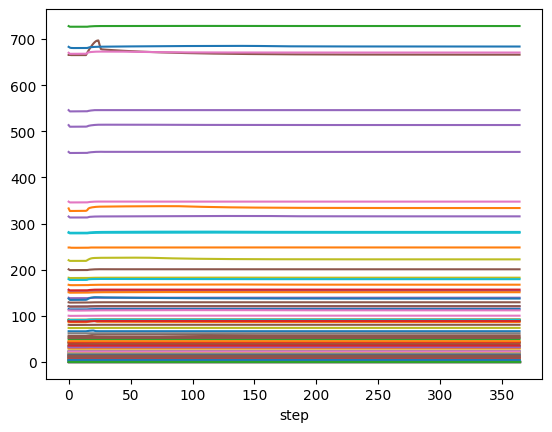

In [3]:
sim.production_realised.loc[:,"DE"].plot(legend=False)

In [18]:
pd.DataFrame(sim.model.k_stock,index=sim.model.industries).T.loc[:,"DE"].sum(axis=1)

0    5.236666e+06
dtype: float64

In [46]:
event._rebuilding_sectors_shares.shape

(7987,)

In [23]:
event.total_productive_capital_destroyed

19400.0

In [50]:
sectors_df = pd.read_csv("../BoARIO-Sensitivity/config/exiobase3_full_sectors.csv", index_col=0, decimal=".")
sectors_df.loc[
        sectors_df.rebuilding_factor > 0, "rebuilding_factor"
    ].sum()

1.0

<AxesSubplot: xlabel='step'>

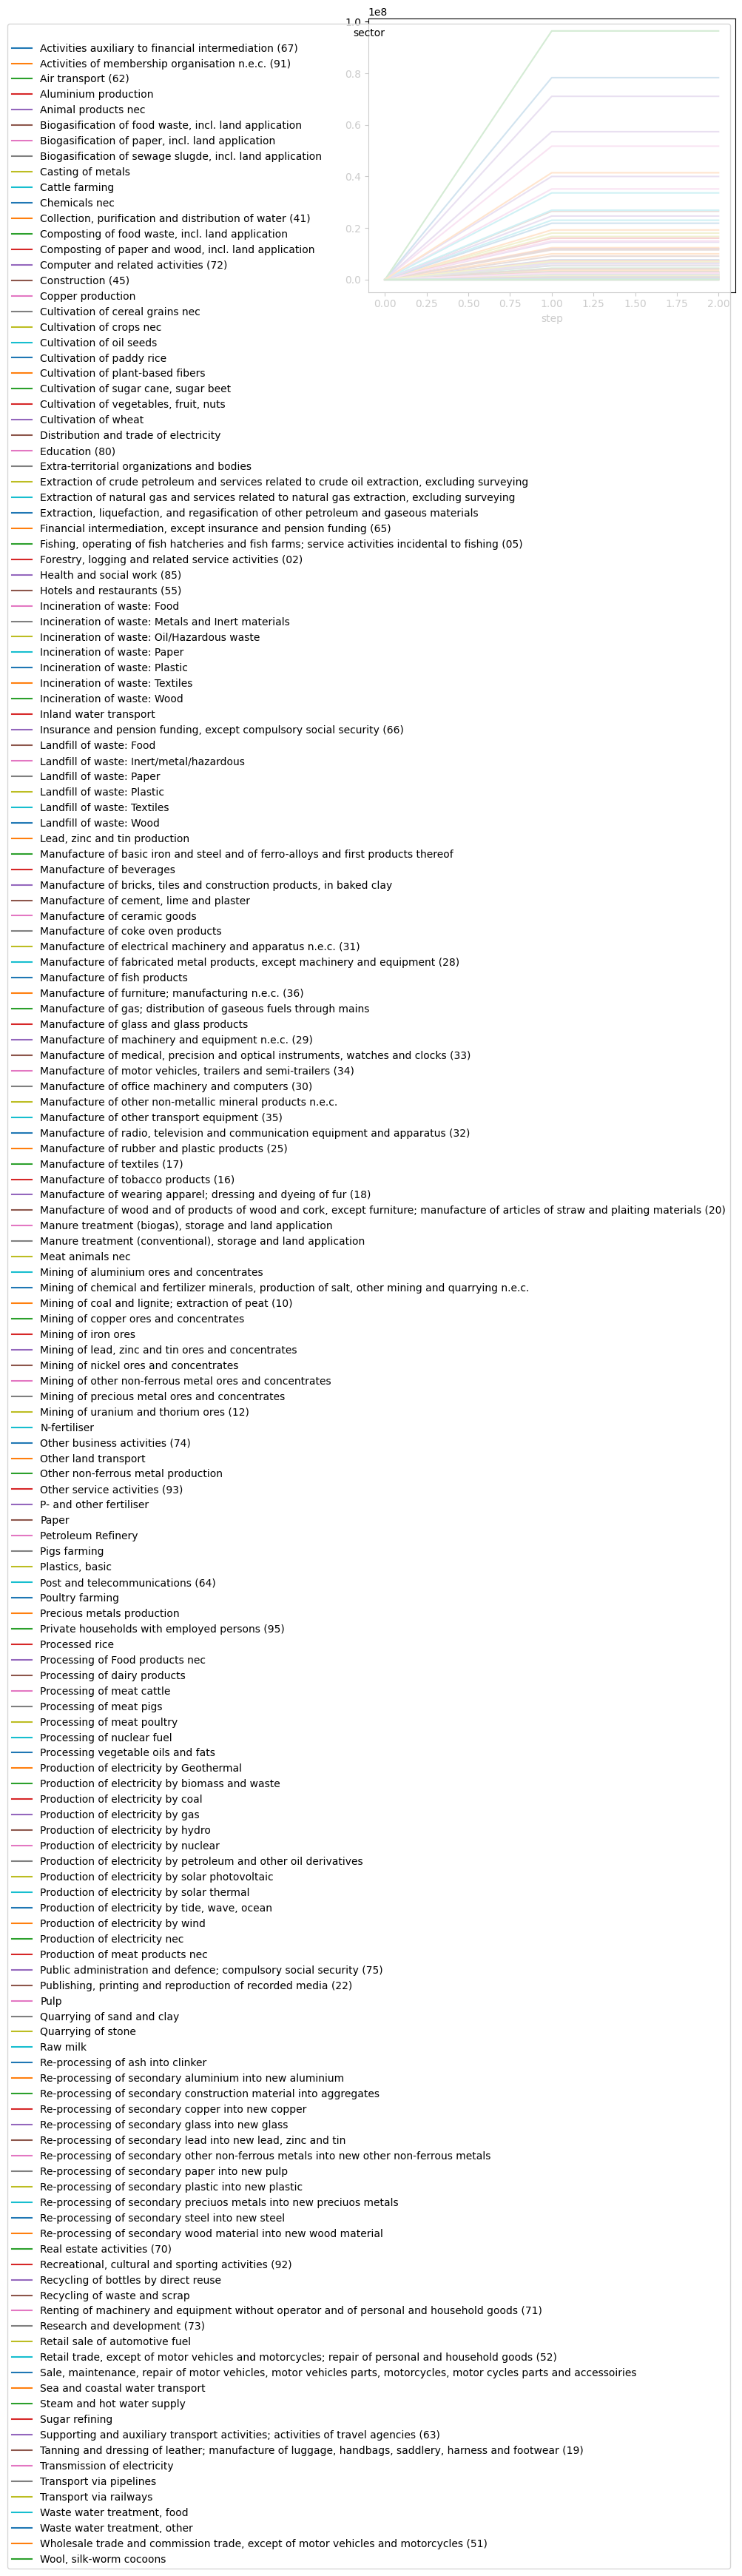

In [9]:
sim.productive_capital_to_recover.loc[:2,"DE"].plot()

In [10]:
sim.model.k_stock[sim.model.productive_capital_lost>0]

array([5.90938876e+04, 2.50466099e+04, 4.48671626e+03, 3.59297414e+02,
       5.58001969e+02, 6.36738865e+01, 2.82638305e+03, 1.15330068e+04,
       2.68461139e+03, 7.22942153e+03, 2.24553277e+04, 1.56462723e+03,
       2.03174382e+01, 1.17499355e+05, 5.81799086e+03, 6.41008526e+03,
       4.37549488e+03, 3.55522899e+03, 1.04744425e+03, 1.30608086e+04,
       5.75840612e+03, 3.67642128e+04, 2.09516886e+05, 1.97941154e+03,
       9.04710766e+03, 1.16852772e+01, 2.87796841e+05, 6.43627309e+04,
       2.04672217e+03, 3.40495317e+03, 2.71622770e+03, 2.84943764e+03,
       2.83662222e+03, 4.95971455e+02, 1.76171850e+03, 2.53314325e+03,
       8.36033609e+04, 1.34822195e+01, 6.70109472e+02, 4.86819058e+01,
       4.50078830e+01, 2.46208008e+01, 6.80712830e+01, 4.18508345e+04,
       5.98817044e+03, 2.04362613e+03, 1.15856150e+04, 4.41843531e+03,
       5.21145054e+01, 5.47892146e+04, 9.32171540e+04, 3.99311011e+02,
       3.96023940e+04, 2.67616310e+04, 3.65125309e+03, 1.21453651e+05,
      

In [13]:
sim.model.productive_capital_lost[sim.model.productive_capital_lost>0]

array([5.33117128e+06, 1.23109362e+07, 7.35768229e+05, 6.08631035e+04,
       1.37412856e+05, 1.56848956e+04, 6.95877222e+05, 1.89199553e+06,
       4.54755442e+05, 1.18604710e+06, 3.68089048e+06, 3.85249611e+05,
       5.00329200e+03, 1.44637514e+07, 9.52838972e+05, 1.08648708e+06,
       7.41981015e+05, 6.02455441e+05, 1.77527854e+05, 2.21572015e+06,
       9.75328191e+05, 9.05101355e+06, 5.15886734e+07, 1.90149741e+05,
       8.72844953e+05, 1.11716415e+03, 7.08364291e+07, 2.63938503e+07,
       5.03988236e+05, 8.38323984e+05, 6.68757628e+05, 7.01546114e+05,
       6.98400306e+05, 1.22136702e+05, 4.33830777e+05, 4.98433562e+05,
       7.54669922e+06, 3.31312985e+03, 1.64993706e+05, 1.19815956e+04,
       1.10804455e+04, 6.06209650e+03, 1.11680288e+04, 6.84412359e+06,
       2.10447714e+06, 5.02818491e+05, 2.85202483e+06, 1.08643233e+06,
       8.49889225e+03, 1.79707312e+07, 2.29304388e+07, 1.40295044e+05,
       6.49244329e+06, 4.39311003e+06, 8.98335223e+05, 3.98117990e+07,
      

In [ ]:
pd.DataFrame(event.Z_distrib, index=sim.model.industries, columns=sim.model.industries).sum(axis=0)

In [ ]:
import numpy as np
np.outer(
            event.rebuilding_sectors_shares, event._regional_sectoral_kapital_destroyed_0
        ).sum()

In [ ]:
sim.next_step()

In [ ]:
pd.Series(event.rebuilding_sectors_shares, index=sim.model.industries).loc['DEU']

In [ ]:
(sim.production_capacity.loc[:4,("DEU",slice(None))].sum(axis=1)/sim.production_capacity.loc[0,("DEU",slice(None))].sum()).plot()

In [ ]:
(sim.production_capacity.loc[:4,("DEU",slice(None))].sum(axis=1)/sim.production_capacity.loc[0,("DEU",slice(None))].sum()).plot()

In [ ]:
(sim.kapital_to_recover.loc[:15,("DEU",slice(None))].sum(axis=1)).plot()

In [ ]:
sim.rebuild_demand.loc[:15,("DEU",slice(None))].sum(axis=1).plot()

In [ ]:
sim2.all_events[0].remaining_kapital_destroyed

In [ ]:
test = pd.read_csv("../BoARIO-Sensitivity/config/exiobase3_full_sectors.csv", index_col=0, decimal=".")
agg = pd.read_excel(
    "../BoARIO-Sensitivity/config/exiobase3_to_other_mrio_sectors.ods", sheet_name=0, index_col="Exiobase3 full sectors"
)

In [ ]:

agg.join(test, how="left")[
        [
            "Eora sectors",
            "affected",
            "rebuilding_factor",
            "inventory_size",
            "kapital_to_va_ratio",
            "inventory_tau",
        ]
    ]


In [ ]:
test.loc["Recreational, cultural and sporting activities (92)"]

In [ ]:
agg.loc["Other service activities (93)"]

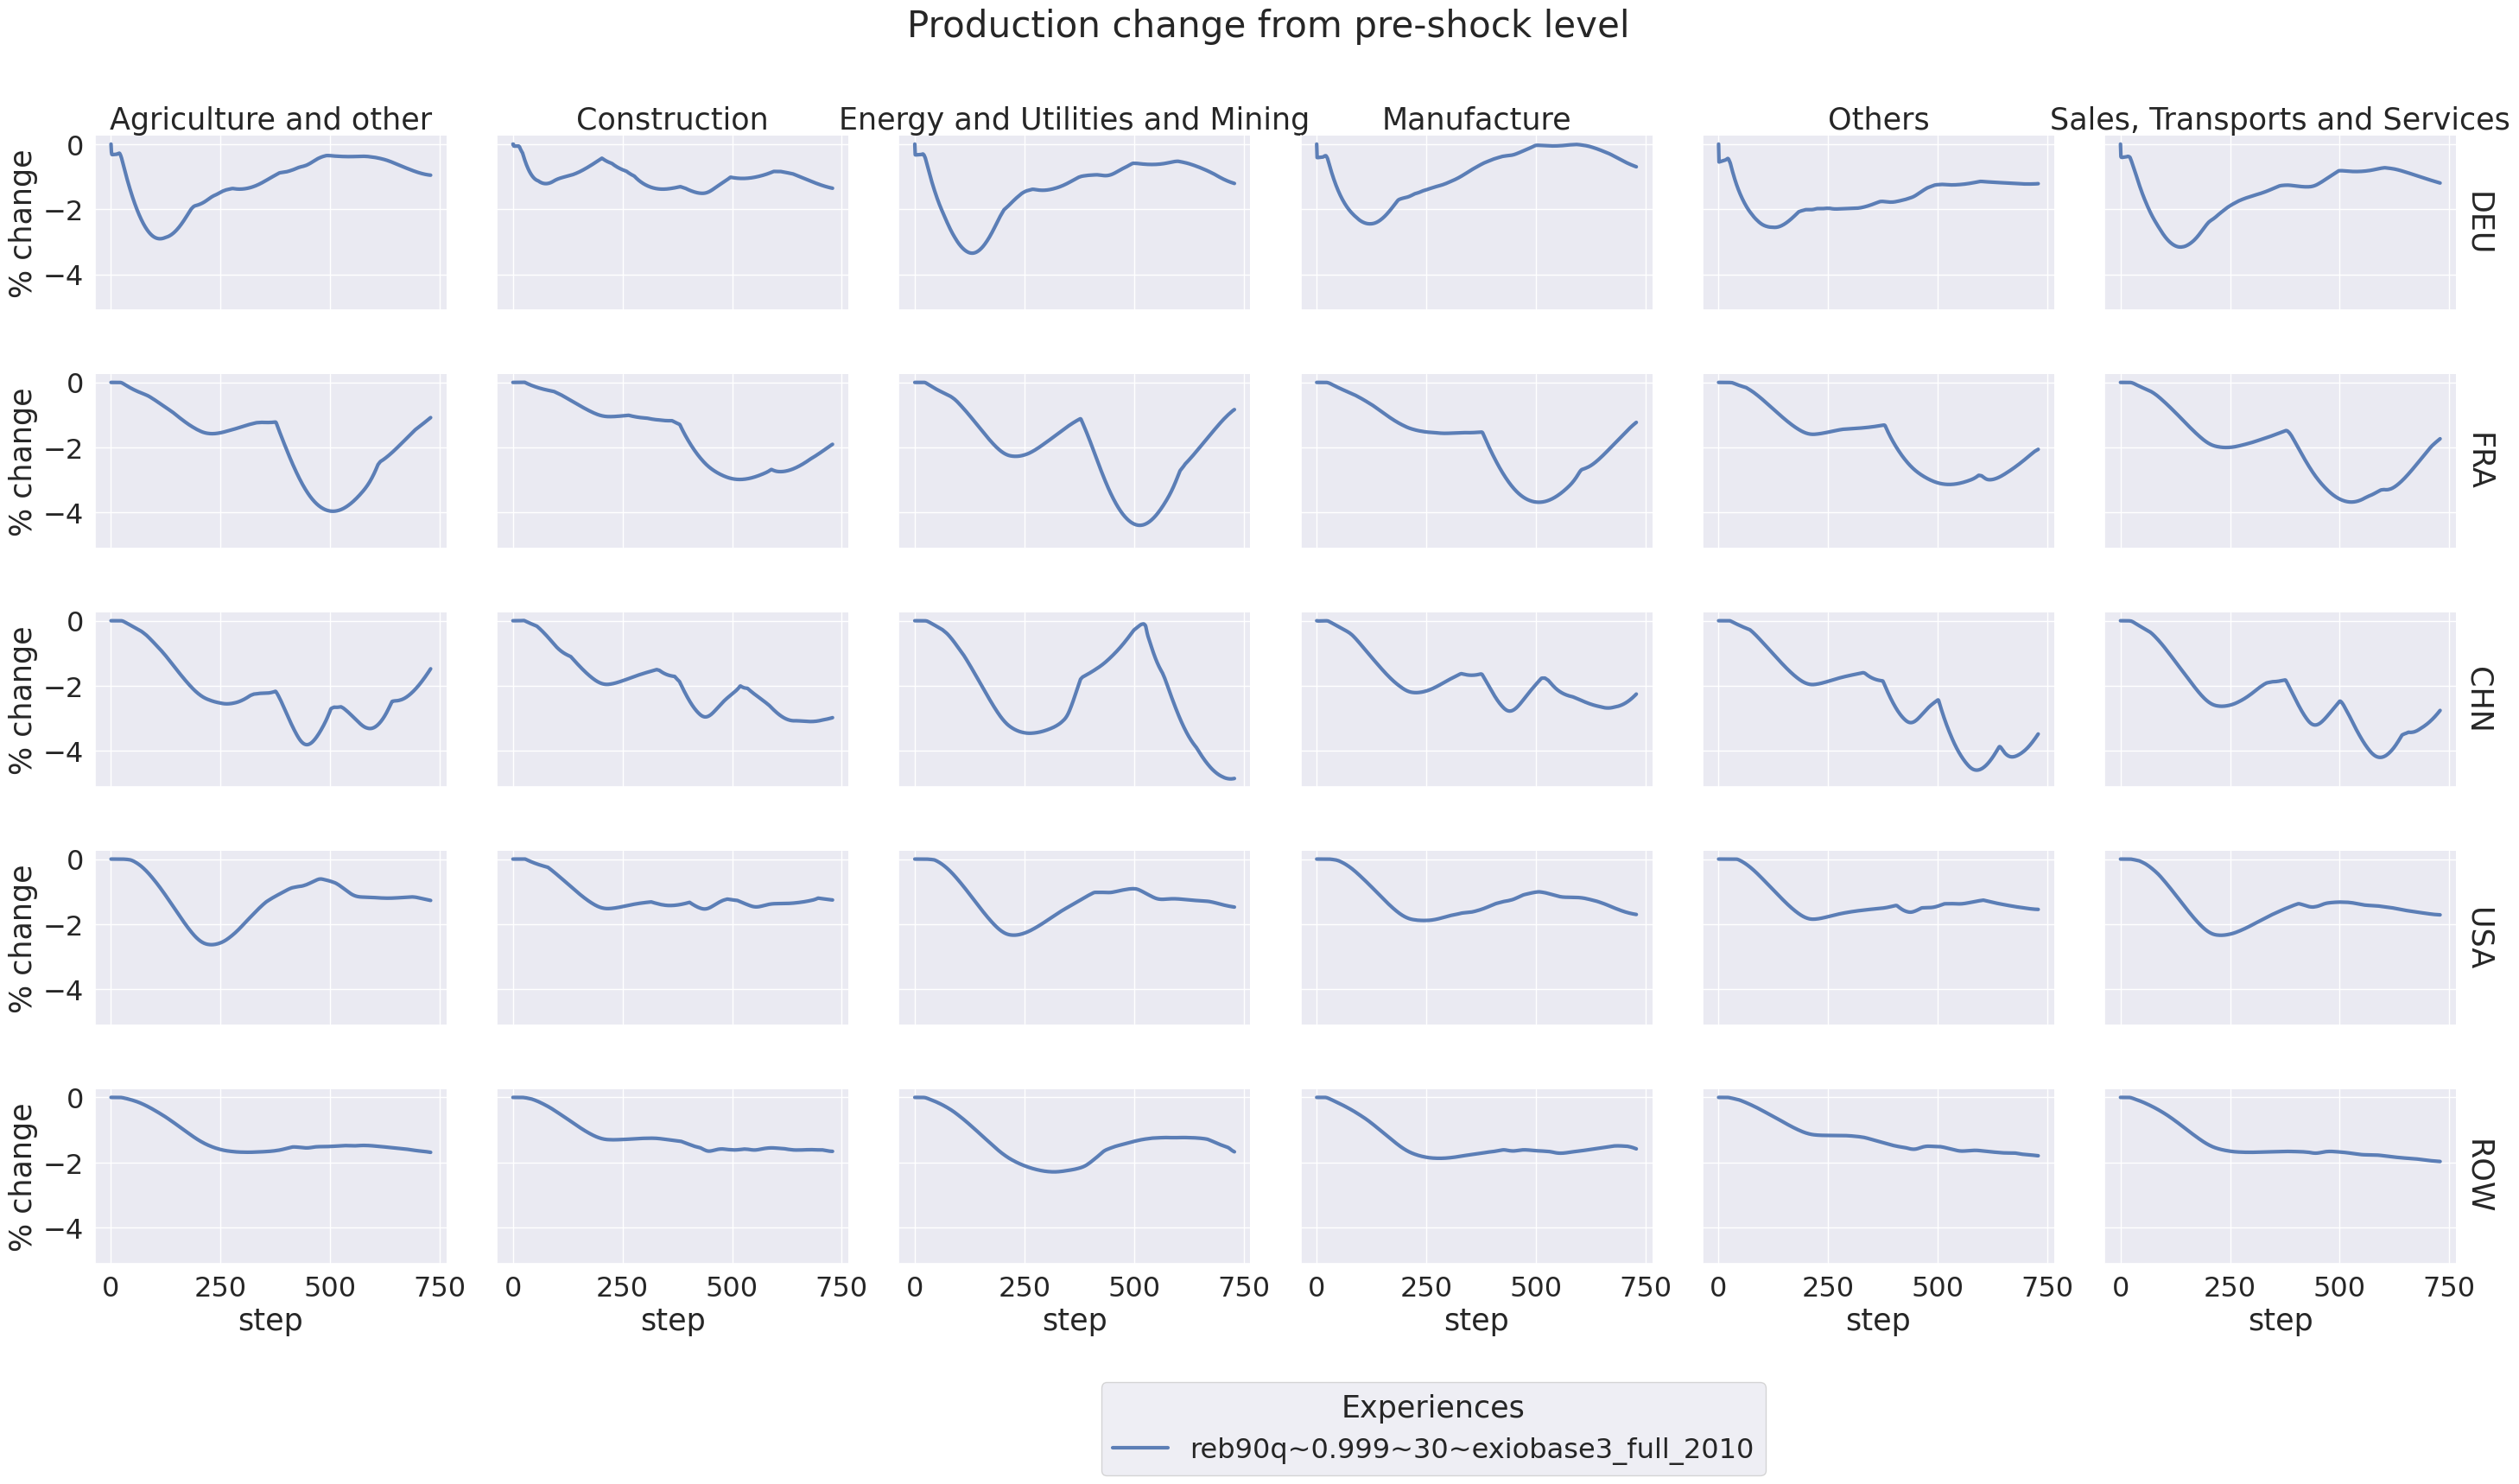

In [5]:
import sys, os
import logging, traceback
import pandas as pd
import seaborn as sns
import numpy as np
import re

import yaml

with open('../BoARIO-Sensitivity/config/config.yaml') as f:
    snakemake_conf = yaml.safe_load(stream=f.read())


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())

sns.set_theme()
sns.set_context(snakemake_conf["plot config"].get("sns context", "paper"))
sns.set(font_scale=2.1)

variable_name = snakemake_conf["plot config"]["plot variable name mapping"]

def make_selection(df, selection):
    selection_lists = {
        key: [value] if isinstance(value, str) else value
        for key, value in selection.items()
    }
    qry = " and ".join(["{} == {}".format(k, v) for k, v in selection_lists.items()])
    return df.query(qry)


def make_exclusion(df, exclusion):
    exclusion_lists = {
        key: [value] if isinstance(value, str) else value
        for key, value in exclusion.items()
    }
    qry = " and ".join(["{} != {}".format(k, v) for k, v in exclusion_lists.items()])
    return df.query(qry)


def plot_variable_grid(
    plot_df,
    variable,
    selection={},
    exclusion=None,
    plot_type="classic",
    hue="Experience",
    col="sector",
    row="region",
    sharey=True,
    row_order=None,
    aspect=1.7,
    output=None,
    col_wrap=None
):
    selection["variable"] = variable  # if isinstance(variable, list) else [variable]
    df_to_plot = make_selection(plot_df, selection)
    if exclusion:
        df_to_plot = make_exclusion(plot_df, exclusion)
    # df_to_plot = subselect_var(plot_df, variable)

    if plot_type == "cumsum":
        y = "value_cumsum_pct"
    else:
        y = "value_pct"

    grid = sns.FacetGrid(
        data=df_to_plot,
        col=col,
        row=row,
        margin_titles=True,
        sharey=sharey,
        hue=hue,
        row_order=row_order,
        aspect=aspect,
        col_wrap=col_wrap,
    )
    grid.map_dataframe(sns.lineplot, x="step", y=y, linewidth=3, alpha=0.9)
    grid.add_legend()
    grid.set_axis_labels(y_var="% change")
    grid.set_titles(row_template="{row_name}", col_template="{col_name}")
    # grid.fig.subplots_adjust(top=0.90)  # adjust the Figure in rp
    grid.fig.suptitle(
        f"{variable_name[variable].capitalize()} change from pre-shock level",
        y=1.05,
        x=0.4,
    )
    sns.move_legend(
        grid.fig,
        "upper center",
        bbox_to_anchor=(0.45, 0.0),
        ncol=4,
        title="Experiences",
        frameon=True,
    )
    if output:
        if isinstance(output, str):
            grid.savefig(output)
        elif isinstance(output, list):
            for out in output:
                grid.savefig(out)
        else:
            raise ValueError(f"output ({output}) should be a list or a str")
    return grid


plot_df = pd.read_parquet("../BoARIO-Sensitivity/results/general-plot_df-all_sim.parquet")


selection={"mean_impact_class":"2L1_5"}
variable="production_realised"
faceting="sectorXregion~Experience"
plot_type="general"

facet_re = re.compile(r"^(?P<facet_col>[^X\n]+)(X(?P<facet_row>\S+))?~(?P<facet_hue>\S+)$")
match = facet_re.match(faceting)
if not match:
    raise ValueError(f"{faceting} does not correspond to a valid possible faceting")

if not match["facet_row"]:
    col_wrap=3
else:
    col_wrap=None

if match["facet_row"]=="region":
    row_order=snakemake_conf["plot config"]["grid"]["row order"]
else:
    row_order=None

#sharey=snakemake_conf["plot config"]["gr"]

fig = plot_variable_grid(
    plot_df,
    variable=variable,
    selection=selection,
    exclusion=None,
    plot_type=plot_type,
    hue=match["facet_hue"],
    col=match["facet_col"],
    row=match["facet_row"],
    sharey=True,
    row_order=row_order,
    aspect=1.7,
    output=None,
    col_wrap=col_wrap
    )


In [13]:
import plotly.tools as tls

plotly_fig = tls.mpl_to_plotly(fig.fig)

AttributeError: 'PolyCollection' object has no attribute 'get_offset_position'

In [14]:
fig.data

variable region                          sector  step  \
5       production_realised    CHN           Agriculture and other     0   
11      production_realised    CHN           Agriculture and other     1   
17      production_realised    CHN           Agriculture and other     2   
23      production_realised    CHN           Agriculture and other     3   
29      production_realised    CHN           Agriculture and other     4   
...                     ...    ...                             ...   ...   
131375  production_realised    USA  Sales, Transports and Services   725   
131381  production_realised    USA  Sales, Transports and Services   726   
131387  production_realised    USA  Sales, Transports and Services   727   
131393  production_realised    USA  Sales, Transports and Services   728   
131399  production_realised    USA  Sales, Transports and Services   729   

               value                           Experience     value_pct  \
5          22.597567  reb90q~0.999~30~exiobase3_full_2010  0.000000e+00   
11         22.597567  reb90q~0.999~30~exiobase3_full_2010 -1.131960e-12   
17         22.597516  reb90q~0.999~30~exiobase3_full_2010 -2.260100e-04   
23         22.597461  reb90q~0.999~30~exiobase3_full_2010 -4.711018e-04   
29         22.597436  reb90q~0.999~30~exiobase3_full_2010 -5.813867e-04   
...              ...                                  ...           ...   
131375  32412.574080  reb90q~0.999~30~exiobase3_full_2010 -1.710115e+00   
131381  32412.348596  reb90q~0.999~30~exiobase3_full_2010 -1.710799e+00   
131387  32412.095037  reb90q~0.999~30~exiobase3_full_2010 -1.711568e+00   
131393  32411.806446  reb90q~0.999~30~exiobase3_full_2010 -1.712443e+00   
131399  32411.536138  reb90q~0.999~30~exiobase3_full_2010 -1.713263e+00   

        value_cumsum_pct  max_neg_impact_value_pct max_neg_impact_class  \
5           0.000000e+00                 -4.858254                  5L2   
11         -3.101260e-15                 -4.858254                  5L2   
17         -6.192056e-07                 -4.858254                  5L2   
23         -1.909895e-06                 -4.858254                  5L2   
29         -3.502736e-06                 -4.858254                  5L2   
...                  ...                       ...                  ...   
131375     -2.851135e+00                 -4.858254                  5L2   
131381     -2.855822e+00                 -4.858254                  5L2   
131387     -2.860511e+00                 -4.858254                  5L2   
131393     -2.865203e+00                 -4.858254                  5L2   
131399     -2.869896e+00                 -4.858254                  5L2   

        max_pos_impact_value_pct max_pos_impact_class  mean_impact_value_pct  \
5                       0.006652                  0G2              -1.568823   
11                      0.006652                  0G2              -1.568823   
17                      0.006652                  0G2              -1.568823   
23                      0.006652                  0G2              -1.568823   
29                      0.006652                  0G2              -1.568823   
...                          ...                  ...                    ...   
131375                  0.006652                  0G2              -1.568823   
131381                  0.006652                  0G2              -1.568823   
131387                  0.006652                  0G2              -1.568823   
131393                  0.006652                  0G2              -1.568823   
131399                  0.006652                  0G2              -1.568823   

       mean_impact_class  
5                  2L1_5  
11                 2L1_5  
17                 2L1_5  
23                 2L1_5  
29                 2L1_5  
...                  ...  
131375             2L1_5  
131381             2L1_5  
131387             2L1_5  
131393             2L1_5  
131399             2L1_5  

[21900 rows x 14 c

# New plots

In [12]:
import matplotlib.ticker as mtick

region = "DEU"

df_flood_readable = pd.read_csv("../BoARIO-Sensitivity/config/flood_scenarios_readable.csv")
df = pd.read_parquet("../BoARIO-Sensitivity/results/general-plot_df.parquet")
df = df.loc[df.region==region]
df[["rsce","psi","alpha_tau","mrio"]] = df.Experience.str.split("~",expand=True)

In [14]:
df.rsce.unique()

array(['reclin6M', 'reclin1Y', 'reclin1_5Y', 'reb3M', 'reb6M', 'reb1Y',
       'reb1_5Y', 'reb2Y'], dtype=object)

In [4]:
#df = df.loc[(df.psi=="0.8") & (df.alpha_tau=="365") & (df.mrio.str.contains("2010"))]
df = df[['rsce', 'psi', 'alpha_tau', 'mrio', 'sector', 'step', 'value', 'value_pct', 'value_cumsum_pct', 'cumsum_impact_class']].copy()

In [5]:
#df = df.set_index("mrio").join(df_flood_readable[["MRIOT","impact"]].set_index("MRIOT")).reset_index()
df["value_diff"] = df.groupby(["mrio","rsce","psi", "alpha_tau", "sector"])["value"].progress_transform(lambda x : x - x.iloc[0])
#df = df[["step","value_diff","Experience","mrio","recovery_sce","cumsum_impact_class"]]
df = df.merge(df_flood_readable[["MRIOT","impact"]], how="left", left_on="mrio", right_on="MRIOT")
df["value_imp"] = (df["value_diff"] / df["impact"]) * 100
df[["rectype","length"]] = df.rsce.str.extract(re.compile("(?P<rectype>reb|rec(?:lin|S))(?P<length>\d.*)$"))

tmp = df.groupby(['mrio', 'rsce', 'rectype', 'length', 'psi', 'alpha_tau', 'step'], as_index=False)[['value', 'value_pct', 'value_cumsum_pct', 'value_diff', 'value_imp']].sum()
tmp[['value_pct', 'value_cumsum_pct']] = tmp[['value_pct', 'value_cumsum_pct']] / 6
tmp["sector"] = "all"

df=df[['mrio', 'rsce', 'rectype', 'length', 'psi', 'alpha_tau', 'step', 'sector', 'value', 'value_pct', 'value_cumsum_pct', 'value_diff', 'value_imp']].copy()
df = pd.concat([df,tmp])

  0%|          | 0/6912 [00:00<?, ?it/s]

In [6]:
df["value_imp_c"] = df.groupby(["mrio","rsce","psi", "alpha_tau", "sector"])["value_imp"].transform("cumsum")

In [7]:
from scipy.signal import find_peaks

def func(x):
    return(len(find_peaks(-x, prominence=10**-4)[0]))

df["n_peaks"] = df.groupby(["mrio","rsce","psi", "alpha_tau", "sector"])['value_pct'].transform(func)

In [8]:
df_plot1 = df.loc[df.step==df.step.max()//2].copy()
df_plot1["time_looked"] = "1y"
df_plot2 = df.loc[df.step==df.step.max()].copy()
df_plot2["time_looked"] = "2y"

In [9]:
df_plot = pd.concat([df_plot1,df_plot2])

In [10]:
df_plot = df_plot[['mrio', 'rsce', 'rectype', 'length', 'psi', 'alpha_tau', 'time_looked', 'sector','value', 'value_pct', 'value_cumsum_pct', 'value_diff', 'value_imp', 'value_imp_c', "n_peaks"]].copy()
df_plot

mrio        rsce rectype length   psi alpha_tau   
419328     eora26_full_2000    reclin6M  reclin     6M   0.5        90  \
419329     eora26_full_2000    reclin1Y  reclin     1Y   0.5        90   
419330     eora26_full_2000  reclin1_5Y  reclin   1_5Y   0.5        90   
419331     eora26_full_2000       reb3M     reb     3M   0.5        90   
419332     eora26_full_2000       reb6M     reb     6M   0.5        90   
...                     ...         ...     ...    ...   ...       ...   
838039  exiobase3_full_2010    reclin6M  reclin     6M  0.95        90   
838769  exiobase3_full_2010    reclin6M  reclin     6M  0.97       180   
839499  exiobase3_full_2010    reclin6M  reclin     6M  0.97       365   
840229  exiobase3_full_2010    reclin6M  reclin     6M  0.97       530   
840959  exiobase3_full_2010    reclin6M  reclin     6M  0.97        90   

       time_looked                 sector          value  value_pct   
419328          1y  Agriculture and other    2932.157557  -0.000234  \
419329          1y  Agriculture and other    2932.191185   0.000913   
419330          1y  Agriculture and other    2932.191302   0.000917   
419331          1y  Agriculture and other    2932.205370   0.001397   
419332          1y  Agriculture and other    2932.281682   0.003999   
...            ...                    ...            ...        ...   
838039          2y                    all  187976.087652  -0.000332   
838769          2y                    all  187976.508582  -0.000180   
839499          2y                    all  187976.789725  -0.000071   
840229          2y                    all  187976.952060  -0.000006   
840959          2y                    all  187976.087652  -0.000332   

        value_cumsum_pct  value_diff  value_imp  value_imp_c  n_peaks  
419328         -0.000087   -0.006855  -0.000038    -0.005157        1  
419329         -0.000015    0.026772   0.000148    -0.000905        1  
419330         -0.000070    0.026890   0.000149    -0.004154        1  
419331          0.001824    0.040958   0.000227     0.108002        1  
419332          0.001358    0.117270   0.000649     0.080406        1  
...                  ...         ...        ...          ...      ...  
838039         -0.000153   -0.930108  -0.003913    -0.389713        1  
838769         -0.000032   -0.509178  -0.002142     0.189490        1  
839499         -0.000001   -0.228036  -0.000959     0.357784        1  
840229         -0.000018   -0.065700  -0.000276     0.315701        1  
840959         -0.000153   -0.930108  -0.003913    -0.389713        1  

[16128 rows x 15 columns]

In [11]:
absurd_set = df_plot[(df_plot.sector=="all") & (df_plot.value_imp_c < -500)].loc[:,["rsce","psi","alpha_tau"]]
i2=absurd_set.set_index(["rsce","psi","alpha_tau"]).index
i1=df_plot.set_index(["rsce","psi","alpha_tau"]).index
df_plot.loc[i1.isin(i2),"absurd"] = True

In [12]:
df_plot.loc[~i1.isin(i2),"absurd"] = False
df_plot

mrio        rsce rectype length   psi alpha_tau   
419328     eora26_full_2000    reclin6M  reclin     6M   0.5        90  \
419329     eora26_full_2000    reclin1Y  reclin     1Y   0.5        90   
419330     eora26_full_2000  reclin1_5Y  reclin   1_5Y   0.5        90   
419331     eora26_full_2000       reb3M     reb     3M   0.5        90   
419332     eora26_full_2000       reb6M     reb     6M   0.5        90   
...                     ...         ...     ...    ...   ...       ...   
838039  exiobase3_full_2010    reclin6M  reclin     6M  0.95        90   
838769  exiobase3_full_2010    reclin6M  reclin     6M  0.97       180   
839499  exiobase3_full_2010    reclin6M  reclin     6M  0.97       365   
840229  exiobase3_full_2010    reclin6M  reclin     6M  0.97       530   
840959  exiobase3_full_2010    reclin6M  reclin     6M  0.97        90   

       time_looked                 sector          value  value_pct   
419328          1y  Agriculture and other    2932.157557  -0.000234  \
419329          1y  Agriculture and other    2932.191185   0.000913   
419330          1y  Agriculture and other    2932.191302   0.000917   
419331          1y  Agriculture and other    2932.205370   0.001397   
419332          1y  Agriculture and other    2932.281682   0.003999   
...            ...                    ...            ...        ...   
838039          2y                    all  187976.087652  -0.000332   
838769          2y                    all  187976.508582  -0.000180   
839499          2y                    all  187976.789725  -0.000071   
840229          2y                    all  187976.952060  -0.000006   
840959          2y                    all  187976.087652  -0.000332   

        value_cumsum_pct  value_diff  value_imp  value_imp_c  n_peaks absurd  
419328         -0.000087   -0.006855  -0.000038    -0.005157        1  False  
419329         -0.000015    0.026772   0.000148    -0.000905        1  False  
419330         -0.000070    0.026890   0.000149    -0.004154        1  False  
419331          0.001824    0.040958   0.000227     0.108002        1  False  
419332          0.001358    0.117270   0.000649     0.080406        1  False  
...                  ...         ...        ...          ...      ...    ...  
838039         -0.000153   -0.930108  -0.003913    -0.389713        1  False  
838769         -0.000032   -0.509178  -0.002142     0.189490        1  False  
839499         -0.000001   -0.228036  -0.000959     0.357784        1  False  
840229         -0.000018   -0.065700  -0.000276     0.315701        1  False  
840959         -0.000153   -0.930108  -0.003913    -0.389713        1  False  

[16128 rows x 16 columns]

In [13]:
df_plot.to_parquet(f"./parquets_cache/sensitivity_full_sims_{region}_plot_df.parquet")

In [14]:
test = df.copy()

In [15]:
test["xp"] = test["mrio"] + test["rsce"] + test["psi"] + test["alpha_tau"]

In [16]:
test['shortage'] = test['n_peaks'] > 1

<AxesSubplot: xlabel='step', ylabel='value_cumsum_pct'>

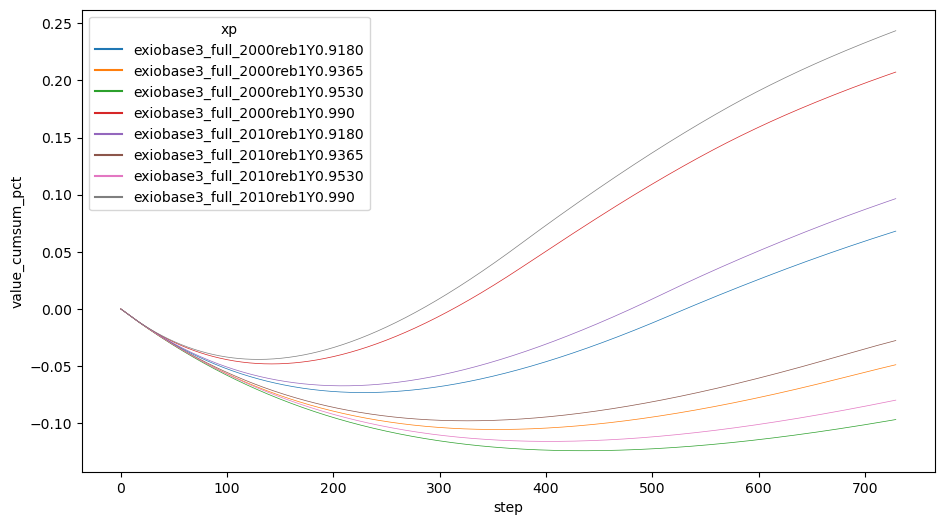

In [209]:
tmp = test.loc[(test.n_peaks==1) & (test.sector=="all") & (test.mrio.str.contains("exiobase")) & (test.rsce.str.contains("reb")) & (test.rsce.str.contains("1Y")) & (test.psi=="0.9")].copy()
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=tmp, x='step', y='value_cumsum_pct', units=tmp.xp+tmp.sector, ax=ax,estimator=None, lw=0.5, hue="xp")


<AxesSubplot: xlabel='step', ylabel='value_diff'>

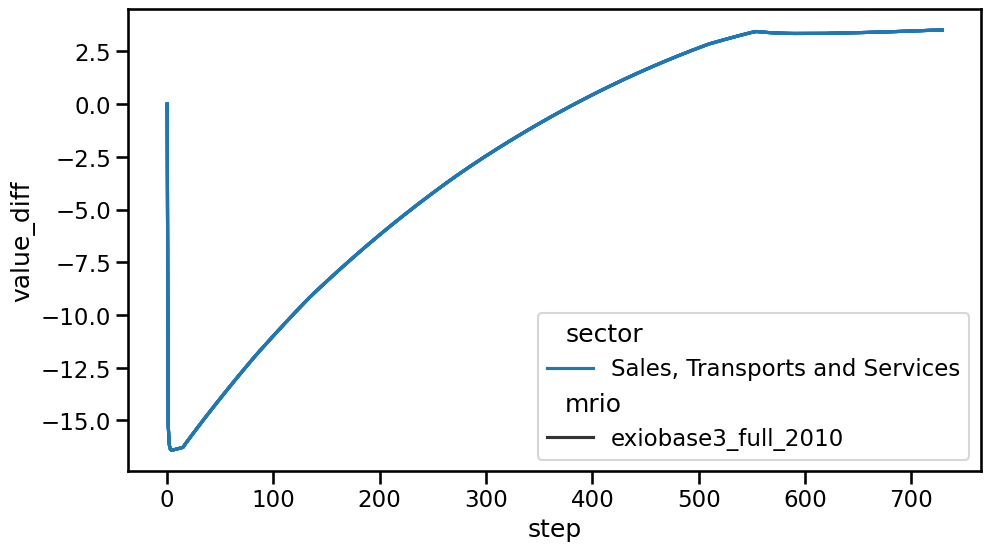

In [335]:
tmp = test.loc[(test.n_peaks==2) & (test.mrio.str.contains("exiobase3_full_2010")) & (test.sector=="Sales, Transports and Services") & (test.length=="1Y")].copy()
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=tmp, x='step', y='value_diff', hue='sector', style="mrio", units=tmp.xp, ax=ax,estimator=None)


In [258]:
sns.set_context("talk")

In [ ]:
#f, ax = plt.subplots(figsize=(16,8))
param_name = 'alpha_tau'
graph = sns.relplot(data=test.loc[(test.n_peaks==1) & (test.sector=="Construction")], x="step",y="value_cumsum_pct",hue=param_name, col="sector", col_wrap=3, kind="line", estimator=None, units=test.mrio+test.rsce+test.psi, lw=0.5)
graph.set(ylabel='Relative change')
graph.figure.suptitle(f"Change in production per sector for different values of {param_name}")
graph.figure.tight_layout()
sns.move_legend(
    graph, loc="upper right", frameon=False, bbox_to_anchor=(1.1,0.7),
)

In [ ]:
#f, ax = plt.subplots(figsize=(16,8))
param_name = 'psi'
graph = sns.relplot(data=test, x="step",y="value_pct",hue="xp", row='psi', col="sector", kind="line", estimator=None, units=test.mrio+test.rsce+test.alpha_tau, lw=0.5, legend=False)
graph.set(ylabel='Relative change')
graph.figure.suptitle(f"Change in production per sector for different values of {param_name}")
graph.figure.tight_layout()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f7ad0a19240> (for post_execute):



KeyboardInterrupt



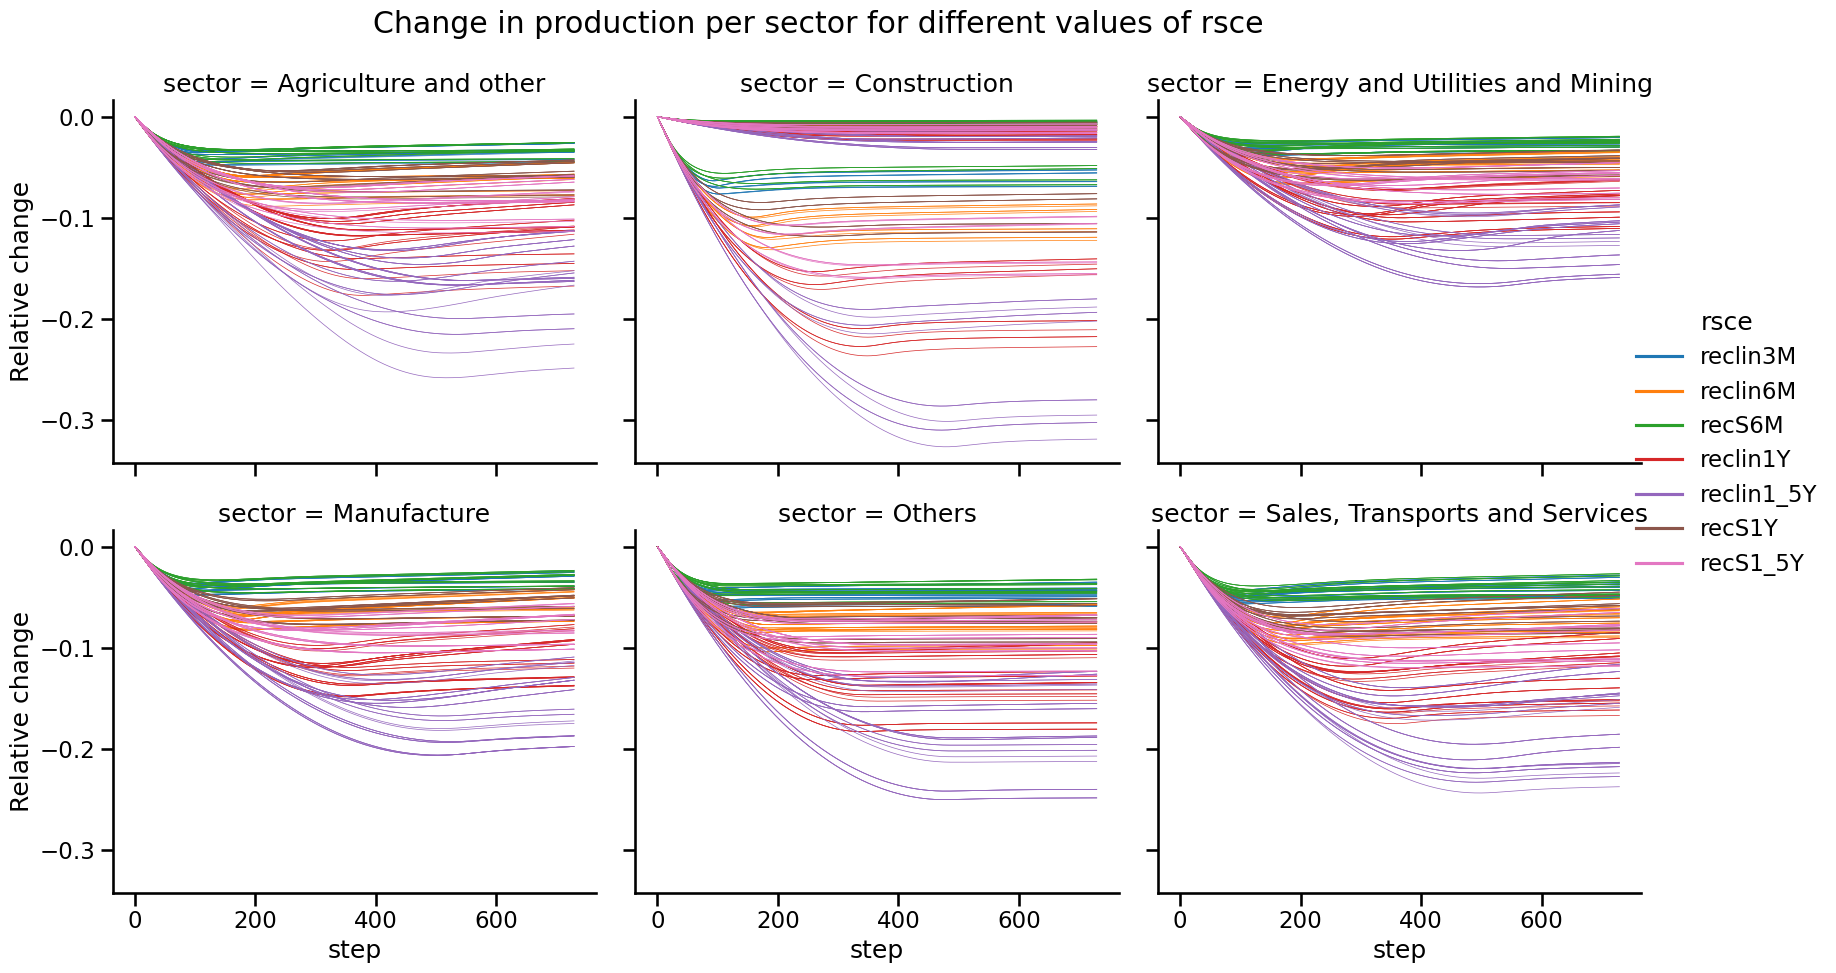

In [96]:
param_name="rsce"
graph = sns.relplot(data=test.loc[test.rsce.str.contains("rec")], x="step",y="value_cumsum_pct",hue=param_name, col="sector", col_wrap=3, kind="line", estimator=None, units=test.mrio+test.psi+test.alpha_tau+test.rectype, lw=0.5)
graph.set(ylabel='Relative change')
graph.figure.suptitle(f"Change in production per sector for different values of {param_name}")
graph.figure.tight_layout()
sns.move_legend(
    graph, loc="upper right", frameon=False, bbox_to_anchor=(1.1,0.7),
)

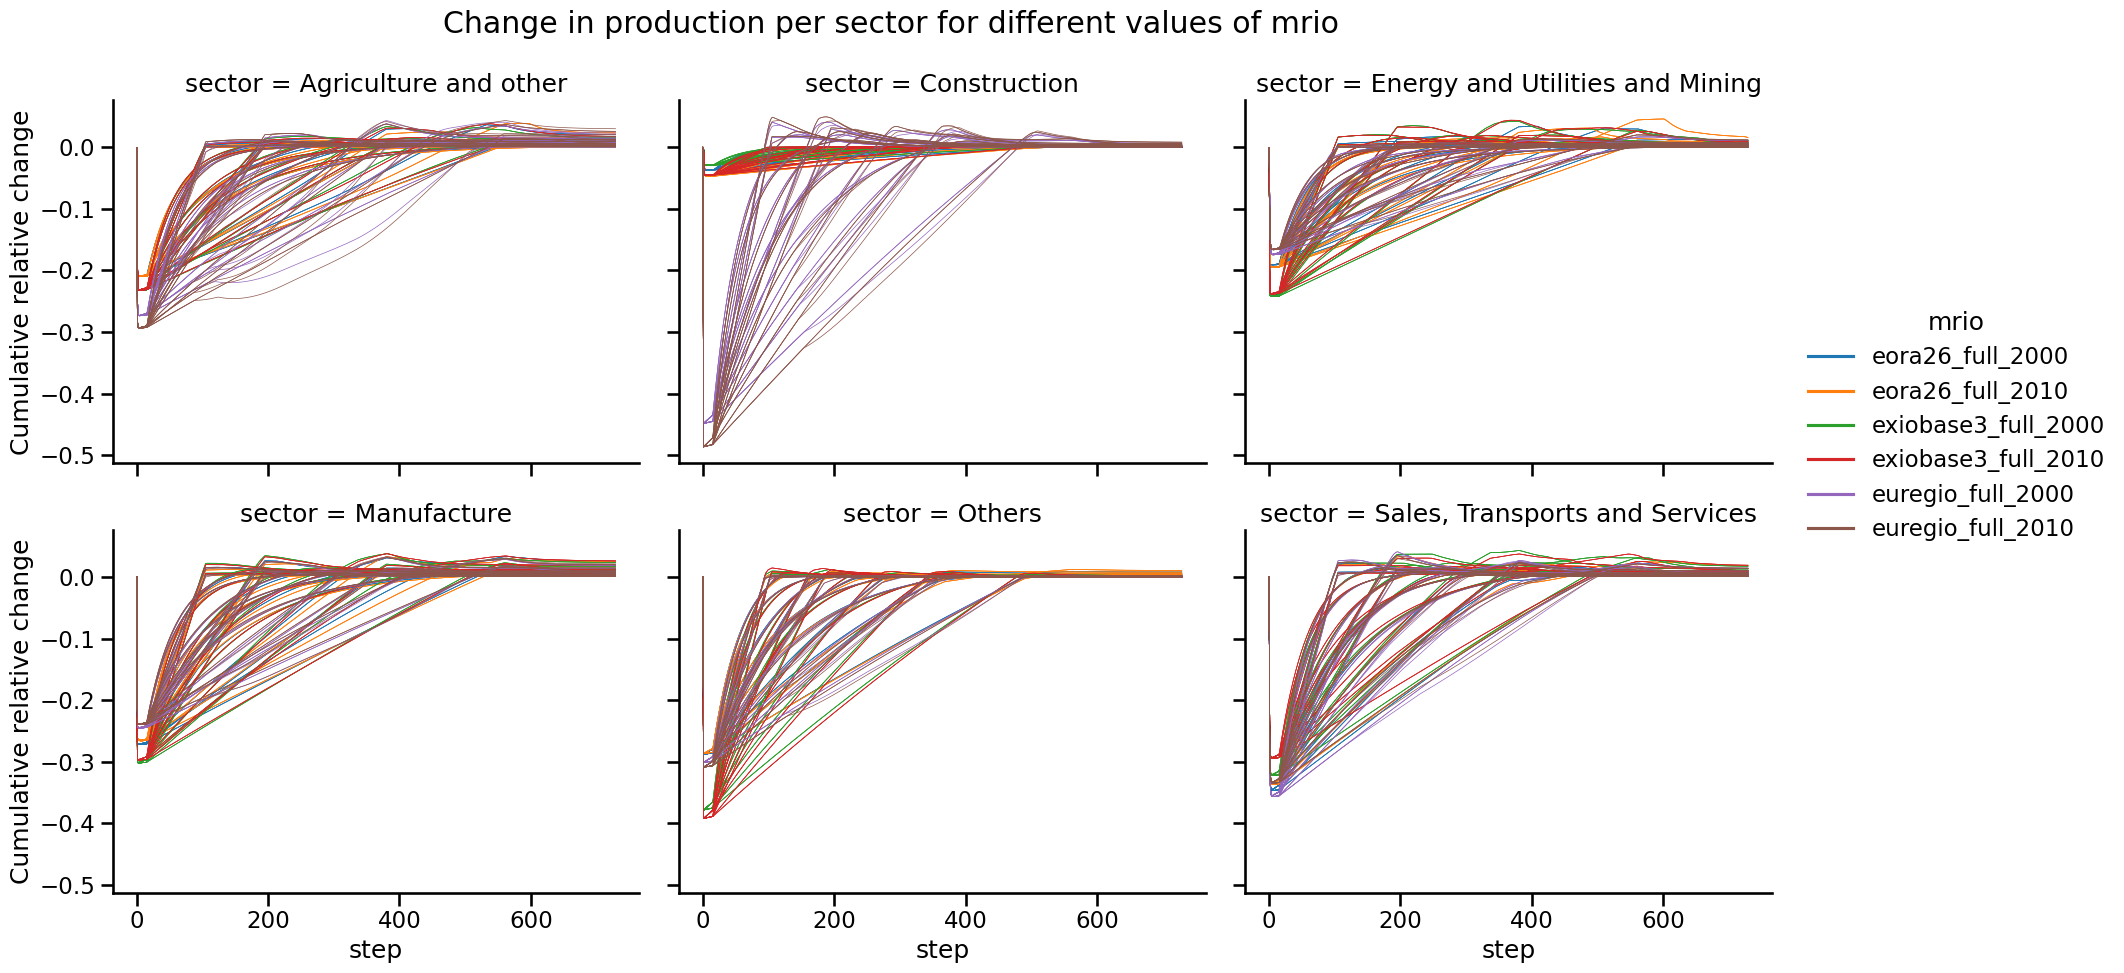

In [99]:
param_name="mrio"
graph = sns.relplot(data=test.loc[test.rsce.str.contains("rec")], x="step",y="value_pct",hue=param_name, col="sector", col_wrap=3, kind="line", estimator=None, units=test.psi+test.alpha_tau+test.rsce, lw=0.5)
graph.set(ylabel='Cumulative relative change')
graph.figure.suptitle(f"Change in production per sector for different values of {param_name}")
graph.figure.tight_layout()
sns.move_legend(
    graph, loc="upper right", frameon=False, bbox_to_anchor=(1.18,0.7),
)

In [237]:
ex_plot_df1 = df.loc[(df["rsce"]=="reb6M") & (df.psi=="0.97") & (df.sector=="Construction")]
ex_plot_df2 = df.loc[(df["rsce"]=="reb6M") & (df.psi=="0.5") & (df.sector=="Construction")]
ex_plot_df1 = ex_plot_df1.sort_values(by=["mrio","rsce","rectype","length","psi","alpha_tau","sector","step"]).iloc[:400]#.plot(x="step",y="value_pct",ax=ax,legend=False)
ex_plot_df2 = ex_plot_df.sort_values(by=["mrio","rsce","rectype","length","psi","alpha_tau","sector","step"]).iloc[:400]#.plot(x="step",y="value_pct",ax=ax,legend=False)

Text(0.5, 1.05, 'Example of shortage vs no shortage')

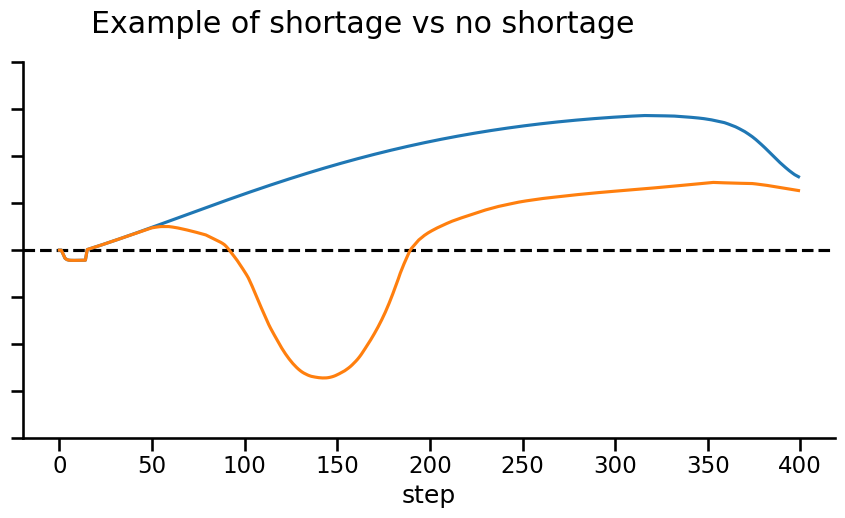

In [248]:
graph = sns.relplot(kind="line",data=pd.concat([ex_plot_df2,ex_plot_df1]), x="step", y="value_pct", hue="psi", aspect=2, legend=False,zorder=2)
graph.map(plt.axhline, y=0, ls="--", color="black",zorder=1)
graph.despine()
graph.set_ylabels("")
graph.set_yticklabels("")
graph.fig.suptitle("Example of shortage vs no shortage",y=1.05)
#graph.tick_params(left=False)

<AxesSubplot: xlabel='step'>

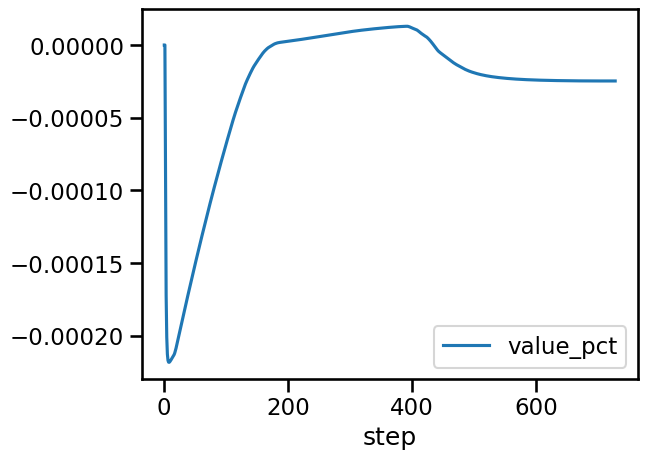

### DEU

In [17]:
region = 'DEU'


plot_df = pd.read_parquet(f"./parquets_cache/sensitivity_full_sims_{region}_plot_df.parquet")

#### Renaming

In [18]:
plot_df.rectype = plot_df.rectype.map({"reclin":"Without rebuilding demand","reb":"With rebuilding demand"})
plot_df.sector = plot_df.sector.replace({"all":"All sectors"})
plot_df["mrio_name"] = plot_df.mrio.replace({
    "eora26_full_2000":"EORA26",
    "exiobase3_full_2000":"EXIOBASE 3",
    "euregio_full_2000":"EUREGIO",
    "eora26_full_2010":"EORA26",
    "exiobase3_full_2010":"EXIOBASE 3",
    "euregio_full_2010":"EUREGIO",
})


plot_df["MRIOT Year"] = plot_df.mrio.replace({
    "eora26_full_2000":"2000",
    "exiobase3_full_2000":"2000",
    "euregio_full_2000":"2000",
    "eora26_full_2010":"2010",
    "exiobase3_full_2010":"2010",
    "euregio_full_2010":"2010",
})

plot_df["mrio_name_full"] = plot_df.mrio.replace({
    "eora26_full_2000":"EORA26 2000",
    "exiobase3_full_2000":"EXIOBASE3 2000",
    "euregio_full_2000":"EUREGIO 2000",
    "eora26_full_2010":"EORA26 2010",
    "exiobase3_full_2010":"EXIOBASE3 2010",
    "euregio_full_2010":"EUREGIO 2010",
})

plot_df["Alpha tau"] = plot_df["alpha_tau"].astype(int)
plot_df["Recovery length (days)"] = plot_df.length.replace({
    "3M":90,
    "6M":180,
    "1Y":365,
    "1_5Y":545,
    "2Y":730,
})

In [4]:
sns.set_context("talk")

#### Param aggregated

In [7]:
plot_df

mrio        rsce                    rectype length  \
419328     eora26_full_2000    reclin6M  Without rebuilding demand     6M   
419329     eora26_full_2000    reclin1Y  Without rebuilding demand     1Y   
419330     eora26_full_2000  reclin1_5Y  Without rebuilding demand   1_5Y   
419331     eora26_full_2000       reb3M     With rebuilding demand     3M   
419332     eora26_full_2000       reb6M     With rebuilding demand     6M   
...                     ...         ...                        ...    ...   
838039  exiobase3_full_2010    reclin6M  Without rebuilding demand     6M   
838769  exiobase3_full_2010    reclin6M  Without rebuilding demand     6M   
839499  exiobase3_full_2010    reclin6M  Without rebuilding demand     6M   
840229  exiobase3_full_2010    reclin6M  Without rebuilding demand     6M   
840959  exiobase3_full_2010    reclin6M  Without rebuilding demand     6M   

         psi alpha_tau time_looked                 sector         value  \
419328   0.5        90          1y  Agriculture and other    125.092265   
419329   0.5        90          1y  Agriculture and other    125.106264   
419330   0.5        90          1y  Agriculture and other    125.023486   
419331   0.5        90          1y  Agriculture and other    125.131441   
419332   0.5        90          1y  Agriculture and other    125.122235   
...      ...       ...         ...                    ...           ...   
838039  0.95        90          2y            All sectors  13023.378404   
838769  0.97       180          2y            All sectors  13022.918515   
839499  0.97       365          2y            All sectors  13022.668990   
840229  0.97       530          2y            All sectors  13022.586882   
840959  0.97        90          2y            All sectors  13023.378404   

        value_pct  ...  value_diff  value_imp  value_imp_c  n_peaks  absurd  \
419328   0.008130  ...    0.010169   0.000056    -0.133134        1   False   
419329   0.019322  ...    0.024168   0.000134    -0.259054        1   False   
419330  -0.046857  ...   -0.058609  -0.000324    -0.339161        1   False   
419331   0.039451  ...    0.049346   0.000273    -0.067094        1   False   
419332   0.032091  ...    0.040140   0.000222    -0.177174        1   False   
...           ...  ...         ...        ...          ...      ...     ...   
838039   0.005326  ...    1.015647   0.004273   -10.076663        1   False   
838769   0.002862  ...    0.555757   0.002338   -12.624241        1   False   
839499   0.001559  ...    0.306233   0.001288   -14.239499        1   False   
840229   0.001188  ...    0.224124   0.000943   -14.822307        1   False   
840959   0.005326  ...    1.015647   0.004273   -10.076663        1   False   

         mrio_name MRIOT Year  mrio_name_full Alpha tau  \
419328      EORA26       2000     EORA26 2000        90   
419329      EORA26       2000     EORA26 2000        90   
419330      EORA26       2000     EORA26 2000        90   
419331      EORA26       2000     EORA26 2000        90   
419332      EORA26       2000     EORA26 2000        90   
...            ...        ...             ...       ...   
838039  EXIOBASE 3       2010  EXIOBASE3 2010        90   
838769  EXIOBASE 3       2010  EXIOBASE3 2010       180   
839499  EXIOBASE 3       2010  EXIOBASE3 2010       365   
840229  EXIOBASE 3       2010  EXIOBASE3 2010       530   
840959  EXIOBASE 3       2010  EXIOBASE3 2010        90   

        Recovery length (days)  
419328                     180  
419329                     365  
419330                     545  
419331                      90  
419332                     180  
...                        ...  
838039                     180  
838769                     180  
839499                     180  
840229                     180  
840959                     180  

[16128 rows x 21 columns]

count       mean        std         min  \
rectype                   mrio_name                                             
With rebuilding demand    EORA26      220.0 -31.140401  52.816995 -281.008968   
                          EUREGIO     220.0 -47.669481  38.402387 -173.105057   
                          EXIOBASE 3  220.0 -11.612085  26.530350  -57.066077   
Without rebuilding demand EORA26      144.0 -26.077161  10.485858  -46.822235   
                          EUREGIO     144.0 -26.308222  10.362045  -48.704000   
                          EXIOBASE 3  144.0 -23.215259   9.310633  -39.528680   

                                            25%        50%        75%  \
rectype                   mrio_name                                     
With rebuilding demand    EORA26     -46.743785 -18.665629  -1.792385   
                          EUREGIO    -66.912078 -44.007629 -18.403686   
                          EXIOBASE 3 -32.164571  -6.133137   9.725783   
Without rebuilding demand EORA26     -32.684686 -26.179803 -16.612858   
                          EUREGIO    -33.942868 -27.388979 -16.103826   
                          EXIOBASE 3 -28.556112 -23.332100 -14.676605   

                                            max  
rectype                   mrio_name              
With rebuilding demand    EORA26      32.428861  
                          EUREGIO     26.057699  
                          EXIOBASE 3  33.803433  
Without rebuilding demand EORA26     -10.699716  
                          EUREGIO    -11.704231  
                          EXIOBASE 3 -10.076663

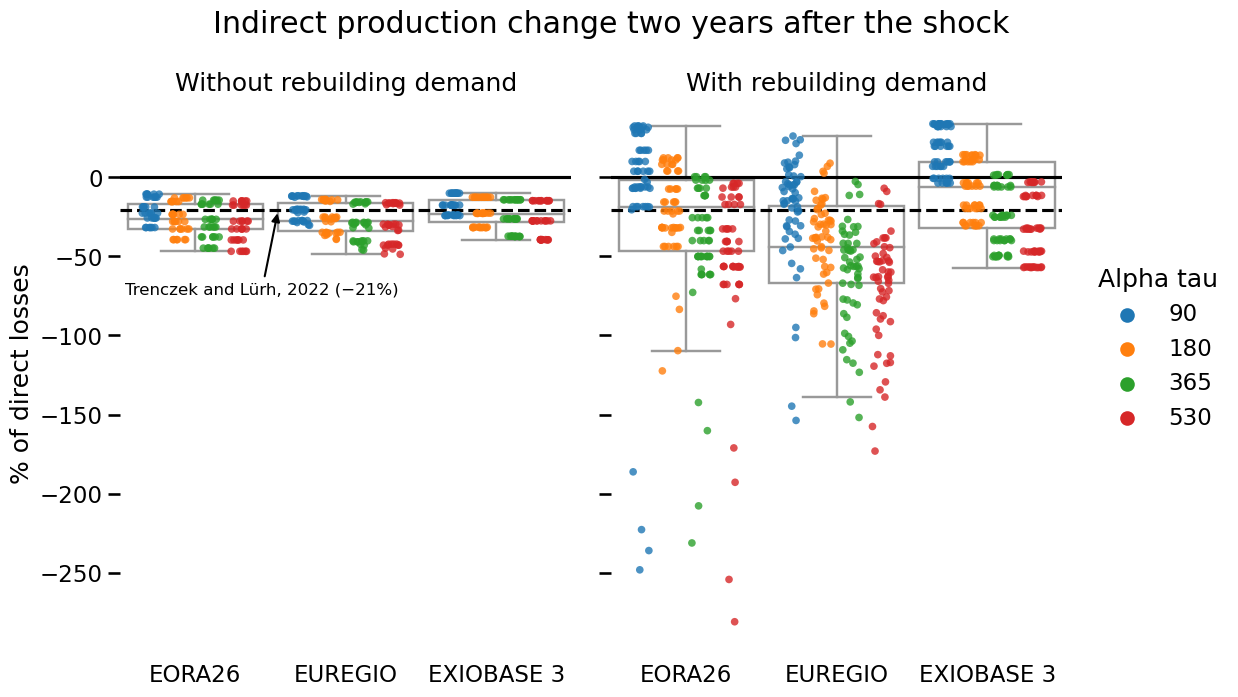

In [10]:
param = "Alpha tau"

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
#plot_df_noabs = plot_df.copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Yes","No")
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name_full",param])
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.sector.str.contains("All"))].copy()
colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="strip", 
    jitter=0.25,
    y = "value_imp_c",
    x = "mrio_name",
    hue = param,
    size=5.5,
    alpha=0.8,
    palette="tab10",
    dodge=True,
    #legend=False,
    col="rectype",
    col_order=["Without rebuilding demand","With rebuilding demand"],
    #hue_order=["3M","6M","1Y","1_5Y","2Y"],
    #palette=sns.color_palette(),
    data=plot_df_noabs,
    #**PROPS,
    height=7,
    aspect=0.8,
    #sharey=False,
)

graph.map_dataframe(
    sns.boxplot,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y= "value_imp_c",
    x = "mrio_name",
)



graph.map(plt.axhline, y=0, ls="-", c="black")

graph.map(plt.axhline,y=-0.21*100, ls="--", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

ax.annotate('Trenczek and Lürh, 2022 (−21%)', xy=(0.35,-21),
            xycoords=('axes fraction',"data"),
            xytext=(-110,-60),
            arrowprops=dict(facecolor='black', edgecolor="black",arrowstyle="-|>", connectionstyle="arc3",relpos=(0.5, 0.5)),
            textcoords='offset points',
            color="black",
            fontsize=12, 
            ha="left",
            #rotation=90,
           )

#plt.axvline(x=-0.25, ls="--", c="red")
#graph.set_xticklabels(['EORA26', 'EXIOBASE3', 'EUREGIO'])
#graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=1.05)
#set_title()
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)

graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_aggregated_influence_of_{param}.png")

display(plot_df_noabs.groupby(["rectype","mrio_name"])['value_imp_c'].describe())

#### Param sectors

In [41]:
param = "mrio_name"

/tmp/ipykernel_25918/1815057423.py:18: UserWarning:

The palette list has more values (10) than needed (3), which may not be intended.



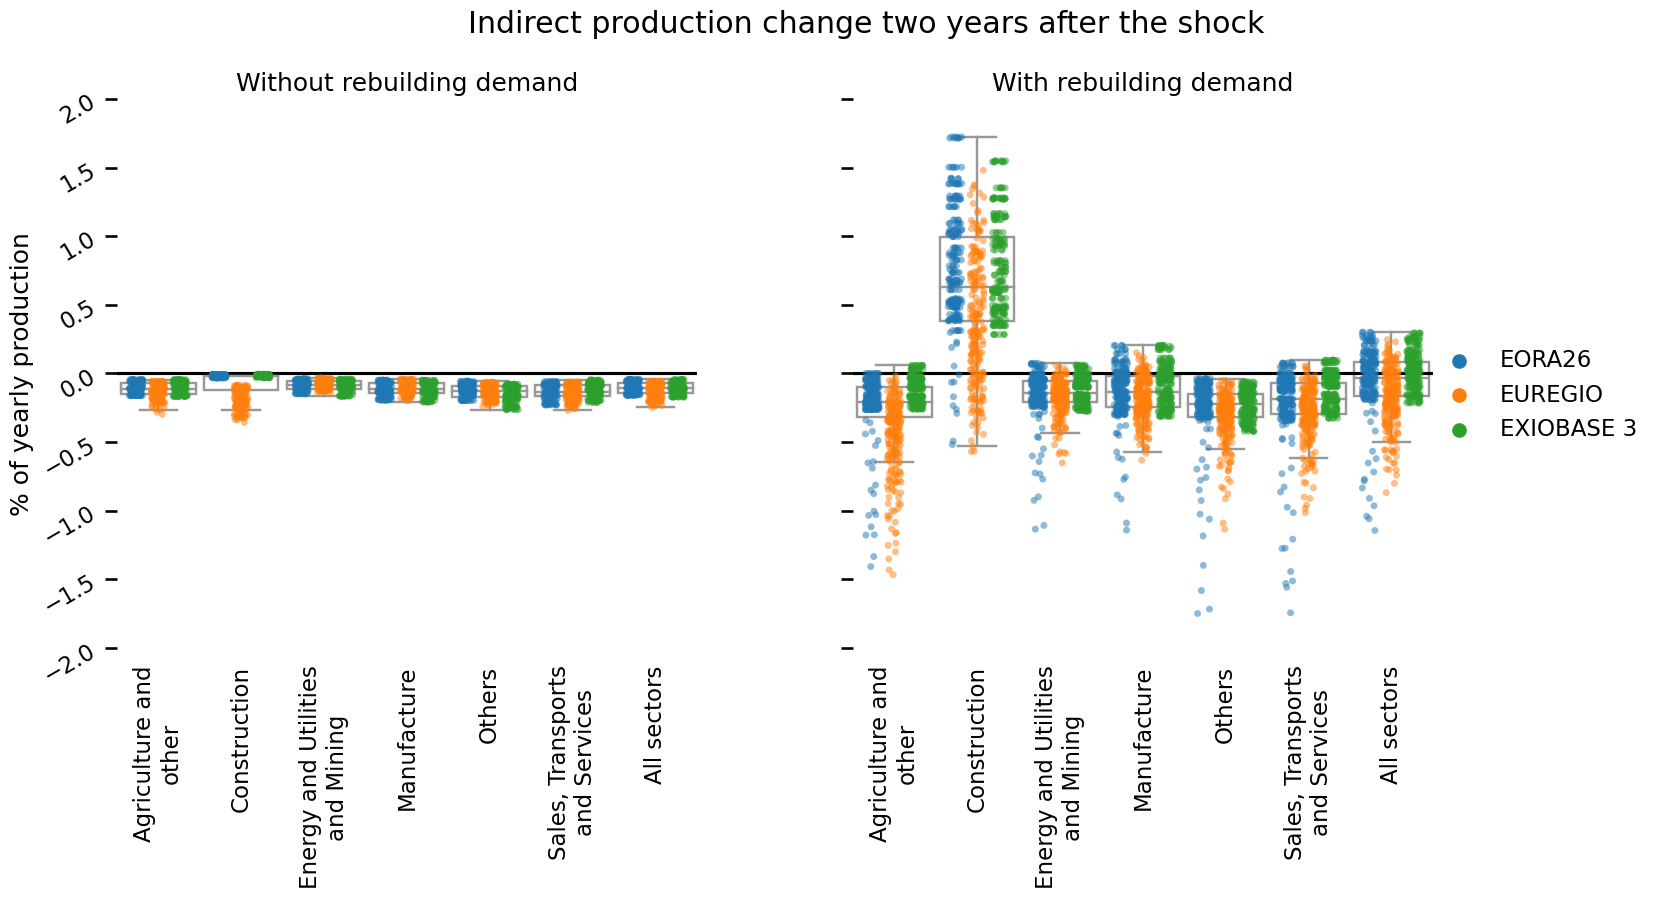

In [79]:
from textwrap import wrap
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
#plot_df_noabs = plot_df.copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Yes","No")
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name_full",param])
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y")].copy()
colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="strip", 
    jitter=0.25,
    y = "value_cumsum_pct",
    x = "sector",
    hue = param,
    size=5.,
    alpha=0.5,
    dodge=True,
    #legend=False,
    col="rectype",
    col_order=["Without rebuilding demand","With rebuilding demand"],
    palette=sns.color_palette(),
    data=plot_df_noabs,
    #**PROPS,
    height=7,
    aspect=1.1
)

graph.map_dataframe(
    sns.boxplot,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y= "value_cumsum_pct",
    x = "sector",
)



graph.map(plt.axhline, y=0, ls="-", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

labels = ax.get_xticklabels()
# fix the labels
for v in labels:
    text = v.get_text()
    text = '\n'.join(wrap(text, 20))
    v.set_text(text)
#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(labels,rotation=90)
graph.set_yticklabels(ax.get_yticklabels(), rotation=30)

graph.set_axis_labels("","% of yearly production")
graph.set_titles("{col_name}")
graph.fig.suptitle("Indirect production change two years after the shock",y=1.05)
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)
sns.move_legend(graph,title="",loc="center right", bbox_to_anchor=(0.95, 0.5))
graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_per_sectors_influence_of_{param}.png")

#### Shortages

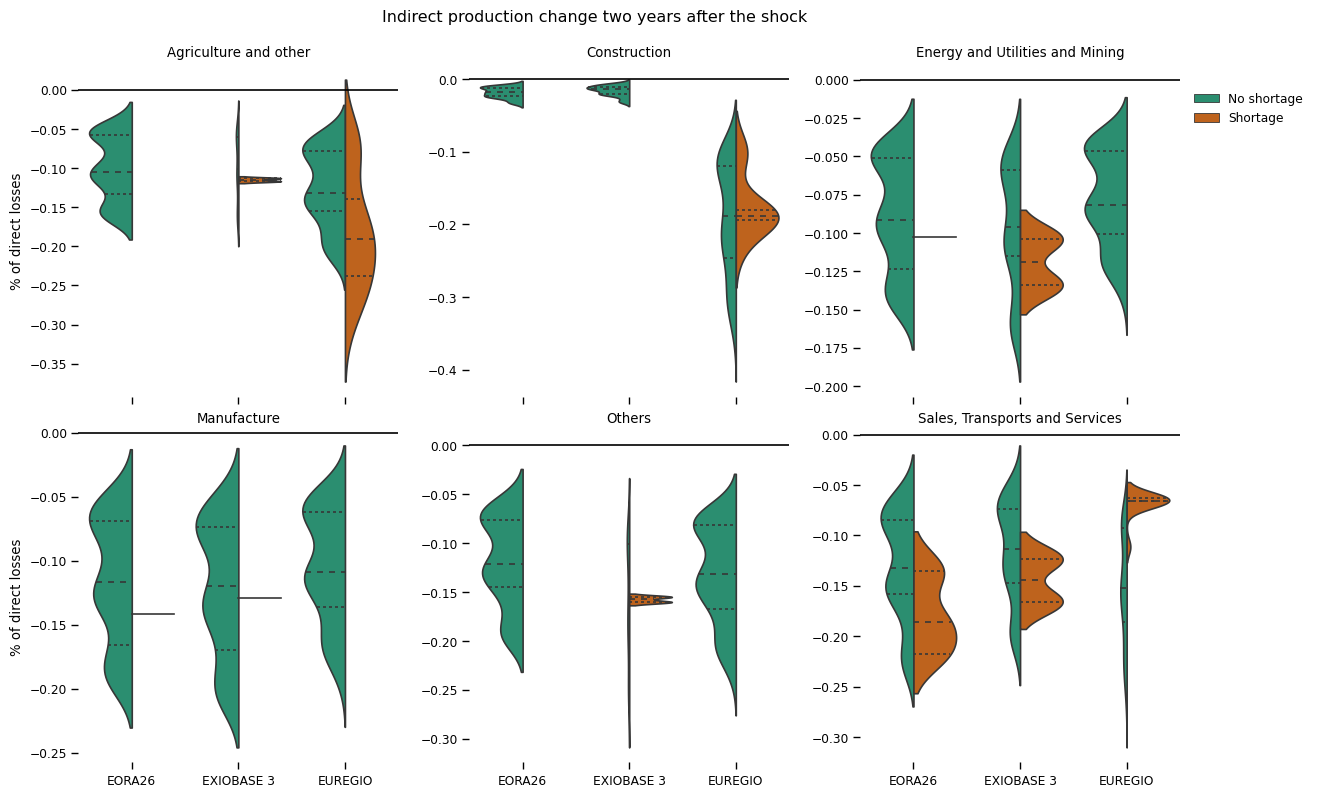

In [49]:
sns.set_context("paper")
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.rectype=="Without rebuilding demand") & (~plot_df_noabs.sector.str.contains("All sectors"))]#.reset_index().drop("index",axis=1)
#plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02']# Set your custom color palette
palette = (sns.color_palette(colors))

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
g = sns.FacetGrid(plot_df_noabs, col='sector', col_wrap=3, margin_titles=True, height=4, aspect=0.9, legend_out=True, sharey=False)

# Create the violin plot for indirect production losses
g.map_dataframe(sns.violinplot, x='mrio_name', y='value_cumsum_pct', hue='Shortage', split=True, inner='quart', palette=palette)
#g.map_dataframe(sns.swarmplot, x='Shortage', y='value_imp_c', dodge=True, size=4, alpha=0.7)

# Customize each subplot
g.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = g.axes

g.set_axis_labels('Sectors', 'Indirect Production Losses')
#g.set(xticks=[], yticks=[])
g.add_legend(title='Shortage')

g.map(plt.axhline, y=0, ls="-", c="black")

sns.move_legend(g, loc="upper right", title="", bbox_to_anchor=(1.1, 0.90))

g.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
#graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
g.fig.suptitle("Indirect production change two years after the shock",y=0.99)
#set_title()
g.despine(left=True, bottom=True)
#ax1.tick_params(bottom=False)
#ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

g.savefig("../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_shortage_compare_all_mriot_all_sectors_violin_no_rebuilding.png")

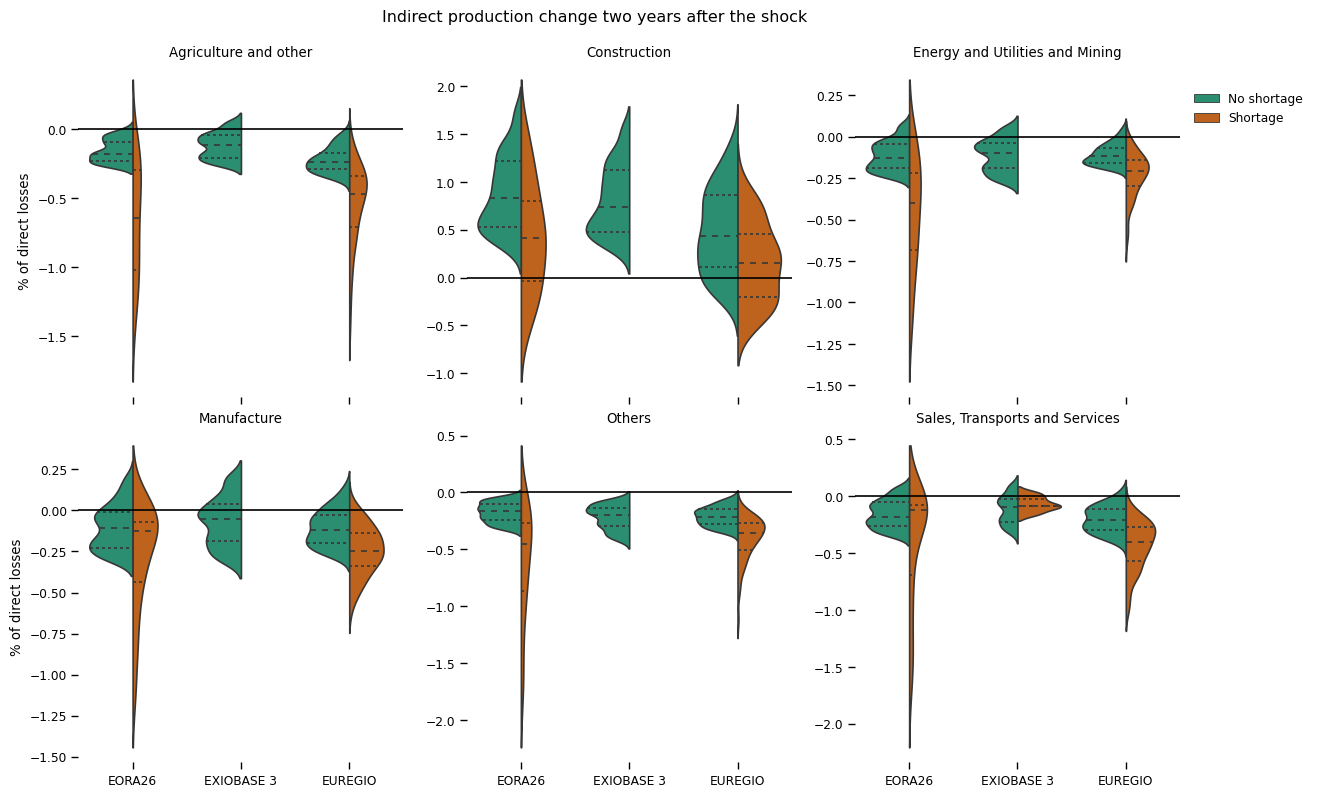

In [50]:
sns.set_context("paper")
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.rectype=="With rebuilding demand") & (~plot_df_noabs.sector.str.contains("All sectors"))]#.reset_index().drop("index",axis=1)
#plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02']# Set your custom color palette
palette = (sns.color_palette(colors))

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
g = sns.FacetGrid(plot_df_noabs, col='sector', col_wrap=3, margin_titles=True, height=4, aspect=0.9, legend_out=True, sharey=False)

# Create the violin plot for indirect production losses
g.map_dataframe(sns.violinplot, x='mrio_name', y='value_cumsum_pct', hue='Shortage', split=True, inner='quart', palette=palette)
#g.map_dataframe(sns.swarmplot, x='Shortage', y='value_imp_c', dodge=True, size=4, alpha=0.7)

# Customize each subplot
g.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = g.axes

g.set_axis_labels('Sectors', 'Indirect Production Losses')
#g.set(xticks=[], yticks=[])
g.add_legend(title='Shortage')

g.map(plt.axhline, y=0, ls="-", c="black")

sns.move_legend(g, loc="upper right", title="", bbox_to_anchor=(1.1, 0.90))

g.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
#graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
g.fig.suptitle("Indirect production change two years after the shock",y=0.99)
#set_title()
g.despine(left=True, bottom=True)
#ax1.tick_params(bottom=False)
#ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

g.savefig("../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_shortage_compare_all_mriot_all_sectors_violin_with_rebuilding.png")

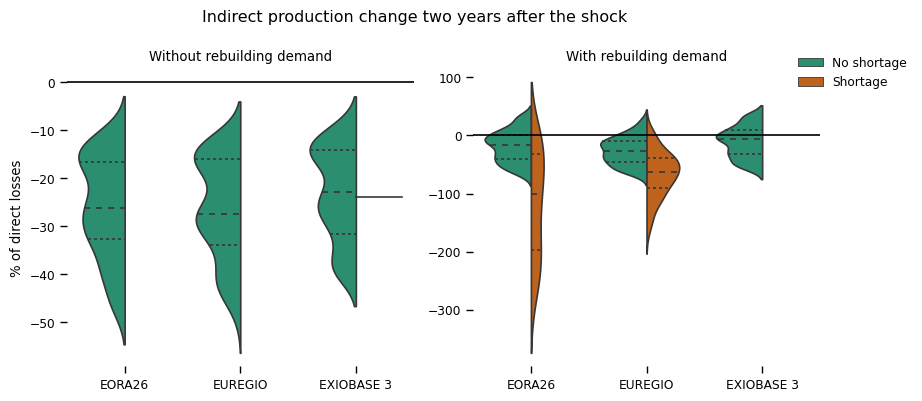

In [36]:
sns.set_context("paper")
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.sector.str.contains("All sectors"))]#.reset_index().drop("index",axis=1)
#plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02']# Set your custom color palette
palette = (sns.color_palette(colors))

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
g = sns.FacetGrid(plot_df_noabs, col='rectype', margin_titles=True, height=4, aspect=0.9, legend_out=True, sharey=False, col_order=['Without rebuilding demand','With rebuilding demand'])

# Create the violin plot for indirect production losses
g.map_dataframe(sns.violinplot, x='mrio_name', y='value_imp_c', hue='Shortage', split=True, inner='quart', palette=palette)
#g.map_dataframe(sns.swarmplot, x='Shortage', y='value_imp_c', dodge=True, size=4, alpha=0.7)

# Customize each subplot
g.set_titles(row_template='{row_name}', col_template='{col_name}')
axes = g.axes

g.set_axis_labels('Sectors', 'Indirect Production Losses')
#g.set(xticks=[], yticks=[])
g.add_legend(title='Shortage')

g.map(plt.axhline, y=0, ls="-", c="black")

sns.move_legend(g, loc="upper right", title="", bbox_to_anchor=(1.1, 0.90))

g.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
#graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
g.fig.suptitle("Indirect production change two years after the shock",y=0.99)
#set_title()
g.despine(left=True, bottom=True)
#ax1.tick_params(bottom=False)
#ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

g.savefig("../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_shortage_compare_all_mriot_violin.png")

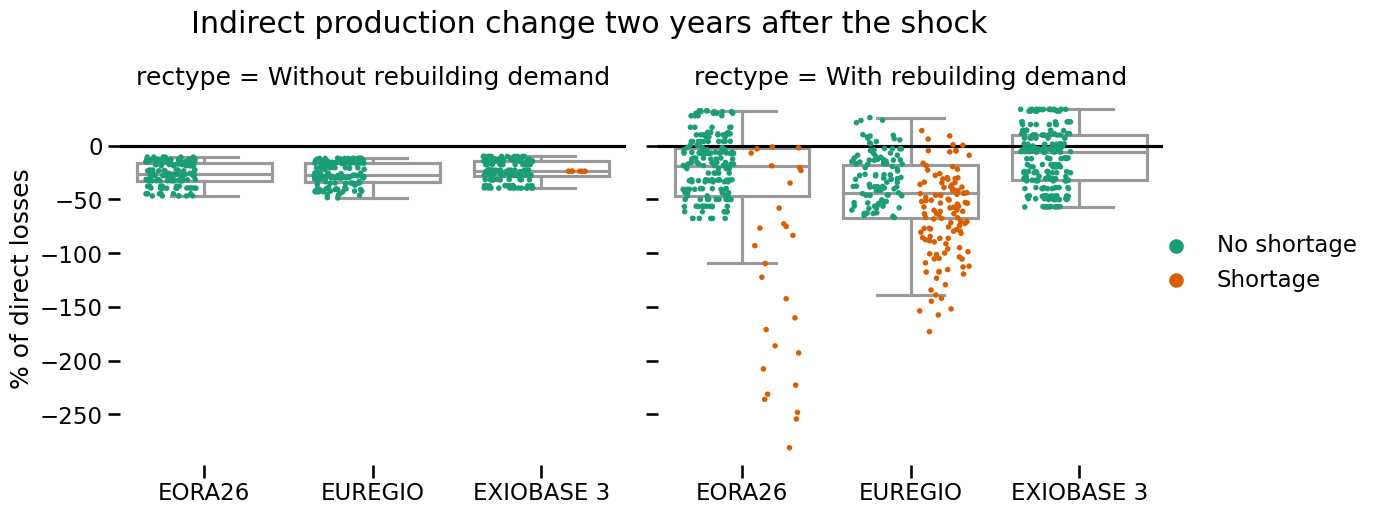

In [21]:
import numpy as np
sns.set_context("talk")

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.sector.str.contains("All sectors"))]#.reset_index().drop("index",axis=1)
plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02']# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}

graph = sns.catplot(
    plot_df_noabs,
    col_order=["Without rebuilding demand","With rebuilding demand"],
    col="rectype",
    #row="mrio_name",
    kind="strip",
    #linewidth=1.75,
    #width=0.9,
    #orient="v",
    jitter=0.3,
    #color="white",
    hue="Shortage",
    #fliersize=0,
    y = "value_imp_c",
    x = "mrio_name",
    #   **PROPS,
    height=5.5,
    aspect=0.9,
    size=4.,
    #alpha=0.8,
    dodge=True,
    palette=palette,
    legend=True,
    #sharey=False,
    #legend_out=True,
)

graph.map_dataframe(
    sns.boxplot, 
    #jitter=0.25,
    fliersize=0,
    y="value_imp_c",
    x = "mrio_name",
    color="white",
    #legend=False,
    #size=3.5,
    #alpha=0.8,
    #palette=palette,
    #**PROPS,
)

#graph.add_legend()

graph.map(plt.axhline, y=0, ls="-", c="black")

#graph.map(plt.axhline,y=-0.21*100, ls="--", c="black")

#ax1 = graph.facet_axis(0,0)
#ax2 = graph.facet_axis(0,1)
#ax3 = graph.facet_axis(1,0)
#ax4 = graph.facet_axis(1,1)


sns.move_legend(graph, loc="lower right", title="", bbox_to_anchor=(1.15, 0.40))

#plt.axvline(x=-0.25, ls="--", c="red")
#graph.set_xticklabels(['EORA26', 'EUREGIO', 'EXIOBASE3'])
#graph.set_yticklabels(ax1.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
#graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=0.95)
#set_title()
graph.despine(left=True, bottom=True)
#ax1.tick_params(bottom=False)
#ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

graph.savefig("../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_shortage_compare.png")

#### Hallegatte's values

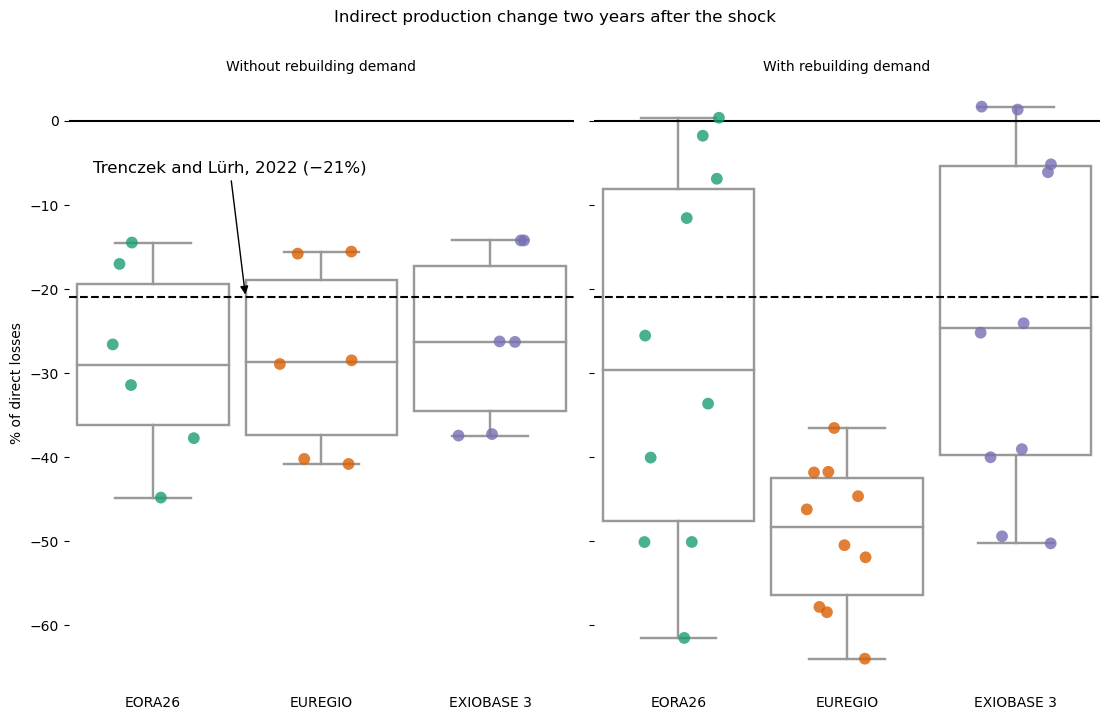

In [24]:
param = "mrio_name"
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
#plot_df_noabs = plot_df.copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Yes","No")
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name_full",param])
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.sector.str.contains("All"))].copy()
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.psi=="0.85") & (plot_df_noabs.alpha_tau=="365")].copy()
colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="strip", 
    jitter=0.25,
    y = "value_imp_c",
    x = "mrio_name",
    hue = param,
    size=8.5,
    alpha=0.8,
    palette=palette,
    #dodge=True,
    #legend=False,
    col="rectype",
    col_order=["Without rebuilding demand","With rebuilding demand"],
    #palette=sns.color_palette(),
    data=plot_df_noabs,
    #**PROPS,
    height=7,
    aspect=0.8,
    #sharey=False,
)

graph.map_dataframe(
    sns.boxplot,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y= "value_imp_c",
    x = "mrio_name",
)



graph.map(plt.axhline, y=0, ls="-", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

if region == "DEU":
    graph.map(plt.axhline,y=-0.21*100, ls="--", c="black")
    ax.annotate('Trenczek and Lürh, 2022 (−21%)', xy=(0.35,-21),
                xycoords=('axes fraction',"data"),
                xytext=(-110,90),
                arrowprops=dict(facecolor='black', edgecolor="black",arrowstyle="-|>", connectionstyle="arc3",relpos=(0.5, 0.5)),
                textcoords='offset points',
                color="black",
                fontsize=12, 
                ha="left",
                #rotation=90,
               )

#plt.axvline(x=-0.25, ls="--", c="red")
#graph.set_xticklabels(['EORA26', 'EXIOBASE3', 'EUREGIO'])
#graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=1.05)
#set_title()
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)

graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_aggregated_influence_of_{param}_in_{region}_hallegatte_values.png")

#### Shortages per MRIOT

/tmp/ipykernel_177616/951471502.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  graph = sns.catplot(


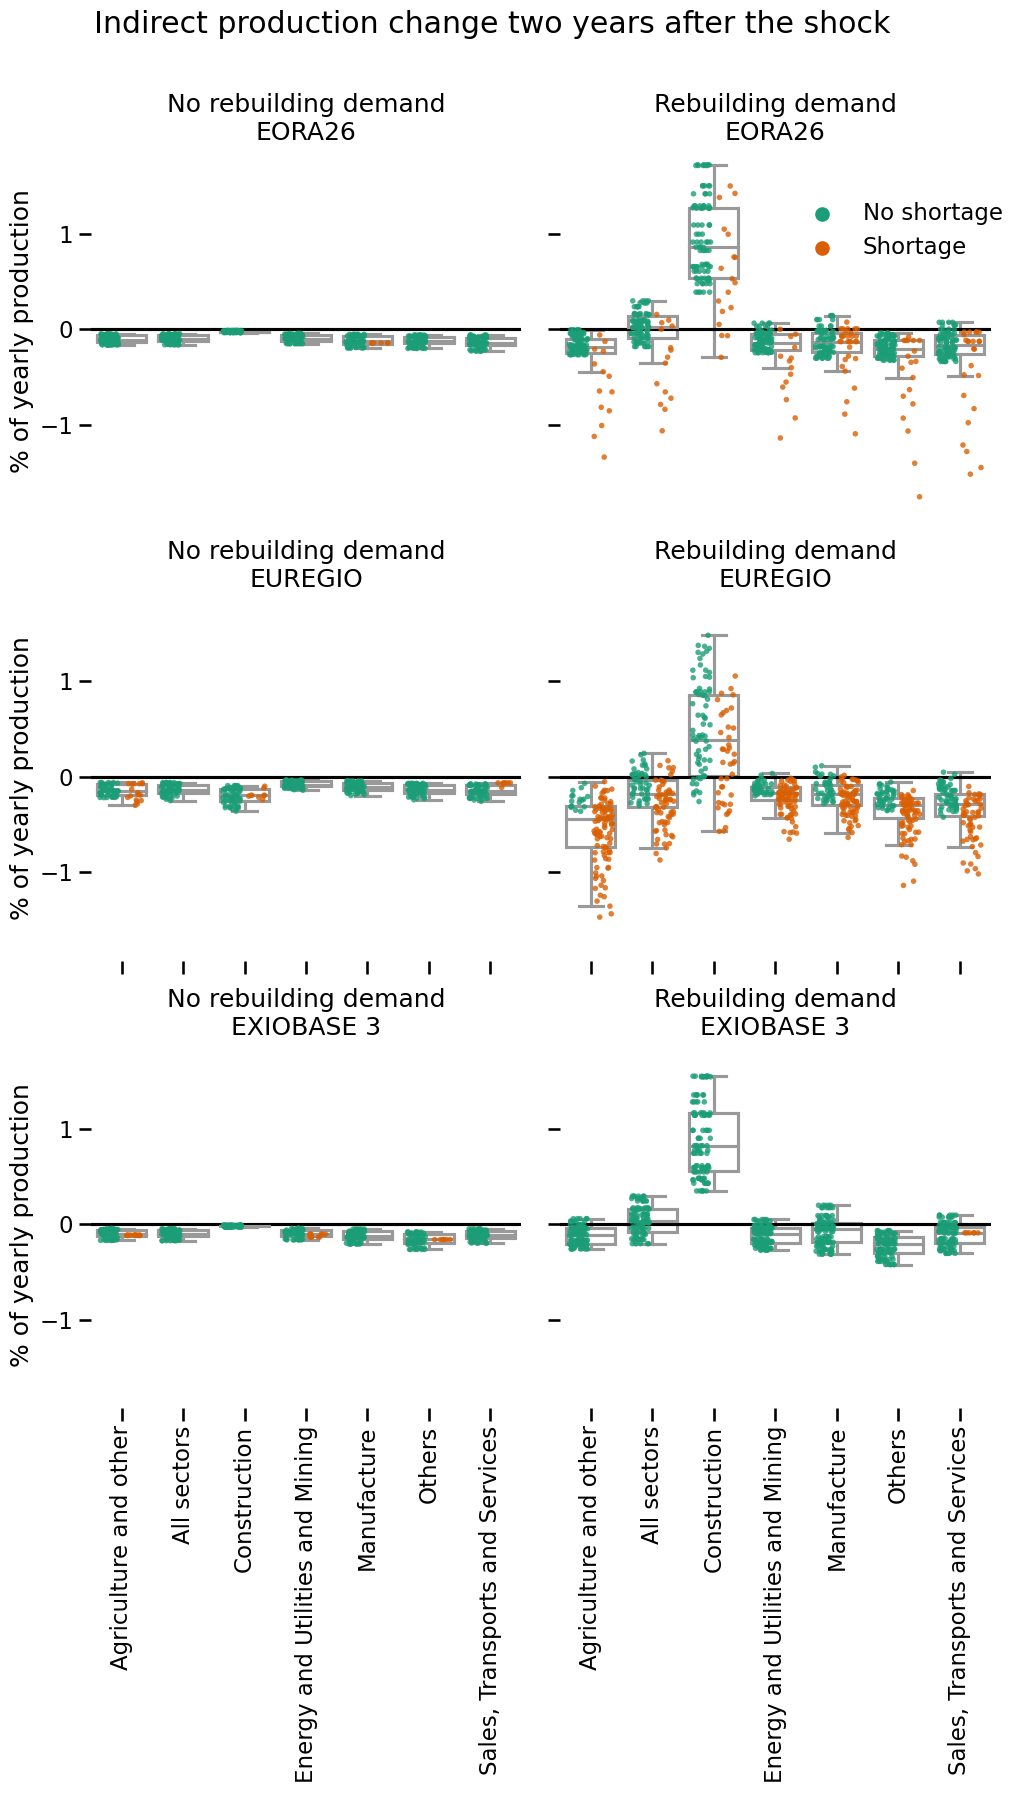

In [99]:
import numpy as np

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.mrio.str.contains("2010"))]#.reset_index().drop("index",axis=1)
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name","sector"])
colors = ['#1b9e77','#d95f02','#7570b3']# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}

graph = sns.catplot(
    plot_df_noabs,
    col_order=["No rebuilding demand","Rebuilding demand"],
    col="rectype",
    row="mrio_name",
    kind="strip",
    #linewidth=1.75,
    #width=0.9,
    #orient="v",
    jitter=0.3,
    #color="white",
    hue="Shortage",
    #fliersize=0,
    y="value_cumsum_pct",
    x = "sector",
    #   **PROPS,
    height=6,
    aspect=0.7,
    size=4.,
    alpha=0.8,
    dodge=True,
    palette=palette,
    legend=True,
    #legend_out=True,
)

graph.map_dataframe(
    sns.boxplot, 
    #jitter=0.25,
    fliersize=0,
    y="value_cumsum_pct",
    x = "sector",
    color="white",
    #legend=False,
    #size=3.5,
    #alpha=0.8,
    #palette=palette,
    #**PROPS,
)

#graph.add_legend()

graph.map(plt.axhline, y=0, ls="-", c="black")

ax1 = graph.facet_axis(0,0)
ax2 = graph.facet_axis(0,1)
#ax3 = graph.facet_axis(1,0)
#ax4 = graph.facet_axis(1,1)


sns.move_legend(graph, loc="lower right", title="", bbox_to_anchor=(1, 0.85))


#plt.axvline(x=-0.25, ls="--", c="red")
#graph.set_xticklabels(['EORA26', 'EUREGIO', 'EXIOBASE3'])
graph.set_xticklabels(graph.facet_axis(2,1).get_xticklabels(), rotation=90)
#graph.set_ylabel("")
graph.set_axis_labels("","% of yearly production")
#graph.set_xlabel("")
graph.set_titles("{col_name}\n{row_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=1.00)
#set_title()
graph.despine(left=True, bottom=True)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

### Other region

In [34]:
region="USA"
plot_df = pd.read_parquet(f"./parquets_cache/sensitivity_full_sims_{region}_plot_df.parquet")

#### Renaming

In [35]:
plot_df.rectype = plot_df.rectype.map({"reclin":"No rebuilding demand","reb":"Rebuilding demand"})
plot_df.sector = plot_df.sector.replace({"all":"All sectors"})
plot_df["mrio_name"] = plot_df.mrio.replace({
    "eora26_full_2000":"EORA26",
    "exiobase3_full_2000":"EXIOBASE 3",
    "euregio_full_2000":"EUREGIO",
    "eora26_full_2010":"EORA26",
    "exiobase3_full_2010":"EXIOBASE 3",
    "euregio_full_2010":"EUREGIO",
})


plot_df["MRIOT Year"] = plot_df.mrio.replace({
    "eora26_full_2000":"2000",
    "exiobase3_full_2000":"2000",
    "euregio_full_2000":"2000",
    "eora26_full_2010":"2010",
    "exiobase3_full_2010":"2010",
    "euregio_full_2010":"2010",
})

plot_df["mrio_name_full"] = plot_df.mrio.replace({
    "eora26_full_2000":"EORA26 2000",
    "exiobase3_full_2000":"EXIOBASE3 2000",
    "euregio_full_2000":"EUREGIO 2000",
    "eora26_full_2010":"EORA26 2010",
    "exiobase3_full_2010":"EXIOBASE3 2010",
    "euregio_full_2010":"EUREGIO 2010",
})

plot_df["Alpha tau"] = plot_df["alpha_tau"].astype(int)
plot_df["Recovery length (days)"] = plot_df.length.replace({
    "3M":90,
    "6M":180,
    "1Y":365,
    "1_5Y":545,
    "2Y":730,
})

In [36]:
sns.set_context("talk")

#### Param aggregated

In [37]:
#param = "psi"
#param = "Alpha tau"
#param = "Recovery length (days)"
param = "mrio_name"

/tmp/ipykernel_27871/1222916868.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  graph = sns.catplot(


value_imp_c                                 \
                                      count      mean       std        min   
rectype              mrio_name                                               
No rebuilding demand EORA26           144.0  0.175411  0.150457  -0.103151   
                     EUREGIO          144.0 -0.003407  0.089446  -0.220271   
                     EXIOBASE 3       144.0  0.082630  0.113972  -0.157999   
Rebuilding demand    EORA26           240.0  0.173901  3.647432 -29.654368   
                     EUREGIO          240.0  0.453603  1.232441  -7.807975   
                     EXIOBASE 3       240.0  0.969514  0.587543  -0.807341   

                                                                         
                                      25%       50%       75%       max  
rectype              mrio_name                                           
No rebuilding demand EORA26      0.062623  0.164816  0.288681  0.470100  
                     EUREGIO    -0.038566 -0.003939  0.048349  0.161120  
                     EXIOBASE 3  0.013421  0.080721  0.166627  0.320318  
Rebuilding demand    EORA26      0.605765  0.929975  1.340918  2.000665  
                     EUREGIO     0.380927  0.683108  1.073490  1.679587  
                     EXIOBASE 3  0.597401  0.934661  1.260735  2.135307

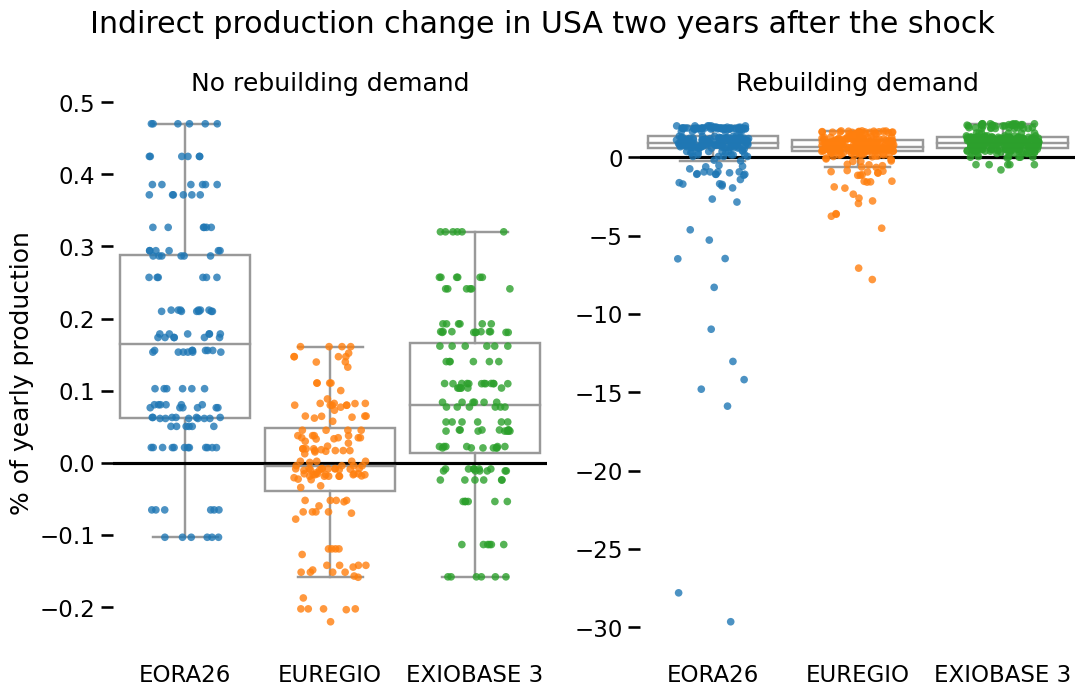

In [39]:
var_to_look="value_imp_c" #"value_cumsum_pct"

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
#plot_df_noabs = plot_df.copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Yes","No")
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name_full",param])
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.sector.str.contains("All"))].copy()
colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="strip", 
    jitter=0.25,
    y = var_to_look,
    x = "mrio_name",
    hue = param,
    size=5.5,
    alpha=0.8,
    #dodge=True,
    col="rectype",
    col_order=["No rebuilding demand","Rebuilding demand"],
    palette=sns.color_palette(),
    data=plot_df_noabs,
    #**PROPS,
    height=7,
    aspect=0.8,
    sharey=False,
)

graph.map_dataframe(
    sns.boxplot,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y= var_to_look,
    x = "mrio_name",
)



graph.map(plt.axhline, y=0, ls="-", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

#plt.axvline(x=-0.25, ls="--", c="red")
#graph.set_xticklabels(['EORA26', 'EXIOBASE3', 'EUREGIO'])
#graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of yearly production")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle(f"Indirect production change in {region} two years after the shock",y=1.05)
#set_title()
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)

graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_aggregated_influence_of_{param}_in_{region}_{var_to_look}.png")

plot_df_noabs[["rectype","mrio_name",var_to_look]].groupby(["rectype","mrio_name"]).describe()

#### Param sectors

/tmp/ipykernel_471802/1600081469.py:17: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  graph = sns.catplot(


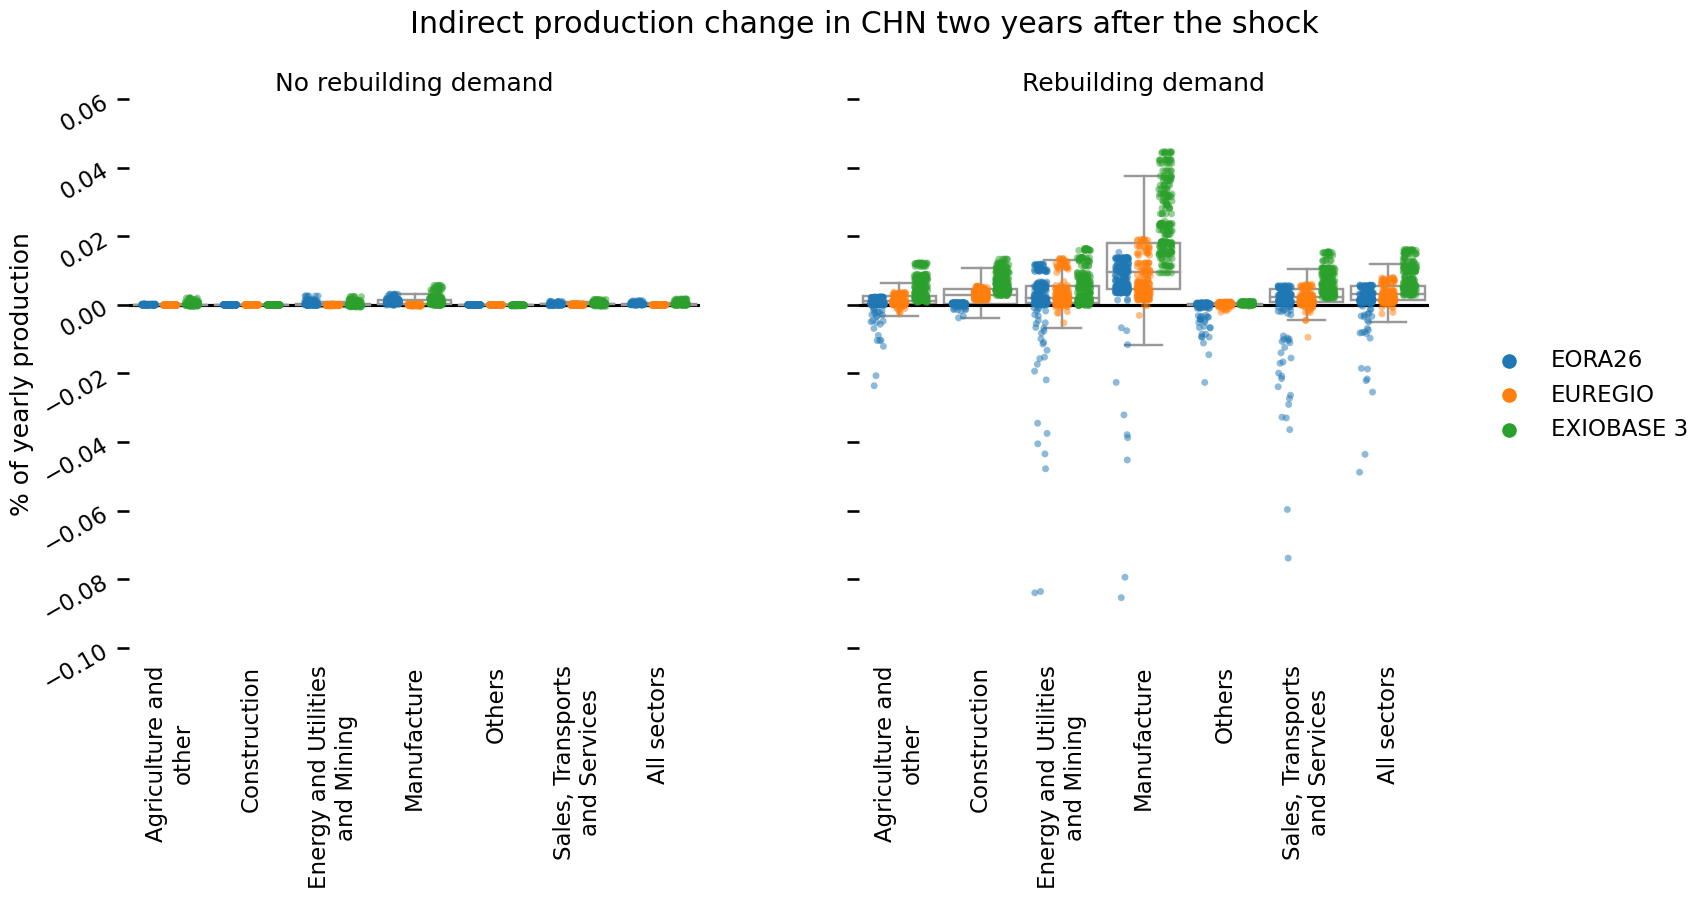

In [305]:
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
#plot_df_noabs = plot_df.copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Yes","No")
plot_df_noabs = plot_df_noabs.sort_values(by=["mrio_name_full",param])
plot_df_noabs = plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y")].copy()
colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="strip", 
    jitter=0.25,
    y = "value_cumsum_pct",
    x = "sector",
    hue = param,
    size=5.,
    alpha=0.5,
    dodge=True,
    #legend=False,
    col="rectype",
    col_order=["No rebuilding demand","Rebuilding demand"],
    palette=sns.color_palette(),
    data=plot_df_noabs,
    #**PROPS,
    height=7,
    aspect=1.1
)

graph.map_dataframe(
    sns.boxplot,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y= "value_cumsum_pct",
    x = "sector",
)



graph.map(plt.axhline, y=0, ls="-", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

labels = ax.get_xticklabels()
# fix the labels
for v in labels:
    text = v.get_text()
    text = '\n'.join(wrap(text, 20))
    v.set_text(text)
#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(labels,rotation=90)
graph.set_yticklabels(ax.get_yticklabels(), rotation=30)

graph.set_axis_labels("","% of yearly production")
graph.set_titles("{col_name}")
graph.fig.suptitle(f"Indirect production change in {region} two years after the shock",y=1.05)
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)
sns.move_legend(graph,title="",loc="center right", bbox_to_anchor=(0.98, 0.5))
graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_per_sectors_influence_of_{param}_in_{region}.png")

#### Shortages

/tmp/ipykernel_471802/3927646800.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  graph = sns.catplot(


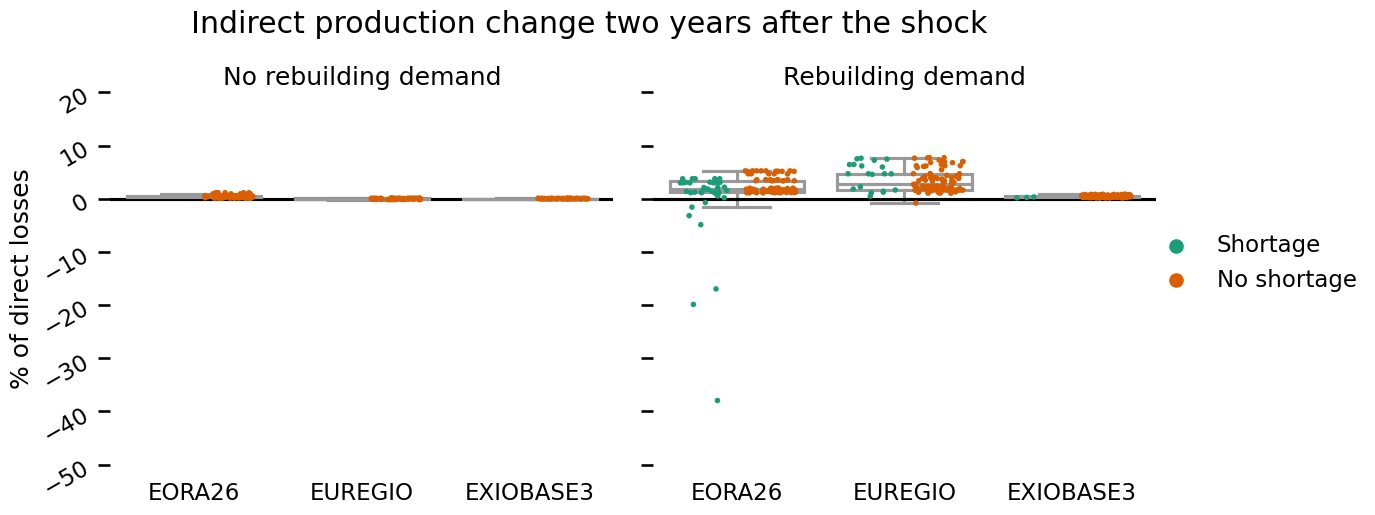

In [179]:
import numpy as np

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.mrio.str.contains("2010")) & (plot_df_noabs.sector.str.contains("All"))]#.reset_index().drop("index",axis=1)
plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02','#7570b3']# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}

graph = sns.catplot(
    plot_df_noabs,
    col_order=["No rebuilding demand","Rebuilding demand"],
    col="rectype",
    #row="mrio_name",
    kind="strip",
    #linewidth=1.75,
    #width=0.9,
    #orient="v",
    jitter=0.3,
    #color="white",
    hue="Shortage",
    #fliersize=0,
    y = "value_imp_c",
    x = "mrio",
    #   **PROPS,
    height=5.5,
    aspect=0.9,
    size=4.,
    #alpha=0.8,
    dodge=True,
    palette=palette,
    legend=True,
    #legend_out=True,
)

graph.map_dataframe(
    sns.boxplot, 
    #jitter=0.25,
    fliersize=0,
    y="value_imp_c",
    x = "mrio",
    color="white",
    #legend=False,
    #size=3.5,
    #alpha=0.8,
    #palette=palette,
    #**PROPS,
)

#graph.add_legend()

graph.map(plt.axhline, y=0, ls="-", c="black")

ax1 = graph.facet_axis(0,0)
ax2 = graph.facet_axis(0,1)
#ax3 = graph.facet_axis(1,0)
#ax4 = graph.facet_axis(1,1)


sns.move_legend(graph, loc="lower right", title="", bbox_to_anchor=(1.15, 0.40))

#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(['EORA26', 'EUREGIO', 'EXIOBASE3'])
graph.set_yticklabels(ax1.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=0.95)
#set_title()
graph.despine(left=True, bottom=True)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

graph.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/no_outliers_shortage_compare_in_{region}.png")

/home/sjuhel/mambaforge-pypy3/envs/versa/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/home/sjuhel/mambaforge-pypy3/envs/versa/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)


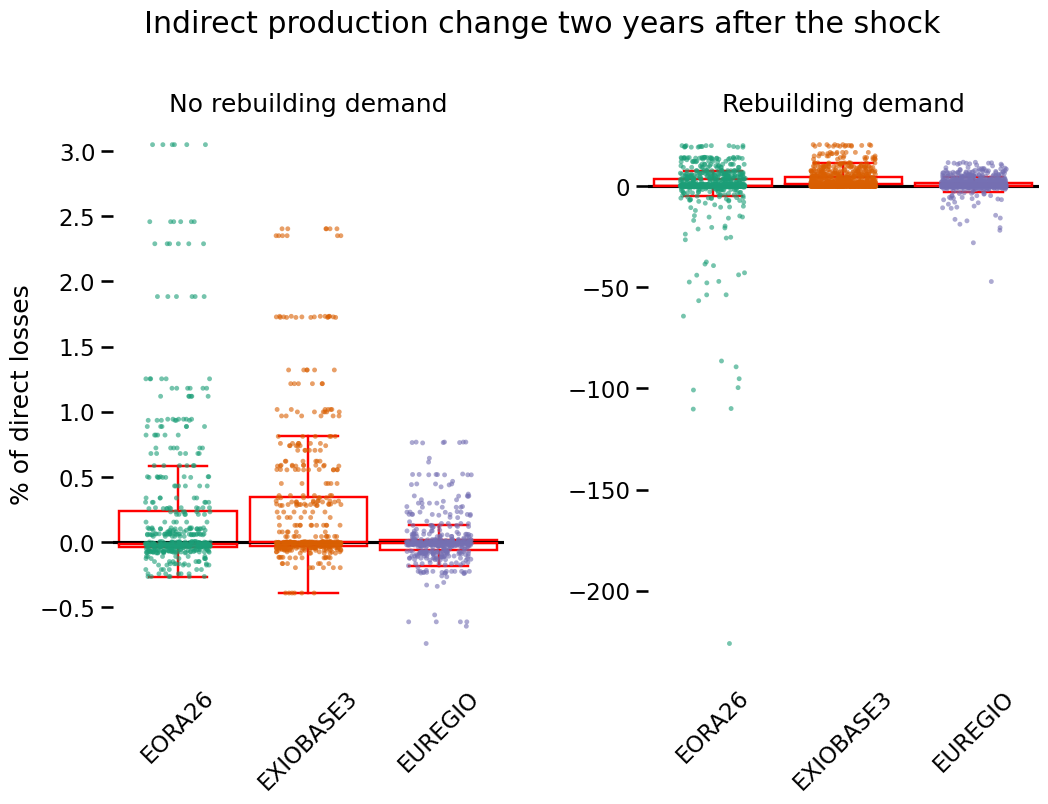

In [45]:
plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()

colors = ["#1b9e77","#d95f02","#7570b3"]# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}


graph = sns.catplot(
    kind="box",
    col="rectype",
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y="value_imp_c",
    x = "mrio",
    #palette=palette,
    data=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.mrio.str.contains("2010")) &],
       **PROPS,
    height=7,
    aspect=0.8,
    sharey=False,
)

graph.map_dataframe(
    sns.stripplot, 
    jitter=0.25,
    y="value_imp_c",
    x = "mrio",
    size=3.5,
    alpha=0.6,
    palette=palette,
)



graph.map(plt.axhline, y=0, ls="-", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(['EORA26', 'EXIOBASE3', 'EUREGIO'],rotation=45)
#graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=1.08)
#set_title()
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)

In [49]:
plot_df_noabs.loc[plot_df_noabs.value_imp_c<-10]

mrio   rsce            rectype length   psi alpha_tau   
2101619   eora26_full_2010  reb3M  Rebuilding demand     3M  0.97       365  \
2101627   eora26_full_2010  reb3M  Rebuilding demand     3M  0.97       530   
2942355   eora26_full_2000  reb3M  Rebuilding demand     3M  0.95       365   
2942363   eora26_full_2000  reb3M  Rebuilding demand     3M  0.95       530   
2942371   eora26_full_2000  reb3M  Rebuilding demand     3M  0.97        90   
...                    ...    ...                ...    ...   ...       ...   
488369   euregio_full_2010  reb3M  Rebuilding demand     3M  0.97       180   
489099   euregio_full_2010  reb3M  Rebuilding demand     3M  0.97       365   
489829   euregio_full_2010  reb3M  Rebuilding demand     3M  0.97       530   
490559   euregio_full_2010  reb3M  Rebuilding demand     3M  0.97        90   
508079   euregio_full_2010  reb6M  Rebuilding demand     6M  0.97        90   

        time_looked                           sector          value   
2101619          1y  Energy and Utilities and Mining   10177.543823  \
2101627          1y  Energy and Utilities and Mining   10176.979018   
2942355          1y                      Manufacture   29338.103376   
2942363          1y                      Manufacture   29336.537439   
2942371          1y                      Manufacture   29336.805690   
...             ...                              ...            ...   
488369           2y                      All sectors  167250.984541   
489099           2y                      All sectors  167258.550211   
489829           2y                      All sectors  167262.689760   
490559           2y                      All sectors  167240.098067   
508079           2y                      All sectors  167252.341032   

         value_pct  value_cumsum_pct  value_diff  value_imp  value_imp_c   
2101619  -0.000285         -0.091543   -0.029001  -0.000090   -10.564033  \
2101627  -0.005834         -0.095782   -0.593806  -0.001845   -11.053144   
2942355   0.018938         -0.017128    5.554959   0.030729   -10.144592   
2942363   0.013599         -0.019479    3.989022   0.022067   -11.536924   
2942371   0.014514         -0.021542    4.257273   0.023551   -12.758417   
...            ...               ...         ...        ...          ...   
488369   -0.007687         -0.008750  -15.815328  -0.070870   -27.943087   
489099   -0.003963         -0.006019   -8.249658  -0.036967   -18.766959   
489829   -0.001753         -0.005553   -4.110108  -0.018418   -17.099503   
490559   -0.012978         -0.014404  -26.701802  -0.119653   -47.107504   
508079   -0.007195         -0.005116  -14.458837  -0.064791   -15.713496   

         n_peaks  absurd mrio_name  
2101619        2   False    EORA26  
2101627        3   False    EORA26  
2942355        2   False    EORA26  
2942363        2   False    EORA26  
2942371        2   False    EORA26  
...          ...     ...       ...  
488369         2   False   EUREGIO  
489099         2   False   EUREGIO  
489829         2   False   EUREGIO  
490559         3   False   EUREGIO  
508079         2   False   EUREGIO  

[167 rows x 17 columns]

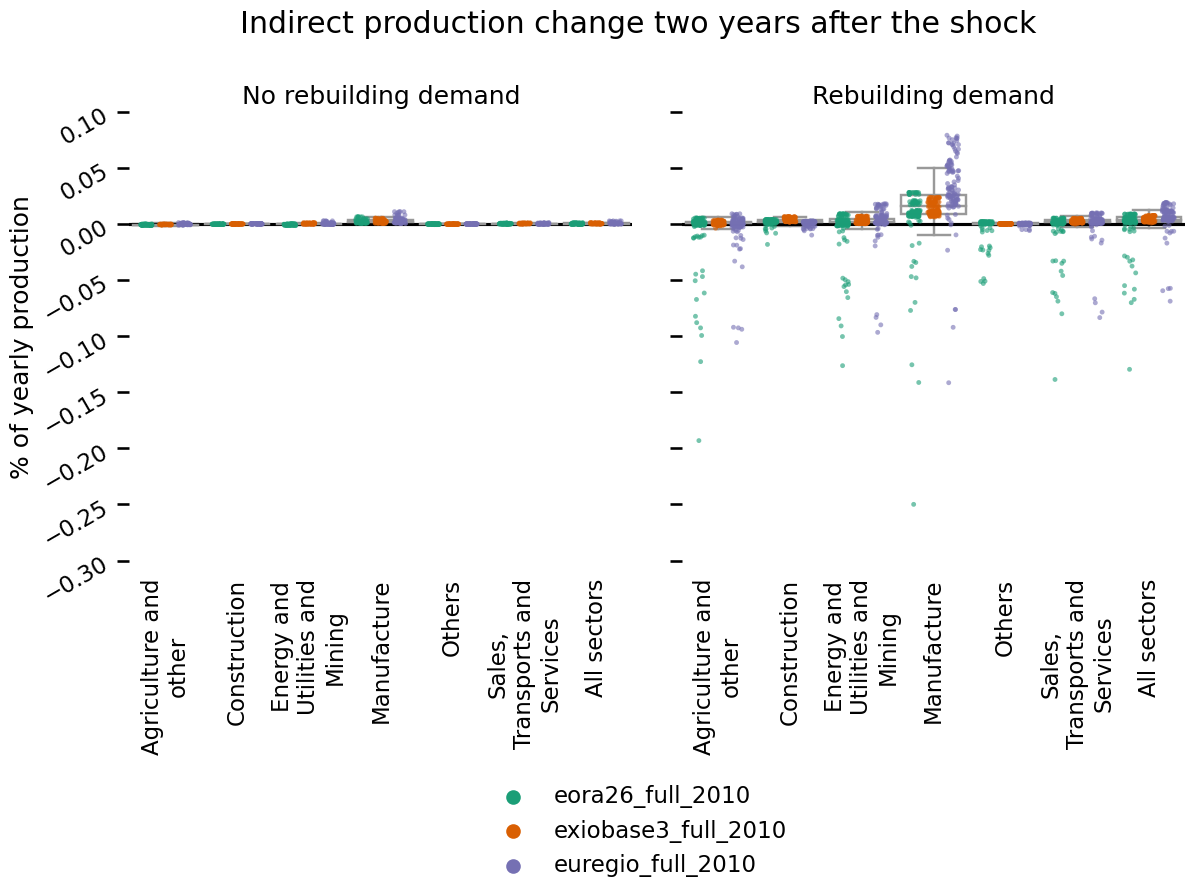

In [496]:
from textwrap import wrap

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}

graph = sns.catplot(
    kind="box",
    col="rectype",
    #palette=palette,
    linewidth=1.75,
    width=0.9,
    orient="v",
    color="white",
    fliersize=0,
    y="value_cumsum_pct",
    x = "sector",
    #hue="mrio",
    #palette=palette,
    data=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.mrio.str.contains("2010"))],
    #   **PROPS,
    height=6,
    aspect=1.1,
    legend=False
)

graph.map_dataframe(
    sns.stripplot, 
    jitter=0.25,
    y="value_cumsum_pct",
    x = "sector",
    hue= "mrio",
    palette=palette,
    dodge=True,
    size=3.5,
    alpha=0.6,
)

graph.add_legend(loc="lower center", bbox_to_anchor=(0.40, -0.4))

graph.map(plt.axhline, y=0, ls="-", c="black")

#graph.map(plt.axhline,y=-0.21*100, ls="--", c="black")

ax = graph.facet_axis(0,0)
ax2= graph.facet_axis(0,1)

labels = ax.get_xticklabels()
# fix the labels
for v in labels:
    text = v.get_text()
    text = '\n'.join(wrap(text, 16))
    v.set_text(text)
#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(labels,rotation=90)
graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_yticklabels(ax.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of yearly production")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=1.08,x=0.4)
#set_title()
graph.despine(left=True, bottom=True)
ax.tick_params(bottom=False)
ax2.tick_params(bottom=False)
plt.subplots_adjust(hspace=0.4, wspace=0.1)

/tmp/ipykernel_9509/2816440025.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  graph = sns.catplot(


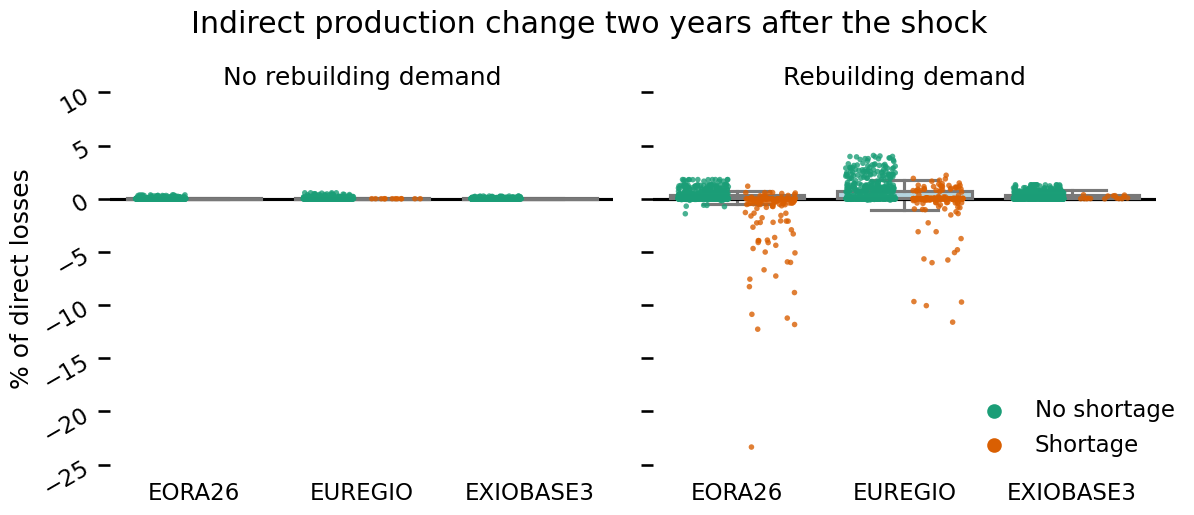

In [497]:
import numpy as np

plot_df_noabs = plot_df.loc[~plot_df.absurd].copy()
plot_df_noabs['Shortage'] = np.where(plot_df_noabs['n_peaks'] > 1,"Shortage","No shortage")
plot_df_noabs=plot_df_noabs.loc[(plot_df_noabs.time_looked=="2y") & (plot_df_noabs.mrio.str.contains("2010"))]#.reset_index().drop("index",axis=1)
plot_df_noabs = plot_df_noabs.sort_values(by="mrio")
colors = ['#1b9e77','#d95f02','#7570b3']# Set your custom color palette
palette = (sns.color_palette(colors))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'red'},
    'medianprops':{'color':'red'},
    'whiskerprops':{'color':'red'},
    'capprops':{'color':'red'}
}

graph = sns.catplot(
    plot_df_noabs,
    col="rectype",
    #row="Shortage",
    kind="strip",
    #linewidth=1.75,
    #width=0.9,
    #orient="v",
    jitter=0.3,
    #color="white",
    hue="Shortage",
    #fliersize=0,
    y="value_imp_c",
    x = "mrio",
    #   **PROPS,
    height=5.5,
    aspect=0.9,
    size=4.,
    alpha=0.8,
    dodge=True,
    palette=palette,
    legend=True,
    #legend_out=True,
)

graph.map_dataframe(
    sns.boxplot, 
    #jitter=0.25,
    fliersize=0,
    y="value_imp_c",
    x = "mrio",
    color="lightblue",
    #legend=False,
    #size=3.5,
    #alpha=0.8,
    #palette=palette,
    #**PROPS,
)

#graph.add_legend()

graph.map(plt.axhline, y=0, ls="-", c="black")

ax1 = graph.facet_axis(0,0)
ax2 = graph.facet_axis(0,1)
#ax3 = graph.facet_axis(1,0)
#ax4 = graph.facet_axis(1,1)


sns.move_legend(graph, loc="lower right", title="", bbox_to_anchor=(1, 0.10))

#plt.axvline(x=-0.25, ls="--", c="red")
graph.set_xticklabels(['EORA26', 'EUREGIO', 'EXIOBASE3'])
graph.set_yticklabels(ax1.get_yticklabels(), rotation=30)
#graph.set_ylabel("")
graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
graph.fig.suptitle("Indirect production change two years after the shock",y=0.95)
#set_title()
graph.despine(left=True, bottom=True)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
#ax3.tick_params(bottom=False)
#ax4.tick_params(bottom=False)
plt.tight_layout()
#plt.subplots_adjust(hspace=0, wspace=0.15)
#graph.set(ylim=(-300, 50))
#plt.grid(visible=True,axis="x", linestyle='-', linewidth=2)

# MRIOT compare

In [21]:
import pickle as pkl

with open("../BoARIO-Sensitivity/mrio-files/pkls/exiobase3/exiobase3_full_2000_ixi.pkl",'rb') as f:
    exio2000 = pkl.load(f)
    
with open("../BoARIO-Sensitivity/mrio-files/pkls/exiobase3/exiobase3_full_2010_ixi.pkl",'rb') as f:
    exio2010 = pkl.load(f)
    
with open("../BoARIO-Sensitivity/mrio-files/pkls/eora26/eora26_full_2000.pkl",'rb') as f:
    eora2000 = pkl.load(f)
    
with open("../BoARIO-Sensitivity/mrio-files/pkls/eora26/eora26_full_2010.pkl",'rb') as f:
    eora2010 = pkl.load(f)
    
with open("../BoARIO-Sensitivity/mrio-files/pkls/euregio/euregio_full_2000.pkl",'rb') as f:
    eureg2000 = pkl.load(f)
    
with open("../BoARIO-Sensitivity/mrio-files/pkls/euregio/euregio_full_2010.pkl",'rb') as f:
    eureg2010 = pkl.load(f)

In [22]:
def load_regions_aggreg(mrio_name):
    if "eora26" in mrio_name:
        return regions_common_aggreg["eora26_without_reexport_to_common_aggreg"]
    elif "euregio" in mrio_name:
        return regions_common_aggreg["euregio_to_common_aggreg"]
    elif "exiobase" in mrio_name:
        return regions_common_aggreg["exiobase_full_to_common_aggreg"]
    elif "oecd" in mrio_name:
        return regions_common_aggreg["icio2021_reworked_to_common_aggreg"]
    else:
        raise ValueError(f"Invalid MRIO name: {mrio_name}")
        

In [23]:
mriots = {}
for name, mriot, mriot_type in zip(["EXIOBASE3 2000","EXIOBASE3 2010","EORA26 2000","EORA26 2010","EUREGIO 2000","EUREGIO 2010"],[exio2000,exio2010, eora2000, eora2010, eureg2000, eureg2010],["exiobase","exiobase","eora26","eora26","euregio","euregio"]):
    region_agg = load_regions_aggreg(mriot_type)
    sector_agg = load_sectors_aggreg(mriot_type)
    mriot.rename_sectors(sector_agg["new sector"].to_dict())
    mriot.rename_regions(region_agg["new region"].to_dict())
    mriot.aggregate_duplicates()
    mriot.calc_all()
    mriot = lexico_reindex(mriot)
    mriot.A.columns = mriot.A.columns.rename("output sector", level=1)
    mriot.A.columns = mriot.A.columns.rename("output region", level=0)
    mriot.A.index = mriot.A.index.rename("input sector", level=1)
    mriot.A.index = mriot.A.index.rename("input region", level=0)
    mriots[name] = mriot

2023-06-22 13:33:01 20230622 13:33:01 - MODIFICATION -  Changed sector names
2023-06-22 13:33:01 20230622 13:33:01 - MODIFICATION -  Changed country names
2023-06-22 13:33:01 20230622 13:33:01 - MODIFICATION -  Reset to absolute flows
2023-06-22 13:33:01 20230622 13:33:01 - MODIFICATION -  Reset full system to absolute flows
2023-06-22 13:33:01 20230622 13:33:01 - MODIFICATION -  Aggregate economic core - Z
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Aggregate economic core - Y
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Aggregate economic core - x
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Aggregate economic core - unit
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Coefficient matrix A calculated
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Leontief matrix L calculated
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Changed sector names
2023-06-22 13:33:02 20230622 13:33:02 - MODIFICATION -  Changed country names
2023-0

In [168]:
_df = np.abs(mriots["EXIOBASE3 2010"].A-mriots["EORA26 2010"].A) / mriots["EXIOBASE3 2010"].A
_df

output region                                                  CHN   
output sector                                Agriculture and other   
input region input sector                                            
CHN          Agriculture and other                      0.54723834  \
             Construction                               0.88352815   
             Energy and Utilities and Mining            0.24013275   
             Manufacture                                0.95949780   
             Others                                     0.84083937   
             Sales, Transports and Services             0.73709481   
DEU          Agriculture and other                      0.79791414   
             Construction                               0.99059438   
             Energy and Utilities and Mining            0.99546964   
             Manufacture                                0.93375518   
             Others                                    41.65478145   
             Sales, Transports and Services             0.83583589   
FRA          Agriculture and other                      0.87506419   
             Construction                               0.97056687   
             Energy and Utilities and Mining            0.96101270   
             Manufacture                                0.93616553   
             Others                                     0.58603293   
             Sales, Transports and Services             0.95730894   
ROW          Agriculture and other                      0.04486629   
             Construction                               0.92457804   
             Energy and Utilities and Mining            0.91128191   
             Manufacture                                0.68488978   
             Others                                     3.87950554   
             Sales, Transports and Services             0.88003788   
USA          Agriculture and other                     22.84647231   
             Construction                               0.80133560   
             Energy and Utilities and Mining            0.90750476   
             Manufacture                                0.49441663   
             Others                                     0.94502131   
             Sales, Transports and Services             0.71802864   

output region                                               
output sector                                Construction   
input region input sector                                   
CHN          Agriculture and other            84.82331374  \
             Construction                      0.98737858   
             Energy and Utilities and Mining   0.14522141   
             Manufacture                       1.29463287   
             Others                            1.83298811   
             Sales, Transports and Services    0.32478244   
DEU          Agriculture and other            12.41790581   
             Construction                      0.99934697   
             Energy and Utilities and Mining   0.95327426   
             Manufacture                       0.75660049   
             Others                          347.43705185   
             Sales, Transports and Services    0.86758055   
FRA          Agriculture and other             3.53270686   
             Construction                      0.99927473   
             Energy and Utilities and Mining   0.88760433   
             Manufacture                       0.55219072   
             Others                            4.62890620   
             Sales, Transports and Services    0.97046663   
ROW          Agriculture and other             3.99429059   
             Construction                      0.99792866   
             Energy and Utilities and Mining   0.30065096   
             Manufacture                       0.41324926   
             Others                            8.22402852   
             Sales, Transports and Services    0.90310601   
USA          Agriculture and other        

In [24]:
def generate_mriot_diff_plot(mriots, name_1, name_2, floor_cap=None, log=False, ax=None):
    if ax is None:
        ax = plt.gca()
    if log:
        _df = np.log10(np.abs(mriots[name_1].A-mriots[name_2].A)/mriots[name_1].A).copy()
        log_str = "log10 of"
    else:
        _df = (np.abs(mriots[name_1].A-mriots[name_2].A)/mriots[name_1].A).copy()
        log_str = ""
    if floor_cap:
        _df = _df[_df > floor_cap].copy()
    _df[_df == np.inf] = None
    sns.heatmap(_df, ax=ax, linewidths=0.005, cmap="Reds",cbar_kws={'label': log_str+'absolute relative difference'})
    plt.title(f"Comparing technical coefficients of {name_2} with {name_1}", fontdict={"fontsize":18})
    return(ax)

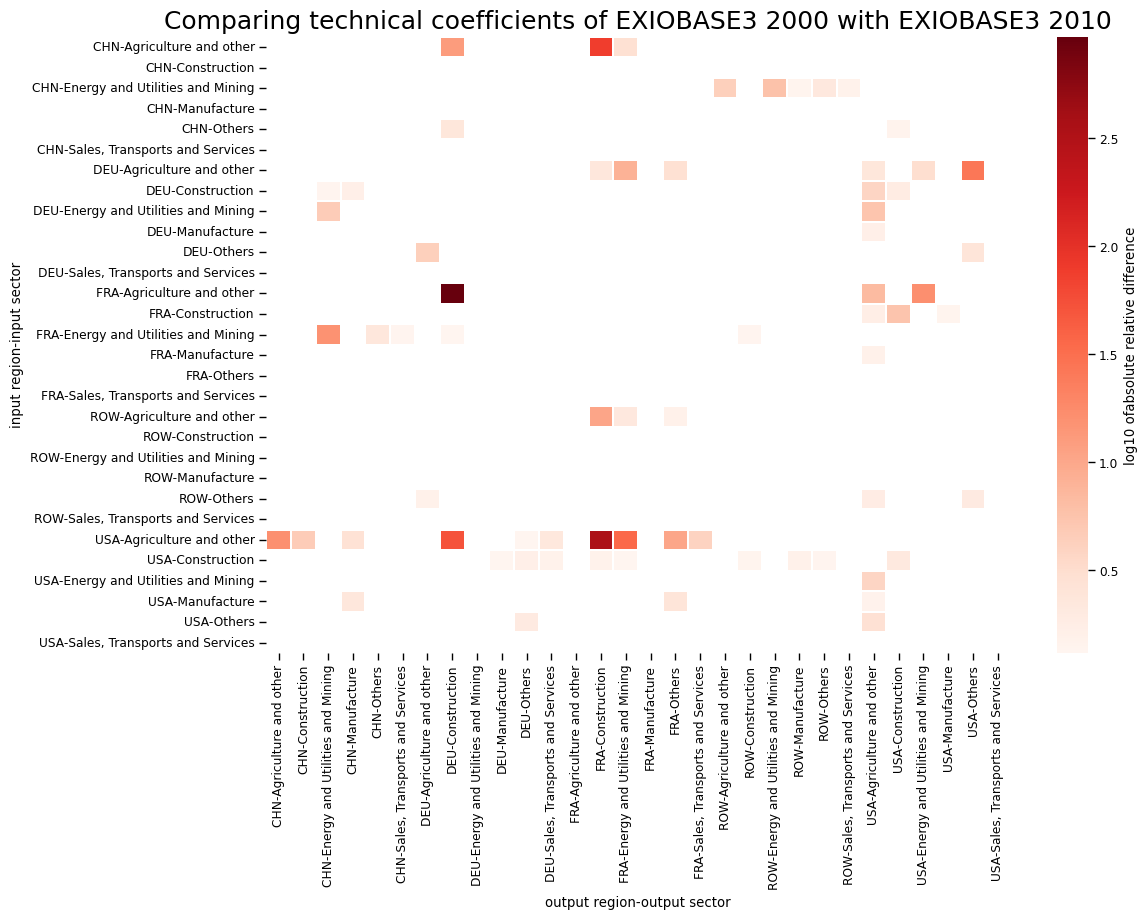

In [33]:
sns.set_context("paper")
MRIO1 = "EXIOBASE3 2010"
MRIO2 = "EXIOBASE3 2000"
fig, ax = plt.subplots(figsize=(12,8))
generate_mriot_diff_plot(mriots, MRIO1, MRIO2, log=True, floor_cap=1e-1)
fig.savefig(f"../../../Latex/imgs-general/Plots/Sensitivity/Comparing_MRIOT_{MRIO1}_with_{MRIO2}.png", bbox_inches="tight")

In [159]:
pd.set_option('display.float_format', lambda x: '%8.8f' % x)
pd.set_option('display.precision',8)
pd.concat([mriots["EORA26 2010"].A.loc[("DEU","Construction")],mriots["EUREGIO 2010"].A.loc[("DEU","Construction")],mriots["EXIOBASE3 2010"].A.loc[("DEU","Construction")]],axis=1)

DEU                
                                              Construction Construction   
output region output sector                                               
CHN           Agriculture and other             0.00000035   0.00000118  \
              Construction                      0.00000021   0.00002498   
              Energy and Utilities and Mining   0.00000023   0.00000200   
              Manufacture                       0.00000008   0.00000189   
              Others                            0.00000503   0.00003176   
              Sales, Transports and Services    0.00000262   0.00000970   
DEU           Agriculture and other             0.00465525   0.00642766   
              Construction                      0.02804197   0.04275772   
              Energy and Utilities and Mining   0.01717799   0.01306017   
              Manufacture                       0.00245145   0.00397421   
              Others                            0.00949976   0.01206032   
              Sales, Transports and Services    0.01427158   0.01285412   
FRA           Agriculture and other             0.00000001   0.00014899   
              Construction                      0.00000000   0.00042534   
              Energy and Utilities and Mining   0.00000003   0.00012439   
              Manufacture                       0.00000001   0.00041555   
              Others                            0.00000000   0.00006224   
              Sales, Transports and Services    0.00000000   0.00004448   
ROW           Agriculture and other             0.00000805   0.00000922   
              Construction                      0.00023347   0.00004252   
              Energy and Utilities and Mining   0.00002756   0.00001018   
              Manufacture                       0.00000930   0.00004556   
              Others                            0.00004799   0.00002882   
              Sales, Transports and Services    0.00002148   0.00001134   
USA           Agriculture and other             0.00000002   0.00001352   
              Construction                      0.00000000   0.00002913   
              Energy and Utilities and Mining   0.00000001   0.00001363   
              Manufacture                       0.00000002   0.00001815   
              Others                            0.00000000   0.00000408   
              Sales, Transports and Services    0.00000000   0.00000294   

                                                            
                                              Construction  
output region output sector                                 
CHN           Agriculture and other             0.00003755  
              Construction                      0.00032019  
              Energy and Utilities and Mining   0.00002234  
              Manufacture                       0.00007069  
              Others                            0.00002465  
              Sales, Transports and Services    0.00002850  
DEU           Agriculture and other             0.01511296  
              Construction                      0.05114264  
              Energy and Utilities and Mining   0.02294332  
              Manufacture                       0.00380283  
              Others                            0.00980063  
              Sales, Transports and Services    0.01465719  
FRA           Agriculture and other             0.00007468  
              Construction                      0.00046068  
              Energy and Utilities and Mining   0.00011697  
              Manufacture                       0.00007417  
              Others                            0.00004554  
              Sales, Transports and Services    0.00007145  
ROW           Agriculture and other             0.00000830  
              Construction                      0.00017016  
              Energy and Utilities and Mining   0.00003043  
              Manufacture                       0.00002131  
              Others                            0.0000

output region  output sector                  
CHN            Agriculture and other              0.000001
               Construction                       0.000025
               Energy and Utilities and Mining    0.000002
               Manufacture                        0.000002
               Others                             0.000032
               Sales, Transports and Services     0.000010
DEU            Agriculture and other              0.006428
               Construction                       0.042758
               Energy and Utilities and Mining    0.013060
               Manufacture                        0.003974
               Others                             0.012060
               Sales, Transports and Services     0.012854
FRA            Agriculture and other              0.000149
               Construction                       0.000425
               Energy and Utilities and Mining    0.000124
               Manufacture                        0.000416
         

output region  output sector                  
CHN            Agriculture and other              3.754677e-05
               Construction                       3.201900e-04
               Energy and Utilities and Mining    2.234474e-05
               Manufacture                        7.069261e-05
               Others                             2.464576e-05
               Sales, Transports and Services     2.849581e-05
DEU            Agriculture and other              1.511296e-02
               Construction                       5.114264e-02
               Energy and Utilities and Mining    2.294332e-02
               Manufacture                        3.802834e-03
               Others                             9.800629e-03
               Sales, Transports and Services     1.465719e-02
FRA            Agriculture and other              7.467781e-05
               Construction                       4.606782e-04
               Energy and Utilities and Mining    1.169671e-04
        